In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", font_scale=1.2, rc={'axes.labelsize': 16, 'legend.fontsize': 14, 
                                              'grid.color': '.6', 'grid.linestyle': ':'})
import os
import copy
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier, VotingClassifier, 
                              GradientBoostingClassifier, AdaBoostClassifier) 
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from lightgbm import LGBMClassifier
# !pip install catboost
from catboost import CatBoostClassifier
# !pip install xgboost
from xgboost.sklearn import XGBClassifier
# !pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import callbacks
# !pip install scikeras
from scikeras.wrappers import KerasClassifier
# !pip install imblearn
from imblearn.over_sampling import SMOTE

# !pip install hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials      # для оптимизации гиперпараметров
from functools import partial 
from scipy.stats import sem, t, norm, ttest_rel

# !pip install git+https://github.com/WillKoehrsen/feature-selector.git
from feature_selector import FeatureSelector

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)
tf.random.set_seed(0)

# Содержание

0. Загрузка данных

1. Анализ данных
   1. Основные характеристики данных
   2. Визуализация распределений признаков
   
2. Обработка признаков (различные способы)
   1. Удаление обоих признаков, где есть пропуски
   2. Удаление всех строк с пропущенными значениями, в X_test все пропуски -> медиана
   3. Удаление строк с пропусками в family_members, пропуски в monthly_income -> медиана, в X_test все пропуски -> медиана
   4. Замена всех пропусков на медианное значение
   5. Замена пропусков в monthly_income на медианное значение, удаление признака family_members
   6. Замена пропусков на медианное значение, удаление признаков overdue__more_than_90_days, overdue_60_89_days
   7. Замена пропусков с помощью KNN Imputer
   8. Разбиение данных для признаков с пропусками на категории
       1. Пропущенные значения = новый класс
       2. Пропущенные значения заполняются с помощью KNN Imputer
       3. KNN Imputer в monthly_income, в family_members - медиана
   9. Итог: сравнение результатов
   10. Как меняется качество модели при варьировании числа соседей для KNNImputer   

3. Создание простых моделей
   1. LinearRegression
   2. LogisticRegression
   3. KNN
   4. SGD Classifier 
   5. Decision Tree
   6. Задание с кросс-валидацией.
      1. Зависимость mean_score и доверительного интервала от числа фолдов
      2. Распределение скоров при большом числе фолдов 

4. Сравнение простых моделей
   1. Визуализация результатов
   2. Применение SMOTE для решения проблемы дисбаланса классов
5. Ансамбли моделей
   1. Бэггинги
   2. Бустинги
      1. LGBMClassifier
      2. CatBoostClassifier
      3. XGBoostClassifier
      4. GradientBoostingClassifier
6. Полносвязная нейронная сеть
7. Сравнение результатов всех моделей
8. Попытки улучшить
   1. Генерация новых признаков
   2. Блендинг моделей
      1. CatBoost + LGBM
      2. CatBoost + LGBM + нейронная сеть
9. Предсказание вероятностей для тестового набора данных     

# 0. Загрузка данных

In [2]:
X_train = pd.read_csv("srm23-spring-bank-scoring-case/X_train.csv")
X_test = pd.read_csv("srm23-spring-bank-scoring-case/X_test.csv")
y_train = pd.read_csv("srm23-spring-bank-scoring-case/y_train.csv")

# 1. Анализ данных

## 1.1 Основные характеристики данных: 
Типы данных, количество пропущенных значений, количество строк/столбцов, основные количественные и категориальные статистики, количество дубликатов. 

In [3]:
def get_info(df):
    'первичный обзор датафрейма'
    
    print('Обзор датафрейма:')
    display(df.head(5))
    print('-'*100)
    print('Информация о датафрейме:')
    df.info()
    print('-'*100)
    print('Дополнительные характеристики данных в датафрейме:')
    display(df.describe())
    print('-'*100)
    print('Кол-во строк и столбцов:')
    print(df.shape)
    print('-'*100)
    print('Кол-во пропусков:')
    display(df.isna().mean())
    print('-'*100)
    print('Кол-во дубликатов:')
    print(df.duplicated().sum())
    print()
    print('*'*100)
    print('*'*100)
    print('*'*100)

In [4]:
# вывод развернутой информации о датафреймах
for df in [X_train, X_test, y_train]:
    get_info(df)

Обзор датафрейма:


credit_card_utilization  age  overdue_30_59_days  debt_to_income  \
0                 0.000000   56                   0        0.504328   
1                 0.170659   45                   1        2.405860   
2                 0.342176   75                   1        0.445066   
3                 0.046219   50                   0        0.814508   
4                 0.679556   58                   0        0.390311   

   monthly_income  credits_loans  overdue__more_than_90_days  mortgage_loans  \
0     6823.894458              9                           0               1   
1      356.580765              5                           0               0   
2    20349.895825              9                           0               3   
3     2894.368968             12                           0               1   
4    24833.227614             15                           0               4   

   overdue_60_89_days  family_members  
0                   0             5.0  
1                   0             0.0  
2                   0             0.0  
3                   0             3.0  
4                   0             2.0

----------------------------------------------------------------------------------------------------
Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105109 entries, 0 to 105108
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   credit_card_utilization     105109 non-null  float64
 1   age                         105109 non-null  int64  
 2   overdue_30_59_days          105109 non-null  int64  
 3   debt_to_income              105109 non-null  float64
 4   monthly_income              84116 non-null   float64
 5   credits_loans               105109 non-null  int64  
 6   overdue__more_than_90_days  105109 non-null  int64  
 7   mortgage_loans              105109 non-null  int64  
 8   overdue_60_89_days          105109 non-null  int64  
 9   family_members              102304 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 8.0 MB
-----------------

credit_card_utilization            age  overdue_30_59_days  \
count            105109.000000  105109.000000       105109.000000   
mean                  5.825173      53.321067            0.426643   
std                 251.021431      14.811007            4.251225   
min                   0.000000       0.000000            0.000000   
25%                   0.029592      42.000000            0.000000   
50%                   0.153792      53.000000            0.000000   
75%                   0.554374      64.000000            0.000000   
max               48779.730023     111.000000           98.000000   

       debt_to_income  monthly_income  credits_loans  \
count   105109.000000    8.411600e+04  105109.000000   
mean       354.188156    6.649725e+03       8.956255   
std       1827.184165    1.106504e+04       5.182715   
min          0.000000    0.000000e+00       0.000000   
25%          0.173670    3.343201e+03       5.000000   
50%          0.365047    5.361778e+03       8.000000   
75%          0.880882    8.207866e+03      12.000000   
max     323248.210242    1.359526e+06      58.000000   

       overdue__more_than_90_days  mortgage_loans  overdue_60_89_days  \
count               105109.000000   105109.000000       105109.000000   
mean                     0.269967        1.018514            0.244356   
std                      4.227366        1.136228            4.214018   
min                      0.000000        0.000000            0.000000   
25%                      0.000000        0.000000            0.000000   
50%                      0.000000        1.000000            0.000000   
75%                      0.000000        2.000000            0.000000   
max                     98.000000       54.000000           98.000000   

       family_members  
count   102304.000000  
mean         0.757096  
std          1.116525  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          1.000000  
max         20.000000

----------------------------------------------------------------------------------------------------
Кол-во строк и столбцов:
(105109, 10)
----------------------------------------------------------------------------------------------------
Кол-во пропусков:


credit_card_utilization       0.000000
age                           0.000000
overdue_30_59_days            0.000000
debt_to_income                0.000000
monthly_income                0.199726
credits_loans                 0.000000
overdue__more_than_90_days    0.000000
mortgage_loans                0.000000
overdue_60_89_days            0.000000
family_members                0.026687
dtype: float64

----------------------------------------------------------------------------------------------------
Кол-во дубликатов:
137

****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
Обзор датафрейма:


index  credit_card_utilization  age  overdue_30_59_days  debt_to_income  \
0  143522                 0.021069   60                   0        0.184907   
1  116747                 0.009985   82                   0        0.446264   
2   66075                 0.535187   43                   1        0.406317   
3  133292                 0.051264   31                   0        0.311893   
4   83134                 0.069525   45                   0        0.294956   

   monthly_income  credits_loans  overdue__more_than_90_days  mortgage_loans  \
0    14403.715440              9                           0               1   
1     6768.581963              6                           0               3   
2     4686.080429             14                           0               2   
3     3867.175176              8                           0               0   
4     9869.273012              6                           0               1   

   overdue_60_89_days  family_members  
0                   0             0.0  
1                   0             0.0  
2                   0             3.0  
3                   0             1.0  
4                   0             2.0

----------------------------------------------------------------------------------------------------
Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38876 entries, 0 to 38875
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       38876 non-null  int64  
 1   credit_card_utilization     38876 non-null  float64
 2   age                         38876 non-null  int64  
 3   overdue_30_59_days          38876 non-null  int64  
 4   debt_to_income              38876 non-null  float64
 5   monthly_income              31331 non-null  float64
 6   credits_loans               38876 non-null  int64  
 7   overdue__more_than_90_days  38876 non-null  int64  
 8   mortgage_loans              38876 non-null  int64  
 9   overdue_60_89_days          38876 non-null  int64  
 10  family_members              37921 non-null  float64
dtypes: float64(4), int6

index  credit_card_utilization           age  \
count   38876.000000             38876.000000  38876.000000   
mean    71772.980116                 7.143140     53.236238   
std     41436.065456               259.023345     14.772393   
min         5.000000                 0.000000     21.000000   
25%     35939.250000                 0.029097     42.000000   
50%     71714.000000                 0.152136     53.000000   
75%    107495.250000                 0.558911     64.000000   
max    143975.000000             32131.063581    110.000000   

       overdue_30_59_days  debt_to_income  monthly_income  credits_loans  \
count        38876.000000    38876.000000    3.133100e+04   38876.000000   
mean             0.406986      351.627896    6.726128e+03       8.946599   
std              4.023815     2545.254355    2.116051e+04       5.153647   
min              0.000000        0.000000    0.000000e+00       0.000000   
25%              0.000000        0.170806    3.349846e+03       5.000000   
50%              0.000000        0.361875    5.339619e+03       8.000000   
75%              0.000000        0.843592    8.264207e+03      12.000000   
max             98.000000   349464.845051    3.117341e+06      56.000000   

       overdue__more_than_90_days  mortgage_loans  overdue_60_89_days  \
count                38876.000000    38876.000000        38876.000000   
mean                     0.252598        1.017466            0.229808   
std                      3.999838        1.113531            3.985055   
min                      0.000000        0.000000            0.000000   
25%                      0.000000        0.000000            0.000000   
50%                      0.000000        1.000000            0.000000   
75%                      0.000000        2.000000            0.000000   
max                     98.000000       23.000000           98.000000   

       family_members  
count    37921.000000  
mean         0.759131  
std          1.112832  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          1.000000  
max          9.000000

----------------------------------------------------------------------------------------------------
Кол-во строк и столбцов:
(38876, 11)
----------------------------------------------------------------------------------------------------
Кол-во пропусков:


index                         0.000000
credit_card_utilization       0.000000
age                           0.000000
overdue_30_59_days            0.000000
debt_to_income                0.000000
monthly_income                0.194079
credits_loans                 0.000000
overdue__more_than_90_days    0.000000
mortgage_loans                0.000000
overdue_60_89_days            0.000000
family_members                0.024565
dtype: float64

----------------------------------------------------------------------------------------------------
Кол-во дубликатов:
0

****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
Обзор датафрейма:


target
0       0
1       0
2       0
3       0
4       0

----------------------------------------------------------------------------------------------------
Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105109 entries, 0 to 105108
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   target  105109 non-null  int64
dtypes: int64(1)
memory usage: 821.3 KB
----------------------------------------------------------------------------------------------------
Дополнительные характеристики данных в датафрейме:


target
count  105109.000000
mean        0.066892
std         0.249837
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

----------------------------------------------------------------------------------------------------
Кол-во строк и столбцов:
(105109, 1)
----------------------------------------------------------------------------------------------------
Кол-во пропусков:


target    0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Кол-во дубликатов:
105107

****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


### Мысли и замечания: 
1. Все столбцы - количественные признаки, нет категориальных (хотя некоторые, в принципе, можно таковыми сделать)
2. `family_members` имеет тип данных float -> можно сделать int
3. Есть дубликаты в `X_train` => убрать лишние
4. Можно построить гистограммы признаков, но и по имеющейся информации видно, что признаки имеют различные масштабы => нужно нормировать их
5. Интересно, что значения всех признаков неотрицательные
6. Имеются пропуски в датафреймах: `monthly_income` и `family_members` => требуется как-то обработать
7. Нужно построить матрицу парных корреляций и убрать сильно коррелирующие признаки (или не убирать: посмотреть на то, как изменится качество моделей)
8. Среднее значение таргета 0.06 => гораздо больше элементов класса 0, чем класса 1 (хотя еще желательно проверить, что нет других меток)
9. Признаков немного: всего 10 => возможно стоит сгенерировать дополнительные признаки.

## 1.2 Визуализация распределений признаков

In [5]:
def dist_box(col, dtype='float', data='train', bins = 100):
    '''
    построение гистограммы распределения признака (с выделением цветом таргета) и boxplot над ним
    col - исследуемый признак
    dtype - тип данных признака (float/int)
    data - train или test датафрейм
    bins - количество столбцов в гистограмме
    '''
    if data == 'train':
        X = X_train.merge(y_train, left_index=True, right_index=True)
    else:
        X = X_test
    
    fig, (ax_box, ax_dis) = plt.subplots(nrows=2,sharex=True, gridspec_kw = {"height_ratios": (0.25, 0.75)}, figsize=(8, 5))
    mean, median = X[col].mean(), X[col].median() 
    formatted_mean, formatted_median = "{:.2f}".format(mean), "{:.2f}".format(median)
    fig.suptitle(f"Распределение '{col}' в X_{data}", fontsize=16, fontweight='bold')
    
    # boxplot
    sns.boxplot(x=X[col], showmeans=True, orient='h',color="tan", ax=ax_box)
    ax_box.set(xlabel='')

    # histplot
    params_test = {'data': X, 'x': col, 'bins': bins, 'ax': ax_dis}
    params_float = {'data': X, 'x': col, 'hue': 'target', 'multiple': 'stack', 'bins': bins, 'ax': ax_dis} 
    
    if data == 'train':
        if dtype == 'float':
            sns.histplot(kde=True, **params_float)
        else:
            sns.histplot(discrete=True, **params_float)

        hist_legend = ax_dis.legend(labels=["1", "0"], loc='center right', title='target')
        ax_dis.add_artist(hist_legend)
        
    elif data == 'test':
        if dtype == 'float':
            sns.histplot(kde=True, **params_test)
        else:
            sns.histplot(discrete=True, **params_test)

    # матожидание и медиана
    ax_dis.axvline(mean, color='r', linestyle='--',linewidth=2, label=f'Mean = {formatted_mean}')
    ax_dis.axvline(median, color='g', linestyle='-', linewidth=2, label=f'Median = {formatted_median}')
    ax_dis.legend()
      

In [6]:
def plot_class_ratio(ax, col, bins=20, rotation=0):
    '''
    Построение графика зависимости отношения количества объектов, принадлежащих к разным классам от значения признака
    ax - объект рисунка
    col - признак
    bins - количество столбцов гистограммы
    rotation - угол поворота подписи оси абсцисс
    '''
    # извлечение информации о столбцах гистограммы
    heights = [p.get_height() for p in ax.patches]
    heights_class_1 = heights[:len(heights)//2] # высота столбца с target = 1
    heights_class_0 = heights[len(heights)//2:] # высота столбца с target = 0
    class_ratio = [a/b if b!=0 else 0 for a,b in zip(heights_class_1,heights_class_0) ] # отношение высот столбцов
    coords = [p.get_x() + p.get_width() / 2. for p in ax.patches]
    coords = coords[:len(coords)//2]  # координаты столбцов
    fig, ax_class = plt.subplots(figsize=(8, 4))
    ax_class = sns.barplot(x=coords, y=class_ratio, color='orange', width=0.99)
    ax_class.set(xlabel=col, ylabel='class1/class0_ratio', title='Зависимость отношения классов от значения признака')
    ax_class.set_xticks(range(len(coords))[::(bins//10)], [round(x,2) for x in coords[::(bins//10)]], rotation=rotation)        
    

In [7]:
# список всех признаков
print(X_train.columns.to_list())

['credit_card_utilization', 'age', 'overdue_30_59_days', 'debt_to_income', 'monthly_income', 'credits_loans', 'overdue__more_than_90_days', 'mortgage_loans', 'overdue_60_89_days', 'family_members']


### 1.2.1 credit_card_utilization

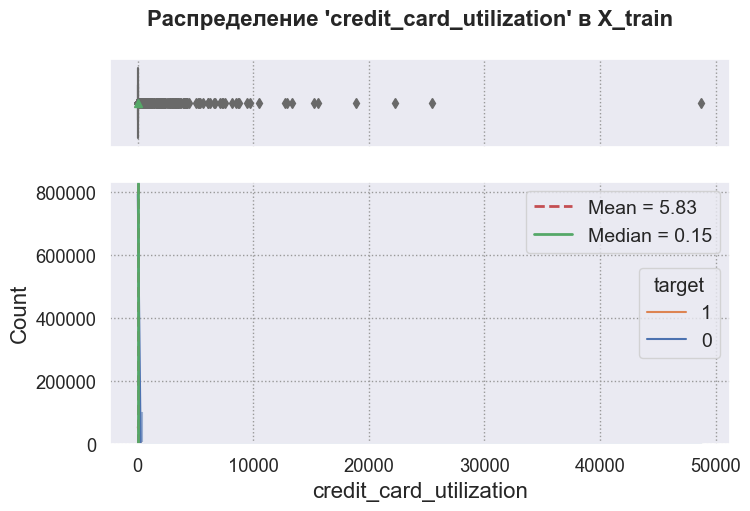

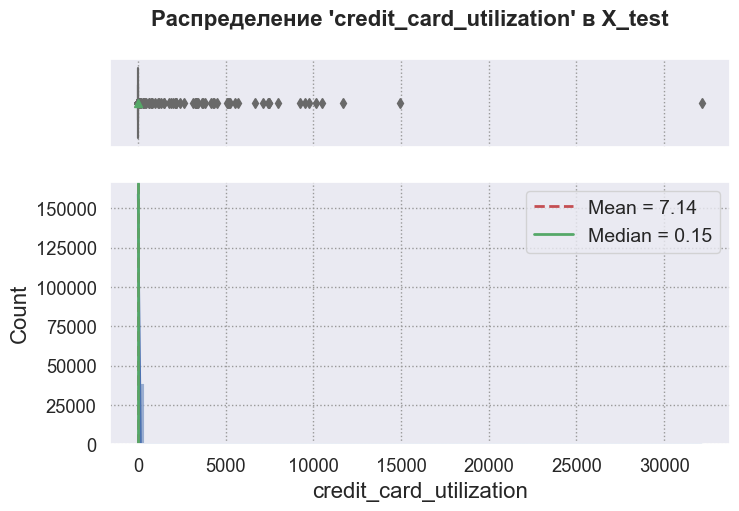

In [8]:
dist_box('credit_card_utilization', data='train')
dist_box('credit_card_utilization', data='test')

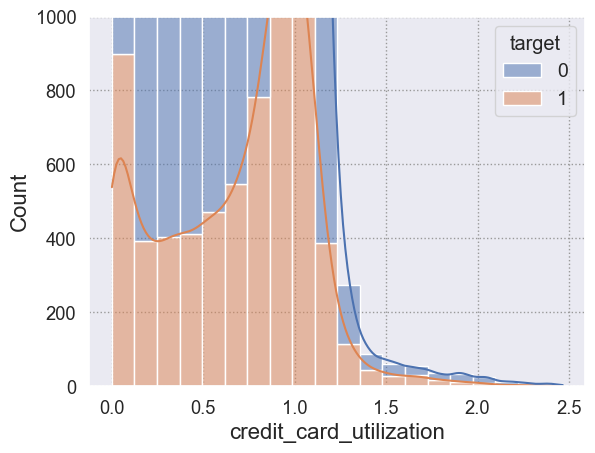

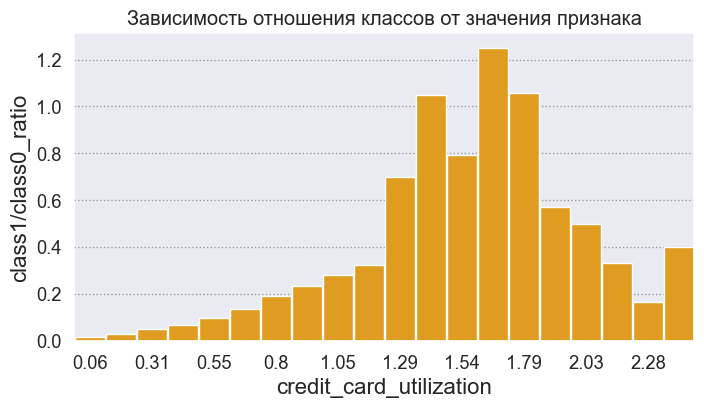

In [9]:
# данные в более крупном масштабе
ax = sns.histplot(data=X_train[X_train.credit_card_utilization<2.5].merge(y_train, left_index=True, right_index=True), 
              x='credit_card_utilization', kde=True, hue='target', multiple='stack', bins=20)
ax.set_ylim([0, 1000])
plot_class_ratio(ax, 'credit_card_utilization')
plt.show()

#### Мысли: 
1. Отношение баланса на счету к лимиту по кредиту в половине случаев не превосходит 0.15, однако наблюдается немало выбросов (даже есть значение 50000): в результате чего среднее равно 5.83 в `X_train` и 7.14 в `X_test`. 
2. Распределения в `X_train` и `X_test` очень похожи.
3. Соотношение таргетов в зависимости от признака явно является неравномерным => хороший признак


### 1.2.2 age

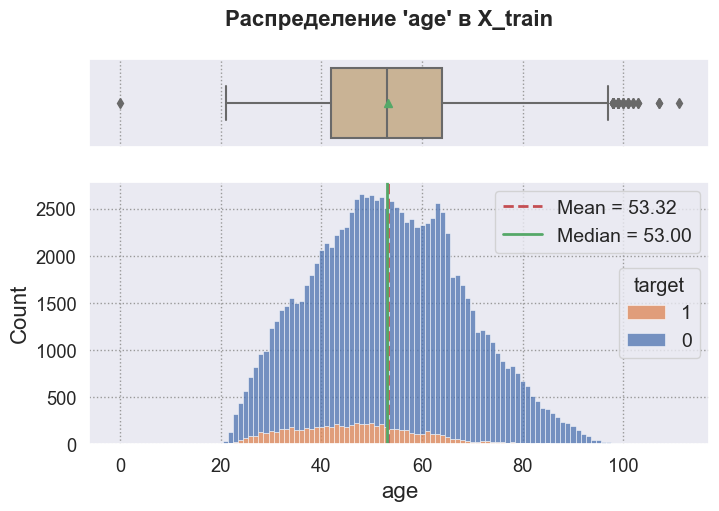

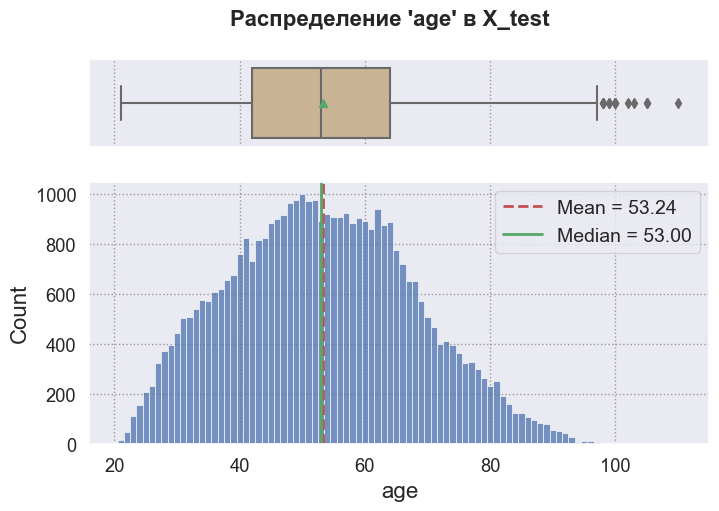

In [10]:
dist_box('age', 'int', data='train')
dist_box('age', 'int', data='test')

#### Мысли:
1. В целом адекватные значения возраста, однако имеются выбросы: возраст 0? и несколько значений возраста более 100 лет (хотя почему бы и нет). => можно удалить строку(строки), где возраст равен 0 (более осмысленно: <18 лет)
2. Распределения схожи, их медианы совпадают (53 года), а средние значения отличаются менее, чем на одну десятую.
3. В `X_train` target = 1 немного смещен в меньшую сторону (более молодые заемщики совершают просрочки).
4. Соотношение таргетов в зависимости от возраста явно является неравномерным => хороший признак

In [11]:
# удаляем из трейна людей, чей возраст меньше 18 лет
display(X_train[X_train.age<18])
X_train = X_train[X_train.age>18]
y_train = y_train[y_train.index.isin(X_train.index)]

credit_card_utilization  age  overdue_30_59_days  debt_to_income  \
38302                 0.780941    0                   1        0.423712   

       monthly_income  credits_loans  overdue__more_than_90_days  \
38302     5860.305791              6                           0   

       mortgage_loans  overdue_60_89_days  family_members  
38302               2                   0             2.0

### 1.2.3 overdue_30_59_days

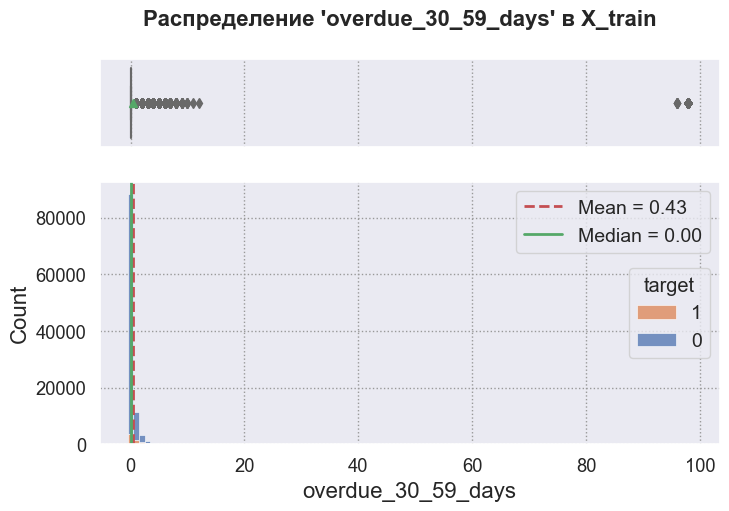

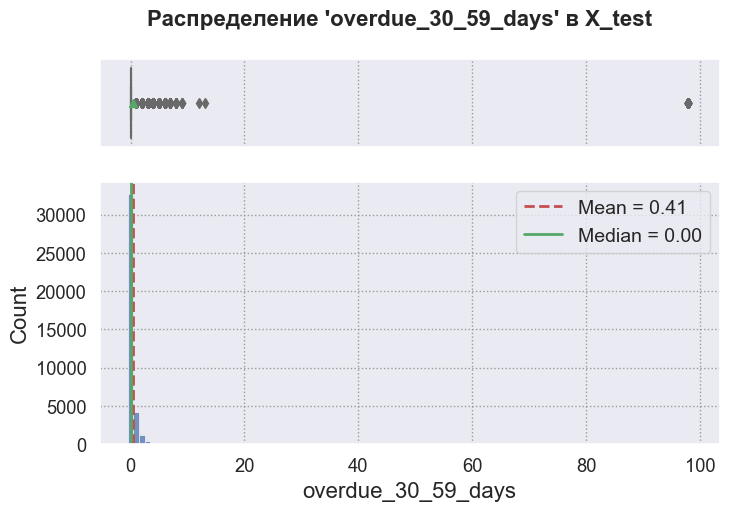

In [12]:
dist_box('overdue_30_59_days', 'int', data='train')
dist_box('overdue_30_59_days', 'int', data='test')

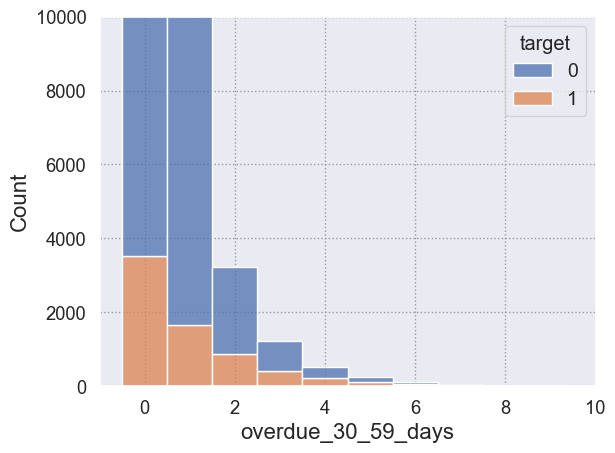

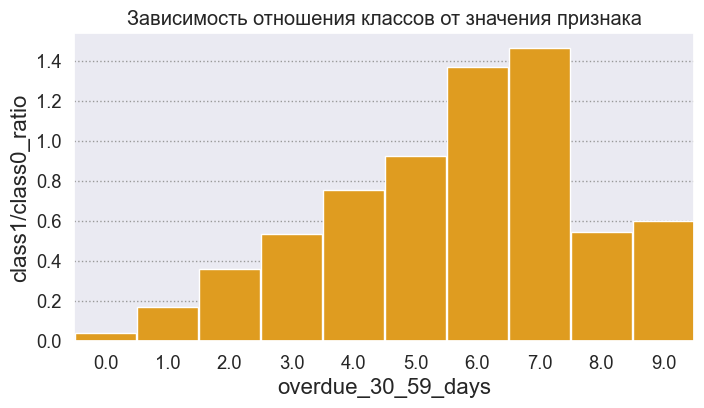

In [13]:
# данные в более крупном масштабе
ax=sns.histplot(data=X_train[X_train.overdue_30_59_days<10].merge(y_train, left_index=True, right_index=True), 
              x='overdue_30_59_days', discrete=True, hue='target', multiple='stack', bins=100, stat='count')
ax.set_ylim([0,10000])
plot_class_ratio(ax, 'overdue_30_59_days', bins=10)
plt.show()

In [14]:
# уникальные значения overdue_30_59_days в X_train
print(sorted(X_train.overdue_30_59_days.unique()))
# уникальные значения overdue_30_59_days в X_test
print(sorted(X_test.overdue_30_59_days.unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 96, 98]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 98]


#### Мысли:
1. Распределения схожи, их медианы совпадают, а средние значения отличаются совсем немного.
2. Имеются выбросы как в `X_train`, так и в `X_test` => не буду их удалять.
3. Соотношение таргетов в зависимости от признака  неравномерное => хороший признак

### 1.2.4 debt_to_income

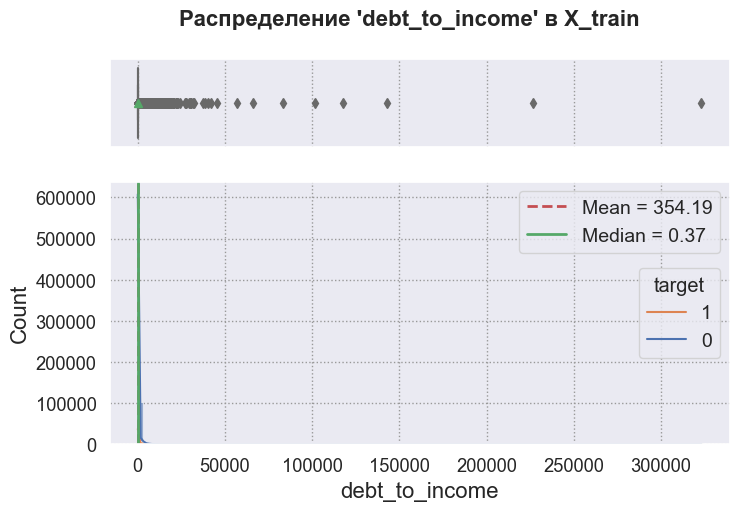

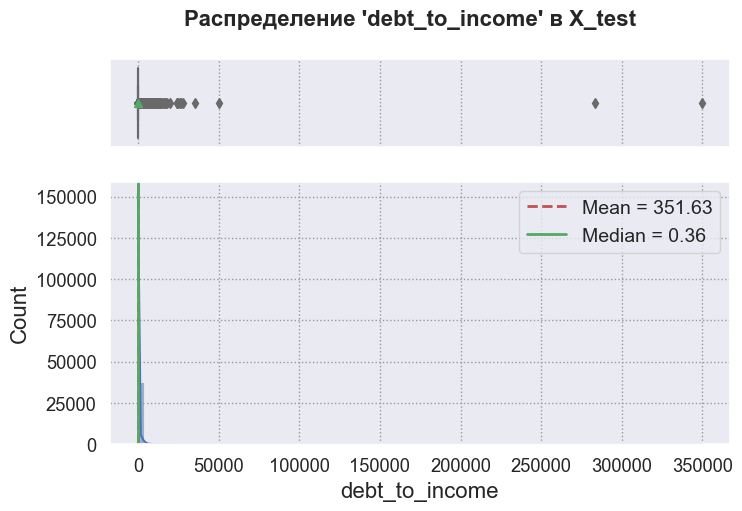

In [15]:
dist_box('debt_to_income', data='train')
dist_box('debt_to_income', data='test')

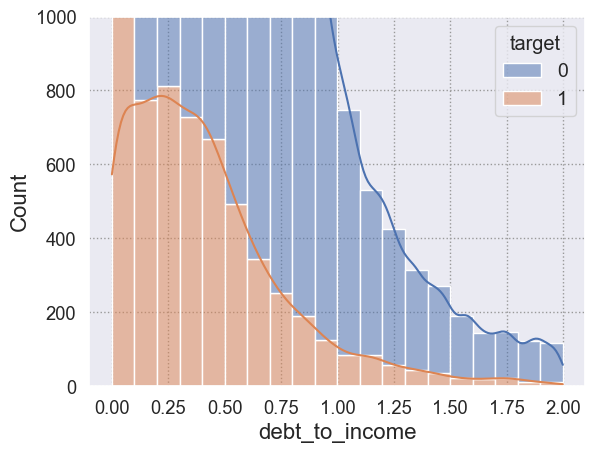

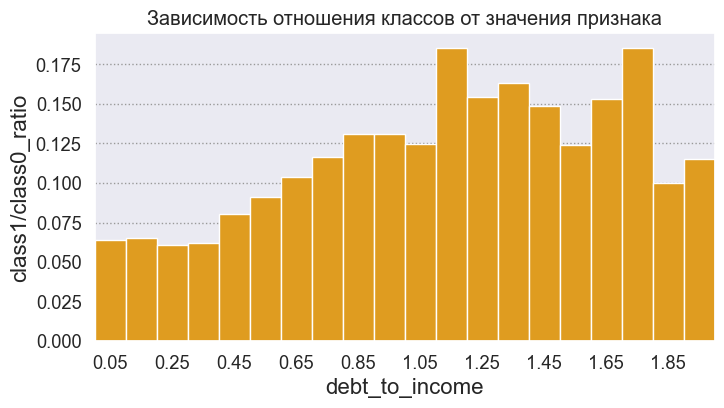

In [16]:
# данные в более крупном масштабе
ax=sns.histplot(data=X_train[X_train.debt_to_income<2].merge(y_train, left_index=True, right_index=True), 
              x='debt_to_income', kde=True, hue='target', multiple='stack', bins=20)
ax.set_ylim([0,1000])
plot_class_ratio(ax, 'debt_to_income', bins=20)
plt.show()

#### Мысли:
1. Распределения схожи, их медианы и средние значения отличаются совсем немного.
2. Имеются выбросы как в `X_train`, так и в `X_test` => не буду их удалять.
3. Соотношение таргетов в зависимости от признака не постоянное, но меняется не сильно  => нормальный признак

### 1.2.5 monthly_income

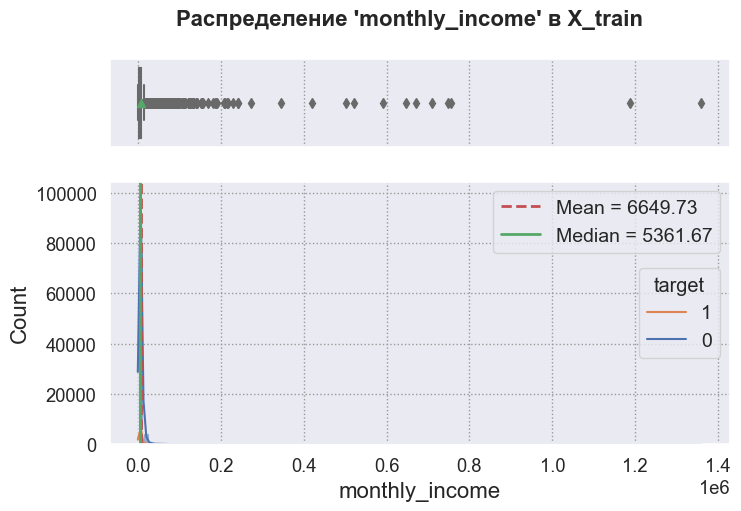

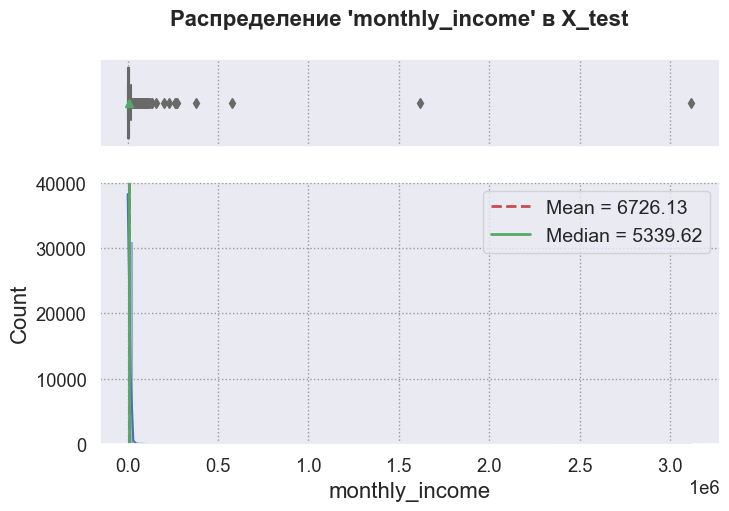

In [17]:
dist_box('monthly_income', data='train')
dist_box('monthly_income', data='test')

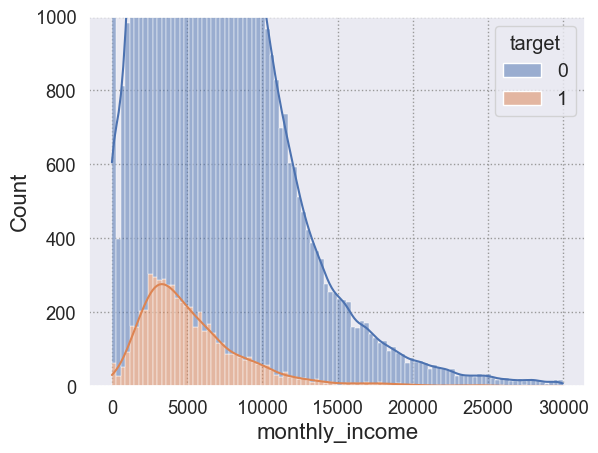

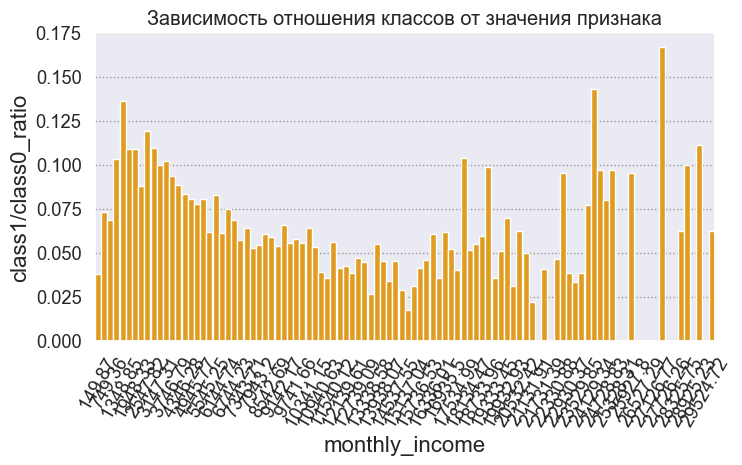

In [18]:
# данные в более крупном масштабе
ax=sns.histplot(data=X_train[X_train.monthly_income<30_000].merge(y_train, left_index=True, right_index=True), 
              x='monthly_income', kde=True, hue='target', multiple='stack', bins=100)
ax.set_ylim([0,1000])
plot_class_ratio(ax, 'monthly_income', rotation=60)
plt.show()

#### Мысли:
1. Распределения схожи, их медианы и средние значения отличаются совсем немного.
2. Имеются выбросы как в `X_train`, так и в `X_test` => не буду их удалять.
3. Соотношение таргетов в зависимости от признака не постоянное, но меняется не сильно => нормальный признак
4. Еще из первичного анализа помним, что порядка 20% данных этого признака пропущены => нужно осознанно заполнить пропуски

### 1.2.6 credits_loans

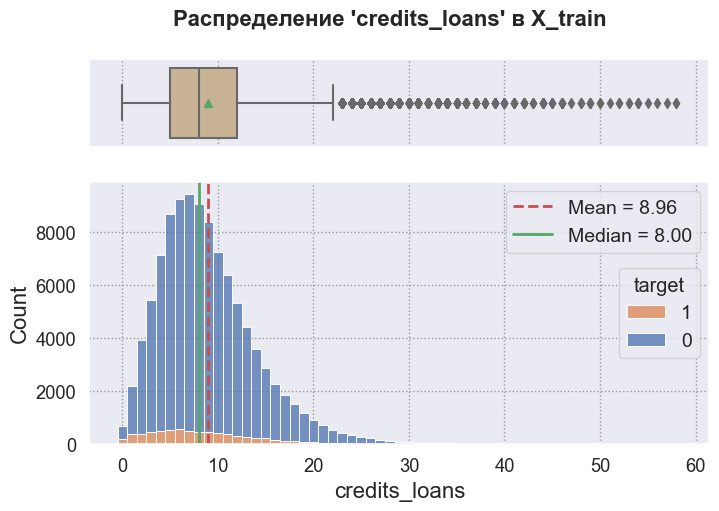

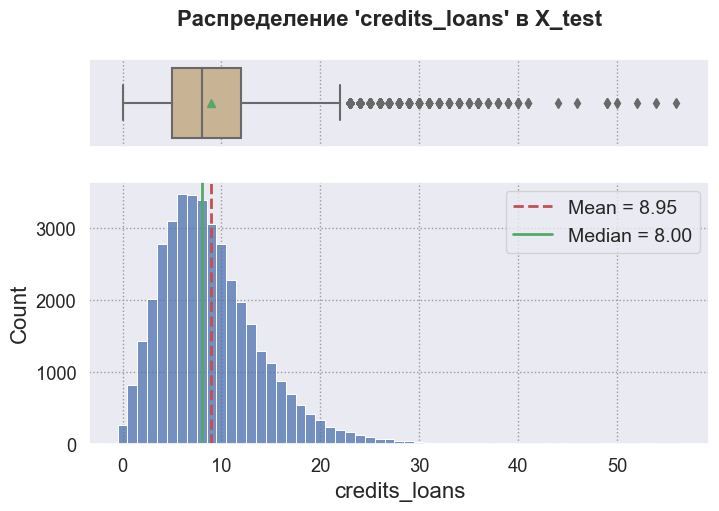

In [19]:
dist_box('credits_loans', 'int', data='train')
dist_box('credits_loans', 'int', data='test')

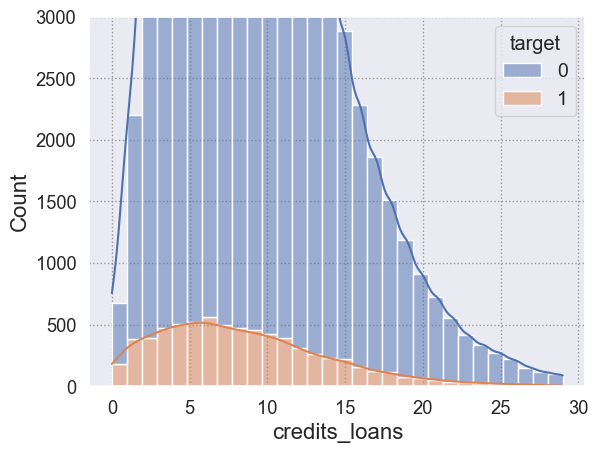

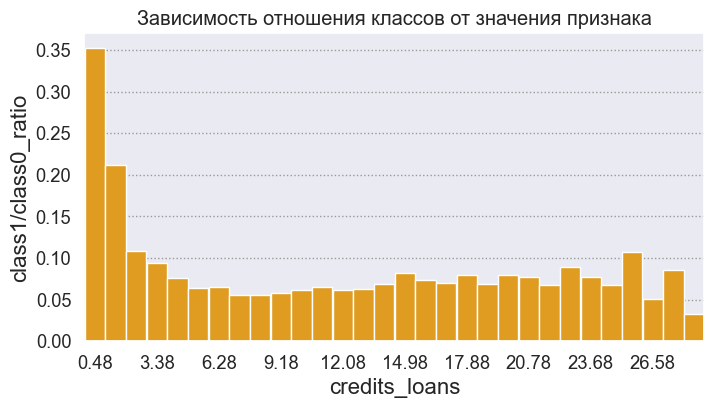

In [20]:
# данные в более крупном масштабе
ax=sns.histplot(data=X_train[X_train.credits_loans<30].merge(y_train, left_index=True, right_index=True), 
              x='credits_loans', kde=True, hue='target', multiple='stack', bins=30)
ax.set_ylim([0,3000])
plot_class_ratio(ax, 'credits_loans', bins=30)
plt.show()

#### Мысли:
1. Распределения очень похожи, их медианы равны, а средние значения отличаются совсем немного.
2. Имеются выбросы как в `X_train`, так и в `X_test` => не буду их удалять.
3. Соотношение таргетов в зависимости от признака не постоянное (при малых значениях признака) => хороший признак

### 1.2.7 overdue__more_than_90_days

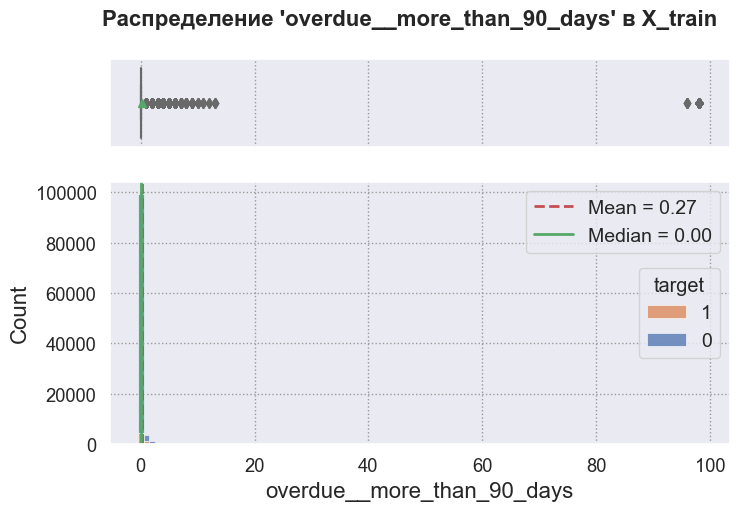

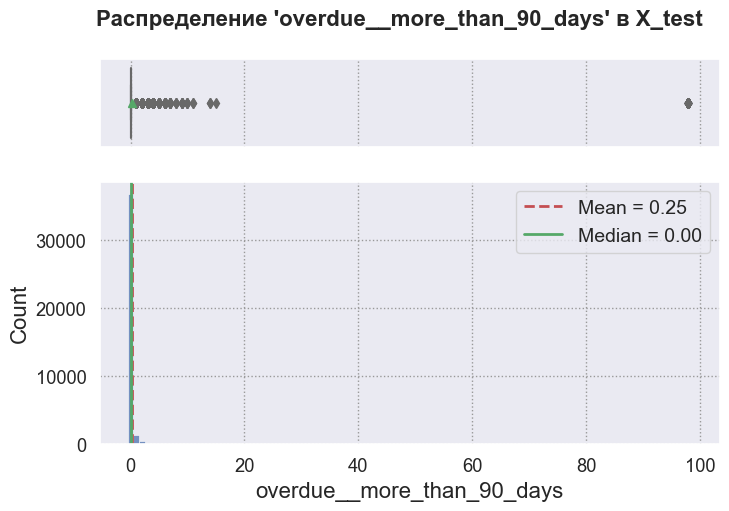

In [21]:
dist_box('overdue__more_than_90_days', 'int', data='train')
dist_box('overdue__more_than_90_days', 'int', data='test')

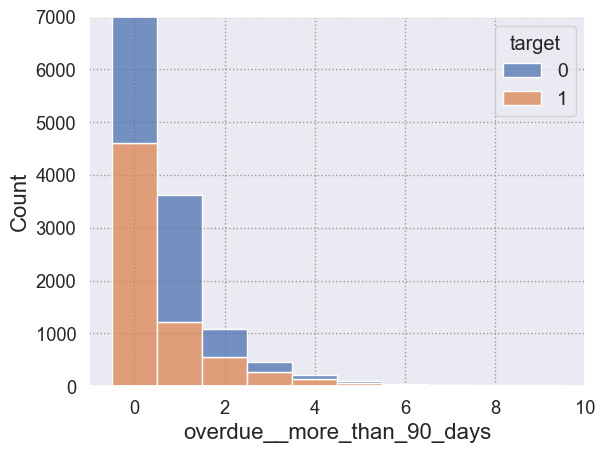

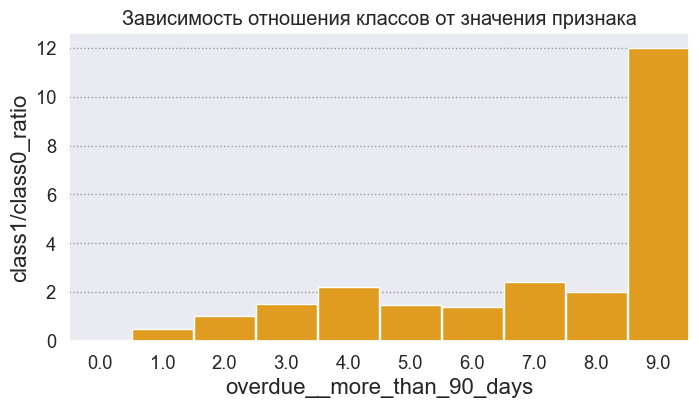

In [22]:
# данные в более крупном масштабе
ax=sns.histplot(data=X_train[X_train.overdue__more_than_90_days<10].merge(y_train, left_index=True, right_index=True), 
              x='overdue__more_than_90_days', discrete=True, hue='target', multiple='stack', bins=10)
ax.set_ylim([0,7000])
plot_class_ratio(ax, 'overdue__more_than_90_days', bins=10)
plt.show()

#### Мысли:
1. Распределения очень похожи, их медианы равны, а средние значения отличаются совсем немного.
2. Имеются выбросы как в `X_train`, так и в `X_test` => не буду их удалять.
3. Соотношение таргетов в зависимости от признака можно считать непостоянным => нормальный признак

### 1.2.8 mortgage_loans

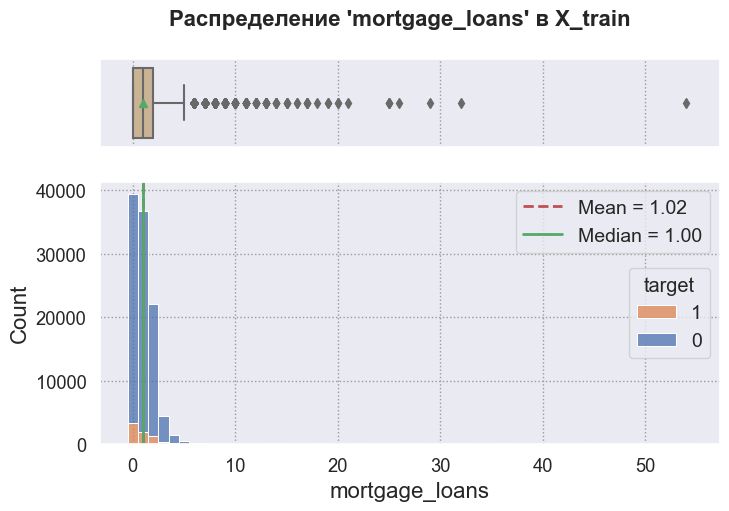

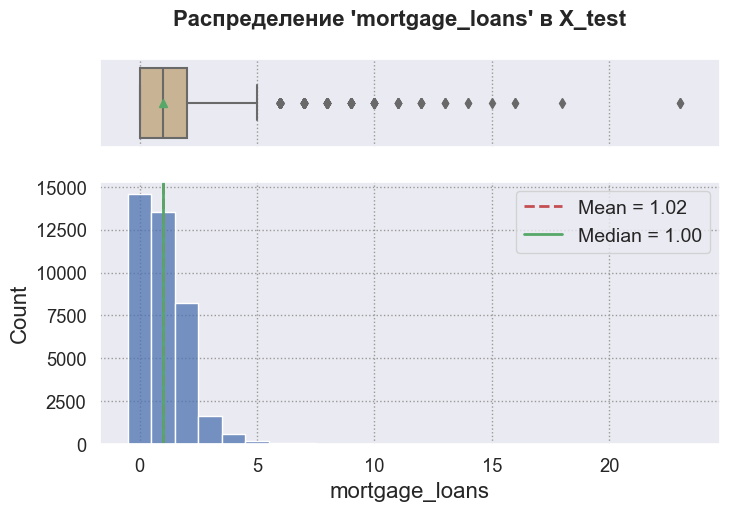

In [23]:
dist_box('mortgage_loans', 'int', data='train')
dist_box('mortgage_loans', 'int', data='test')

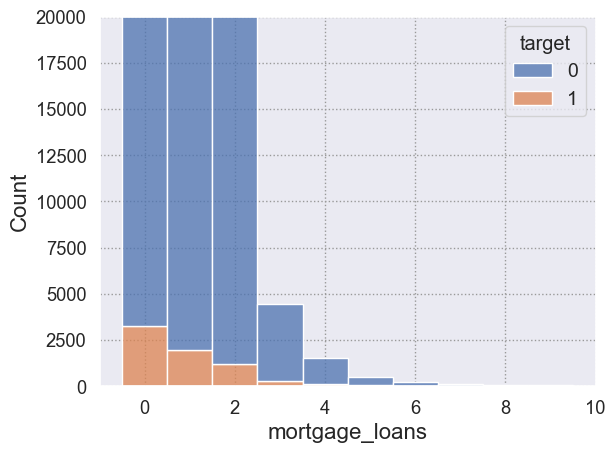

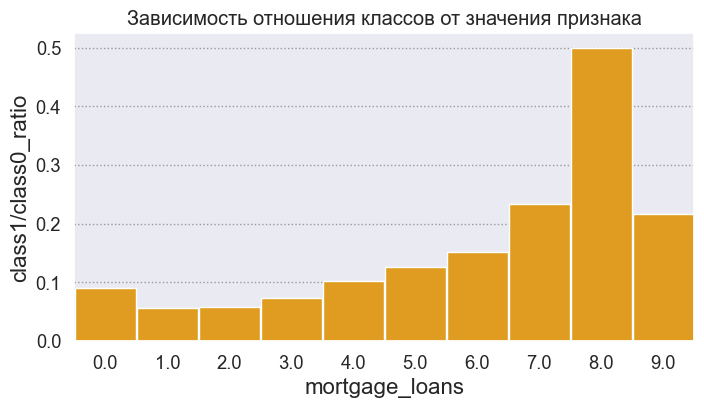

In [24]:
# данные в более крупном масштабе
ax=sns.histplot(data=X_train[X_train.mortgage_loans<10].merge(y_train, left_index=True, right_index=True), 
              x='mortgage_loans', discrete=True, hue='target', multiple='stack', bins=10)
ax.set_ylim([0,20000])
plot_class_ratio(ax, 'mortgage_loans', bins=10)
plt.show()

#### Мысли:
1. Распределения очень похожи, их медианы и средние значения равны.
2. Имеются выбросы как в `X_train`, так и в `X_test` => не буду их удалять.
3. Соотношение таргетов в зависимости от признака практически постоянное (лишь при больших значениях - выбросах разко меняется отношение) => средний признак

### 1.2.9 overdue_60_89_days

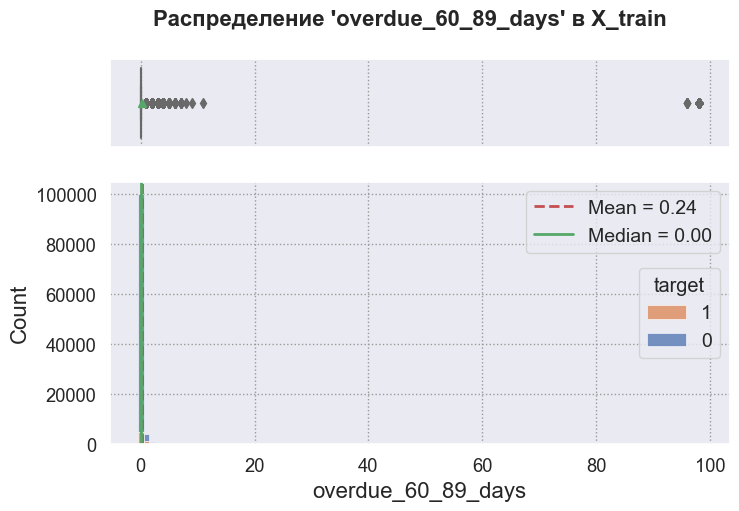

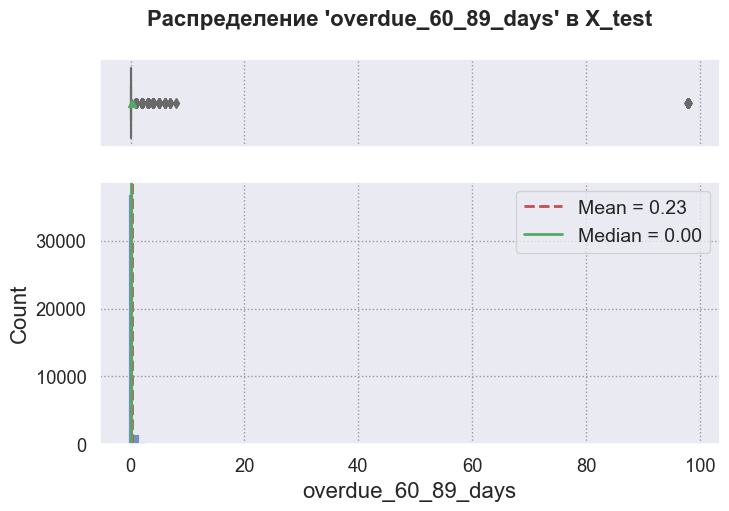

In [25]:
dist_box('overdue_60_89_days', 'int', data='train')
dist_box('overdue_60_89_days', 'int', data='test')

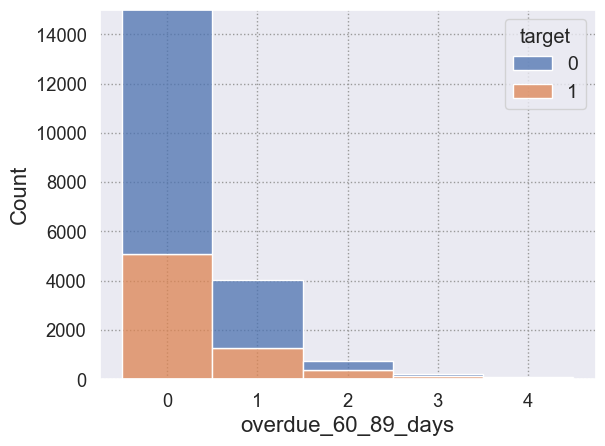

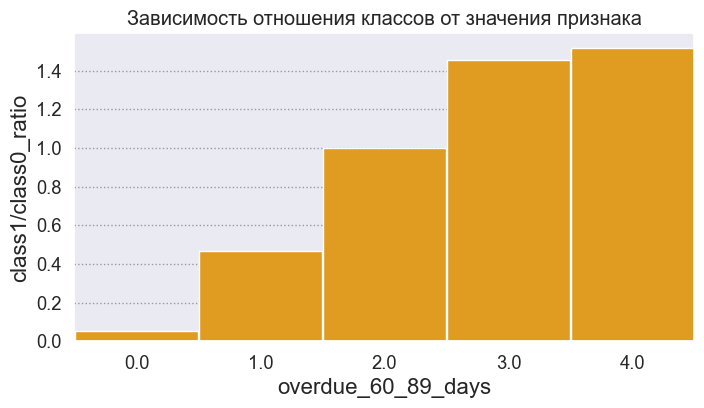

In [26]:
# данные в более крупном масштабе
ax=sns.histplot(data=X_train[X_train.overdue_60_89_days<5].merge(y_train, left_index=True, right_index=True), 
              x='overdue_60_89_days', discrete=True, hue='target', multiple='stack', bins=10)
ax.set_ylim([0, 15000])
plot_class_ratio(ax, 'overdue_60_89_days', bins=10)
plt.show()

#### Мысли:
1. Распределения очень похожи, их медианы равны, а средние значения близки.
2. Имеются выбросы как в `X_train`, так и в `X_test` => не буду их удалять.
3. Соотношение таргетов в зависимости от признака не постоянное => хороший признак

### 1.2.10 family_members

Данные в `family_members` имеют тип float => можно заменить на int

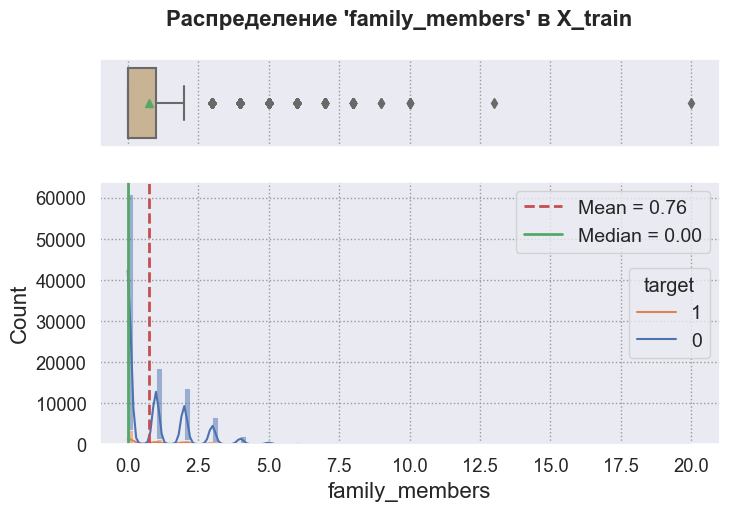

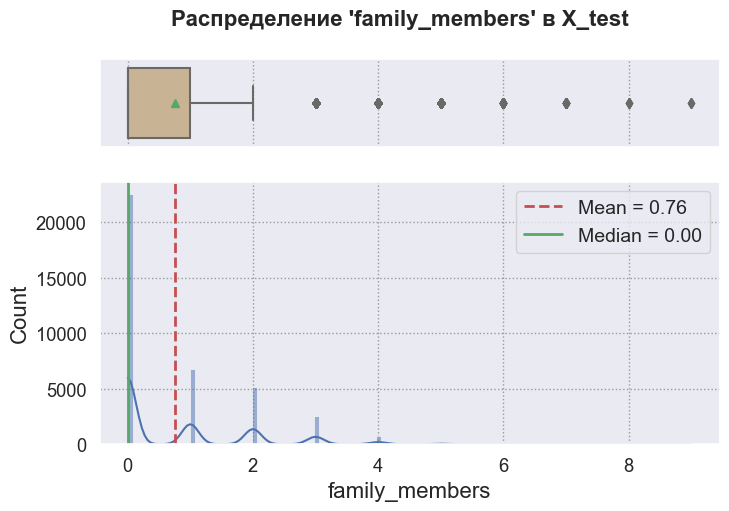

In [27]:
dist_box('family_members', data='train')
dist_box('family_members',  data='test')

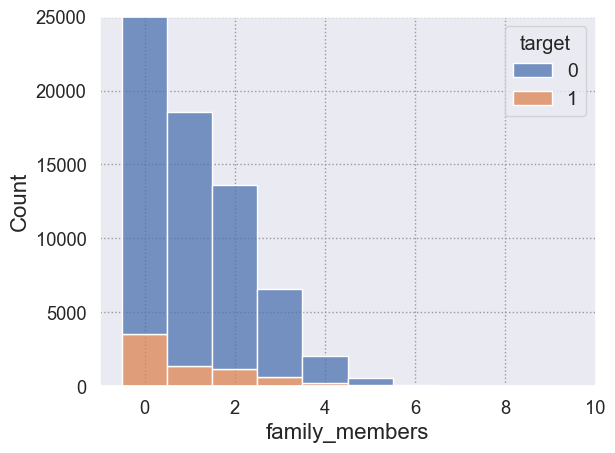

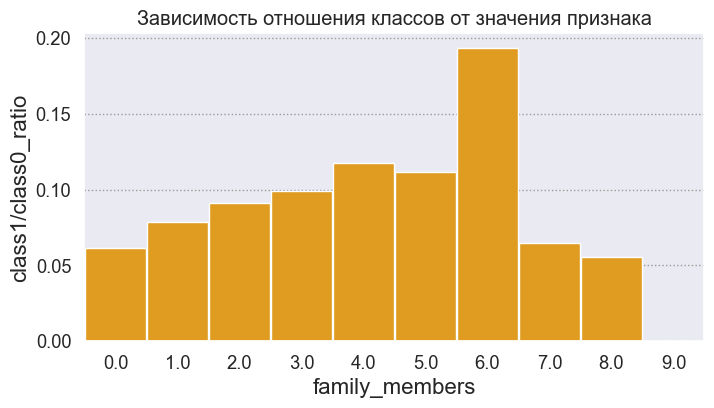

In [28]:
# данные в более крупном масштабе
ax=sns.histplot(data=X_train[X_train.family_members<10].merge(y_train, left_index=True, right_index=True), 
              x='family_members', discrete=True, hue='target', multiple='stack', bins=10)
ax.set_ylim([0, 25000])
plot_class_ratio(ax, 'family_members', bins=10)
plt.show()

#### Мысли:
1. Распределения очень похожи, их медианы и средние равны.
2. Имеются выбросы как в `X_train`, так и в `X_test` => не буду их удалять.
3. Соотношение таргетов в зависимости от признака практически постоянное => слабый признак - претендент на удаление

## 1.3 Анализ корреляций, важности признаков

2 features with a correlation magnitude greater than 0.70.

Training Gradient Boosting Model


0 features with zero or negative importance after one-hot encoding.



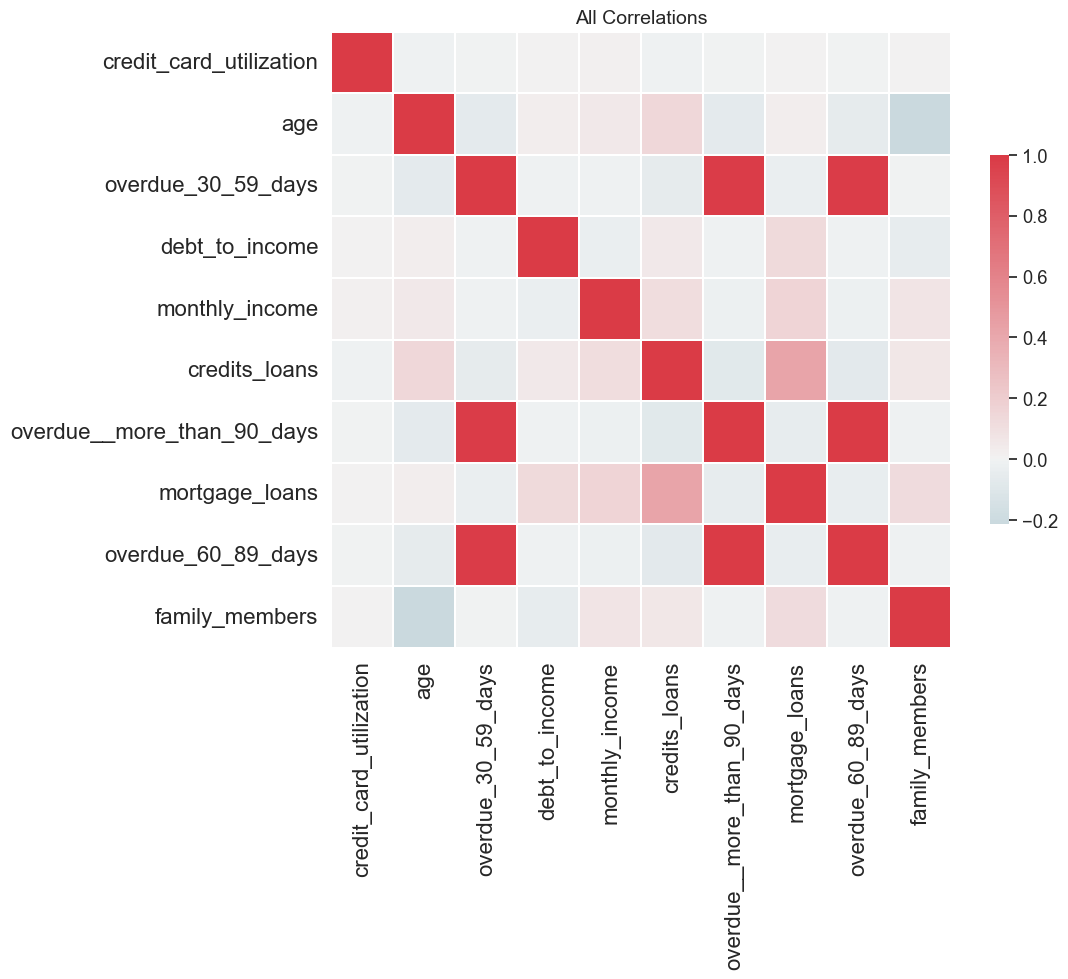

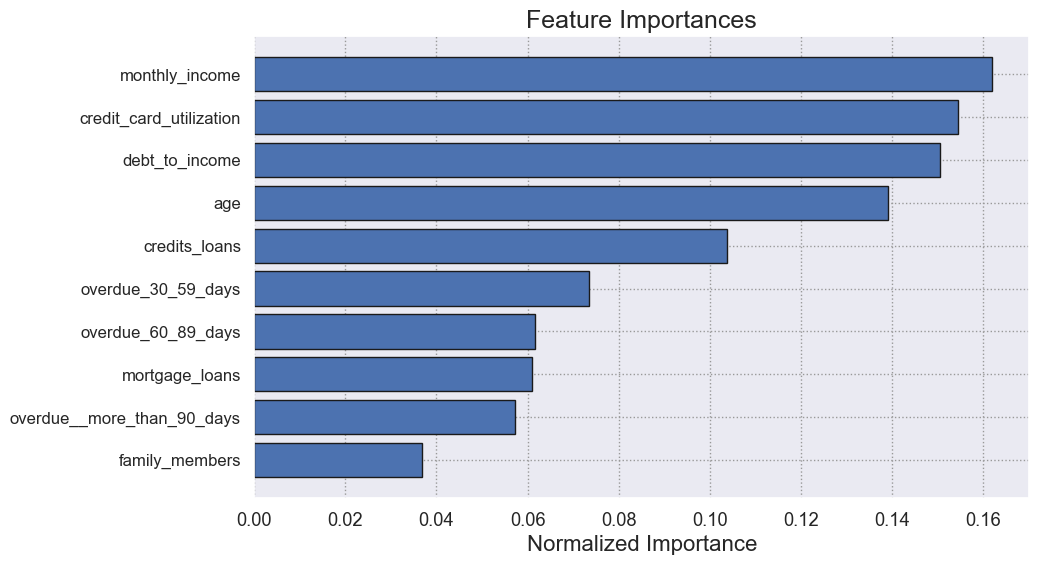

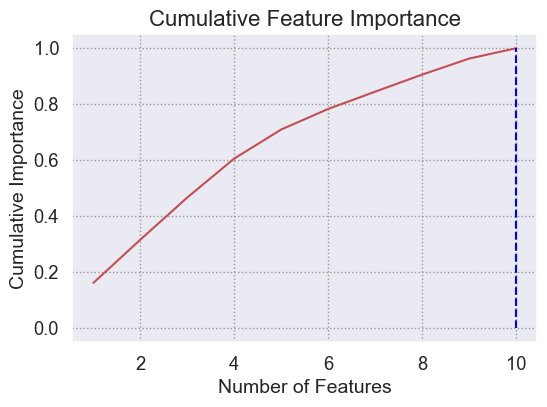

10 features required for 0.99 of cumulative importance
9 features required for cumulative importance of 0.99 after one hot encoding.
1 features do not contribute to cumulative importance of 0.99.




In [29]:
# создание feature selector
fs = FeatureSelector(data = X_train, labels = y_train)

# порог, выше которого парная корреляция считается большой
PAIR_CORRELATION_MAX = 0.7 

'''фичи, парная корреляция между которых очень сильная'''
fs.identify_collinear(correlation_threshold = PAIR_CORRELATION_MAX)
fs.plot_collinear(plot_all=True) 
collinear_features = fs.ops['collinear'] # список таких признаков
fs.record_collinear # подробная информация о сильно коррелирующих признаках

#Проведем пробное обучение модели с помощью LGBM классификатора, чтобы выяснить наименее важные фичи (фичи нулевой важности)
NUM_FEATURES_FOR_PLOT=10
THRESHOLD_IMPORTANCE=0.99

'''фичи нулевой важности'''
fs.identify_zero_importance(task='classification', eval_metric='auc',
                            n_iterations=20)
#task=classification/regression
#eval_metric - метрика для ранней остановки (не нужна, если early_stopping=False)
#n_iterations - количество прогонов обучения для усреднения важности
#early_stopping - включение/отключение ранней остановки

zero_importance_features=fs.ops['zero_importance'] #список таких признаков

'''
Построение графиков: 1ый - самые важные признаки, 
2ой - распределение относительной важности признаков + определение количества
признаков, относительная важность которых больше threshold'''
fs.plot_feature_importances(threshold = THRESHOLD_IMPORTANCE, 
                            plot_n = NUM_FEATURES_FOR_PLOT)

'''
наименее важные признаки, которые не нужны для достижения cumulative_importance от
общей важности признаков (решил не искать их)
'''
fs.identify_low_importance(cumulative_importance = 0.99)
low_importance_features = fs.ops['low_importance']
print()

In [30]:
print('Признаки для удаления вследствие сильных парных корреляций:', collinear_features)
print('Признаки для удаления вследствие малой важности:', zero_importance_features)

Признаки для удаления вследствие сильных парных корреляций: ['overdue__more_than_90_days', 'overdue_60_89_days']
Признаки для удаления вследствие малой важности: []


### Итоги: 
1. Выяснено, что признаки `overdue__more_than_90_days`, `overdue_60_89_days` сильно коррелируют с признаком `overdue_30_59_days`, т.е. число предыдущих просрочек выплат по кредиту от 60 дней сильно связано с числом предыдущих просрочек от 30 до 59 дней (что неудивительно).
2. Признак `monthly_income` является одним из самых важных, несмотря на то, что много пропусков (около 20%)
3. Наименее важный признак - `family_members`, количество членов в семье, однако судя по графику comulative feature importance его следует использовать для обучения модели.

# 2 Обработка признаков: удаление лишних, заполнение пропусков

#### Мысли: 
Стоит попробовать по-разному обработать данные (удалять или не удалять сильно коррелирующиеся признаки, удалять или заполнять пропуски в данных, удалять или оставлять дубликаты), а затем обучить модели, используя различные датасеты. Однако сначала нужно еще раз посмотреть на данные столбцов, где есть пропуски повнимательнее.

In [31]:
print('X_train:')
print('-'*50)
print('Количество пропусков в family_members:', X_train['family_members'].isna().sum())
print('Количество пропусков в monthly_income:', X_train['monthly_income'].isna().sum())
print('Всего объектов:', len(X_train))   
print('*'*50)
print('X_test:')
print('-'*50)
print('Количество пропусков в family_members:', X_test['family_members'].isna().sum())
print('Количество пропусков в monthly_income:', X_test['monthly_income'].isna().sum())
print('Всего объектов:', len(X_test))   

X_train:
--------------------------------------------------
Количество пропусков в family_members: 2805
Количество пропусков в monthly_income: 20993
Всего объектов: 105108
**************************************************
X_test:
--------------------------------------------------
Количество пропусков в family_members: 955
Количество пропусков в monthly_income: 7545
Всего объектов: 38876


#### Анализ family_members

In [32]:
X_train['family_members'].value_counts()

0.0     60844
1.0     18525
2.0     13607
3.0      6595
4.0      2022
5.0       538
6.0       111
7.0        33
8.0        19
10.0        5
9.0         2
13.0        1
20.0        1
Name: family_members, dtype: int64

#### Варианты:

1. Пропуски заменить на медианное=в данном случае наиболее частое значение (0)
2. Удалить признак вообще
3. Признак сделать категориальным: 0 (одиночка), 1(семейная пара), 2-3(1 или 2 детей), 4+ (многодетная семья). А пропуски заполнить либо нулями, либо с помощью какого-нибудь imputer (например knn imputer), либо сделать новым значением признака (например: -1)

#### Варианты для monthly_income:
1. Пропущенные значения заменить на медианные
2. Удалить в X_train все строки с пропусками, а в X_test заменить на медиану
3. Сделать признак категориальным: 
   0-1500, 1500-3000, 3000-7000, 7000-15000, >15000 (5 классов). А пропущенные значения сделать новым классом или с помощью knn imputer попробовать заполнить пропуски.

### Реализация различных способов обработки данных

##### Для каждого способа обработки данных обучаем  простую модель логистической регрессии и смотрим на ее качество

In [33]:
def mean_confidence_interval(data, confidence=0.95):
    '''
    Вычисление среднего значения случайной величины и ее случайной погрешности
    :data: - датафрейм измерений величины
    :confidence: доверительный интервал
    return: m - среднее, h - погрешность'''
    n = len(data)
    m, se = np.mean(data), sem(data)
    h = se * t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [34]:
NUM_FOLDS = 7 # количество фолдов для baseline кросс-валидации

# инициализируем кросс-валидатор с NUM_SPLITS фолдами
skf = StratifiedKFold(n_splits = 7, shuffle = True, random_state = 0)

# baseline модель
def get_baseline_score(X, y, num_folds = NUM_FOLDS, skf=skf):
    '''
    Получение значения roc_auc_score на baseline на данных X и y
    X - датасет признаков, y - таргеты
    return: результаты кросс-валидации
    '''
    # пайплайн для нормировки признаков
    num_pipe = Pipeline([('scaler', StandardScaler())])

    # нормировка признаков
    transformer = ColumnTransformer(
                        transformers=[('num', num_pipe, X.columns)],
                        remainder='passthrough'
    )

    #logistic_pipeline
    baseline = Pipeline([
        ("transformer", transformer), 
        ("model",  LogisticRegression(random_state=0))
    ])
    
    # кросс-валидация
    scores = cross_val_score(estimator=baseline, X=X, y=y, scoring='roc_auc', cv=skf, n_jobs=-1)
    mean, delta = mean_confidence_interval(scores)
    print(f'Среднее значение для {num_folds} фолдов: {mean}')
    print(f'Соответствующая погрешность: {delta}')
    return scores

In [35]:
def drop_all_input_median(X_train=X_train, X_test=X_test, y_train=y_train, how='median'):
    '''
    Получение датасетов без пропущенных значений
    how: del_both/median (del_both - если удалить все пропуски в X_train, 
                          del_members - удалить все строки, где пропуски в family_members, а пропуски в monthly_income = медиана
                          median - замена на медианное значение в обоих столбцах)
    В X_test все пропуски заменяются на медианные значения                      
    '''
    X_train1, X_test1, y_train1 = X_train.copy(deep=True), X_test.copy(deep=True), y_train.copy(deep=True)
    median_members = round(X_train1.family_members.median())
    median_income = X_train1.monthly_income.median()
    
    # заполнение пропущенных значений в X_test
    X_test1['family_members'] = X_test1['family_members'].fillna(median_members)
    X_test1['family_members'] = X_test1['family_members'].astype(int)
    X_test1['monthly_income'] = X_test1['monthly_income'].fillna(median_income)  
    
    if how == 'del_both':  
        X_train1 = X_train1.dropna()
        y_train1 = y_train1[y_train1.index.isin(X_train1.index)]      
    elif how == 'del_members':
        # заполнение пропущенных значений в monthly_income на медианное 
        X_train1['monthly_income'] = X_train1['monthly_income'].fillna(median_income)
        # удаление строк с пропусками в family_members 
        X_train1 = X_train1.dropna()
        y_train1 = y_train1[y_train1.index.isin(X_train1.index)]
    elif how == 'median':  
        # заполнение пропущенных значений в family_members на медианное (равно 0)
        X_train1['family_members'] = X_train1['family_members'].fillna(median_members)
        # заполнение пропущенных значений в monthly_income на медианное 
        X_train1['monthly_income'] = X_train1['monthly_income'].fillna(median_income)
    
    X_train1['family_members'] = X_train1['family_members'].astype(int)
    
    return X_train1, y_train1, X_test1 

## 2.1 Удаление обоих признаков, где есть пропуски

In [36]:
res_both_feat_del = get_baseline_score(X_train.drop(columns=['monthly_income', 'family_members']), 
                                                             y_train)

Среднее значение для 7 фолдов: 0.6951194517184959
Соответствующая погрешность: 0.008871962120336984


## 2.2 Удаление всех строк с пропущенными значениями, в X_test все пропуски -> медиана

In [37]:
X_train_both_del, y_train_both_del, X_test_both_del = drop_all_input_median(how='del_both')
res_both_del = get_baseline_score(X_train_both_del, y_train_both_del)

Среднее значение для 7 фолдов: 0.6906039907496332
Соответствующая погрешность: 0.013502640954845902


## 2.3 Удаление строк с пропусками в family_members, пропуски в monthly_income -> медиана, в X_test все пропуски -> медиана

In [38]:
X_train_del_fam, y_train_del_fam, X_test_del_fam = drop_all_input_median(how='del_members')
res_del_fam = get_baseline_score(X_train_del_fam, y_train_del_fam)

Среднее значение для 7 фолдов: 0.698027300252262
Соответствующая погрешность: 0.008704758844632338


## 2.4 Замена всех пропусков на медианное значение

In [39]:
X_train_median, y_train_median, X_test_median = drop_all_input_median(how='median')
res_median = get_baseline_score(X_train_median, y_train_median)

Среднее значение для 7 фолдов: 0.7001448695867772
Соответствующая погрешность: 0.008353709190516773


 Среди рассмотренных четырех случаев последний показывает наибольшее качество, однако попробуем еще раз его, но с удалением признака family_members.

## 2.5 Замена пропусков в monthly_income на медианное значение, удаление признака family_members

In [40]:
res_del_fam_feat = get_baseline_score(X_train_median.drop(columns=['family_members']), y_train_median)

Среднее значение для 7 фолдов: 0.6988534605496705
Соответствующая погрешность: 0.00876468924898982


Немного, но качество ухудшилось, а также дисперсия увеличилась. Попробуем удалить сильно коррелирующие признаки (`overdue__more_than_90_days`, `overdue_60_89_days`).

## 2.6 Замена пропусков на медианное значение, удаление признаков overdue__more_than_90_days, overdue_60_89_days

In [41]:
res_median_del_corr = get_baseline_score(
    X_train_median.drop(columns=['overdue__more_than_90_days', 'overdue_60_89_days']), y_train_median)

Среднее значение для 7 фолдов: 0.6654011536497093
Соответствующая погрешность: 0.006237595003766099


Несмотря на то, что дисперсия немного уменьшилась, среднее значение roc_auc тоже уменьшилось значительно. Стоит оставить эти признаки в таком случае.

## 2.7 Замена пропусков с помощью KNN Imputer

In [42]:
def get_knn_imputer(num_neighbors, X_input=X_train):
    '''
    Заполнение пропусков в X_input с помощью KNNImputer
    num_neighbors - число соседей алгоритма, X_input - датафрейм для обработки
    return: датафрейм с заполненными пропусками
    '''
    X = X_input.copy(deep=True)
    # нормировка данных, а затем вставляем пропуски
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=num_neighbors))
    ])
    
    # Применяем pipeline к данным
    X_fitted = pipe.fit_transform(X)

    # масштабируем обратно
    X_fitted_inversed = pipe.named_steps['scaler'].inverse_transform(X_fitted)
    X_fitted_inversed_df = pd.DataFrame(X_fitted_inversed, columns=X.columns, index=X.index)
   
    # округление результатов до целого (в family_members очевидно, что не могут быть дробные числа, 
    # а в monthly_income, в принципе, можно было и оставить дробные числа) 
    X_fitted_inversed_df['family_members'] = X_fitted_inversed_df['family_members'].round(0)
    X_fitted_inversed_df['monthly_income'] = X_fitted_inversed_df['monthly_income'].round(0)
    
    return X_fitted_inversed_df

In [43]:
res_knn_imputer = get_baseline_score(get_knn_imputer(10, X_train), y_train)

Среднее значение для 7 фолдов: 0.6985011795660707
Соответствующая погрешность: 0.008425874328532095


Тут стоит позже попробовать поварьировать число соседей.

## 2.8 Разбиение данных для признаков с пропусками на категории

In [44]:
# функции для преобразования столбцов family_members и Monthly_income в категориальные признаки
def family_classes(column, nans='new'):
    '''
    col - столбец, к которому преобразование применяется (family_members)
    nans - new/none/median (new - новый класс, none - оставить без изменений, замена на медиану)
    '''
    col = column.copy(deep=True)
    if nans == 'median':
        return np.nan_to_num(col, nan=0) # медиана равна 0
    
    # 0->0, 1->1, 2-3 -> 2, 4+ ->3
    col[col == 3] = 2
    col[col > 4] = 3
    if nans == 'new':
        col[np.isnan(col)] = -1     
    return col


def income_classes(column, nans='new'):
    '''
    col - столбец, к которому преобразование применяется (monthly_income)
    nans - new/none (new - новый класс, none - оставить без изменений)
    '''
    col = column.copy(deep=True)
    col[(col >= 0) & (col <= 1500)] = 0
    col[(col > 1500) & (col <= 3000)] = 1
    col[(col > 3000) & (col <= 7000)] = 2
    col[(col > 7000) & (col <= 15000)] = 3
    col[col > 15000] = 4
    if nans == 'new':
        col[np.isnan(col)] = -1     
    return col

def get_new_columns(X1, X2, family='none', income='none'):
    '''
    X1 и X2 - train и test датасеты, в которых будет происходить обработка столбцов
    family - что делать с пустыми значениями в столбце family_members: none - ничего, new - новый класс, 
             median - ставим медиану (0)
    income -...- monthly_income (но без медианы)
    return: в том же порядке преобразованные датафреймы
    '''
    X_1, X_2 = X1.copy(deep=True), X2.copy(deep=True)
    X_1['family_members'] = family_classes(X1.family_members, nans=family)
    X_1['monthly_income'] = income_classes(X1.monthly_income, nans=income)
    X_2['family_members'] = family_classes(X2.family_members, nans=family)
    X_2['monthly_income'] = income_classes(X2.monthly_income, nans=income)
    
    return X_1, X_2

### 2.8.1 Пропущенные значения = новый класс

In [45]:
X_train_classes, X_test_classes = get_new_columns(X_train, X_test, family='new', income='new')
# One-Hot кодирование полученных уже категориальных признаков
X_train_classes = pd.get_dummies(X_train_classes, columns=['monthly_income', 'family_members'])
X_train_classes.head()

credit_card_utilization  age  overdue_30_59_days  debt_to_income  \
0                 0.000000   56                   0        0.504328   
1                 0.170659   45                   1        2.405860   
2                 0.342176   75                   1        0.445066   
3                 0.046219   50                   0        0.814508   
4                 0.679556   58                   0        0.390311   

   credits_loans  overdue__more_than_90_days  mortgage_loans  \
0              9                           0               1   
1              5                           0               0   
2              9                           0               3   
3             12                           0               1   
4             15                           0               4   

   overdue_60_89_days  monthly_income_-1.0  monthly_income_0.0  \
0                   0                    0                   0   
1                   0                    0                   1   
2                   0                    0                   0   
3                   0                    0                   0   
4                   0                    0                   0   

   monthly_income_1.0  monthly_income_2.0  monthly_income_3.0  \
0                   0                   1                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   1                   0                   0   
4                   0                   0                   0   

   monthly_income_4.0  family_members_-1.0  family_members_0.0  \
0                   0                    0                   0   
1                   0                    0                   1   
2                   1                    0                   1   
3                   0                    0                   0   
4                   1                    0                   0   

   family_members_1.0  family_members_2.0  family_members_3.0  \
0                   0                   0                   1   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   1                   0   
4                   0                   1                   0   

   family_members_4.0  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0

In [46]:
res_new_class = get_baseline_score(X_train_classes, y_train)

Среднее значение для 7 фолдов: 0.7019480791413212
Соответствующая погрешность: 0.008048543278180727


### 2.8.2 Пропущенные значения заполняются с помощью KNN Imputer

In [47]:
# получаем трансформированные по категориям столбцы, но без заполнения NaN значений
X_train_cats, X_test_cats = get_new_columns(X_train, X_test, family='none', income='none')
X_train_cats.head()

credit_card_utilization  age  overdue_30_59_days  debt_to_income  \
0                 0.000000   56                   0        0.504328   
1                 0.170659   45                   1        2.405860   
2                 0.342176   75                   1        0.445066   
3                 0.046219   50                   0        0.814508   
4                 0.679556   58                   0        0.390311   

   monthly_income  credits_loans  overdue__more_than_90_days  mortgage_loans  \
0             2.0              9                           0               1   
1             0.0              5                           0               0   
2             4.0              9                           0               3   
3             1.0             12                           0               1   
4             4.0             15                           0               4   

   overdue_60_89_days  family_members  
0                   0             3.0  
1                   0             0.0  
2                   0             0.0  
3                   0             2.0  
4                   0             2.0

Далее заполняем пропуски с помощью KNN Imputer и получаем score

In [48]:
# получение X_train_cats с заполненными пропусками
X_train_cats = get_knn_imputer(10, X_train_cats)

# One-Hot кодирование полученных уже категориальных признаков
X_train_cats = pd.get_dummies(X_train_cats, columns=['monthly_income', 'family_members'])
display(X_train_cats.head())

# получение результата на кросс-валидации
res_knn_imputer_with_classes = get_baseline_score(X_train_cats, y_train)

credit_card_utilization   age  overdue_30_59_days  debt_to_income  \
0                 0.000000  56.0                 0.0        0.504328   
1                 0.170659  45.0                 1.0        2.405860   
2                 0.342176  75.0                 1.0        0.445066   
3                 0.046219  50.0                 0.0        0.814508   
4                 0.679556  58.0                 0.0        0.390311   

   credits_loans  overdue__more_than_90_days  mortgage_loans  \
0            9.0                         0.0             1.0   
1            5.0                         0.0             0.0   
2            9.0                         0.0             3.0   
3           12.0                         0.0             1.0   
4           15.0                         0.0             4.0   

   overdue_60_89_days  monthly_income_0.0  monthly_income_1.0  \
0                 0.0                   0                   0   
1                 0.0                   1                   0   
2                 0.0                   0                   0   
3                 0.0                   0                   1   
4                 0.0                   0                   0   

   monthly_income_2.0  monthly_income_3.0  monthly_income_4.0  \
0                   1                   0                   0   
1                   0                   0                   0   
2                   0                   0                   1   
3                   0                   0                   0   
4                   0                   0                   1   

   family_members_0.0  family_members_1.0  family_members_2.0  \
0                   0                   0                   0   
1                   1                   0                   0   
2                   1                   0                   0   
3                   0                   0                   1   
4                   0                   0                   1   

   family_members_3.0  family_members_4.0  
0                   1                   0  
1                   0                   0  
2                   0                   0  
3                   0                   0  
4                   0                   0

Среднее значение для 7 фолдов: 0.7040559782257658
Соответствующая погрешность: 0.007250467714879456


### 2.8.3 KNN Imputer в monthly_income, в family_members - медиана

In [49]:
# получаем трансформированные по категориям столбцы, но без заполнения NaN значений
X_train_cats_median, X_test_cats_median = get_new_columns(X_train, X_test, family='median', income='none')
X_train_cats_median.head()

credit_card_utilization  age  overdue_30_59_days  debt_to_income  \
0                 0.000000   56                   0        0.504328   
1                 0.170659   45                   1        2.405860   
2                 0.342176   75                   1        0.445066   
3                 0.046219   50                   0        0.814508   
4                 0.679556   58                   0        0.390311   

   monthly_income  credits_loans  overdue__more_than_90_days  mortgage_loans  \
0             2.0              9                           0               1   
1             0.0              5                           0               0   
2             4.0              9                           0               3   
3             1.0             12                           0               1   
4             4.0             15                           0               4   

   overdue_60_89_days  family_members  
0                   0             5.0  
1                   0             0.0  
2                   0             0.0  
3                   0             3.0  
4                   0             2.0

В family_members пропуски уже заполнены, осталось применить KNN Imputer с оставшимся пропускам.

In [50]:
# получение X_train_cats_median с заполненными пропусками
X_train_cats_median = get_knn_imputer(10, X_train_cats_median)

# One-Hot кодирование (только monthly_income)
X_train_cats_median = pd.get_dummies(X_train_cats_median, columns=['monthly_income'])
display(X_train_cats_median.head())

# получение результата на кросс-валидации
res_knn_imputer_with_income_classes = get_baseline_score(X_train_cats_median, y_train)

credit_card_utilization   age  overdue_30_59_days  debt_to_income  \
0                 0.000000  56.0                 0.0        0.504328   
1                 0.170659  45.0                 1.0        2.405860   
2                 0.342176  75.0                 1.0        0.445066   
3                 0.046219  50.0                 0.0        0.814508   
4                 0.679556  58.0                 0.0        0.390311   

   credits_loans  overdue__more_than_90_days  mortgage_loans  \
0            9.0                         0.0             1.0   
1            5.0                         0.0             0.0   
2            9.0                         0.0             3.0   
3           12.0                         0.0             1.0   
4           15.0                         0.0             4.0   

   overdue_60_89_days  family_members  monthly_income_0.0  monthly_income_1.0  \
0                 0.0             5.0                   0                   0   
1                 0.0             0.0                   1                   0   
2                 0.0             0.0                   0                   0   
3                 0.0             3.0                   0                   1   
4                 0.0             2.0                   0                   0   

   monthly_income_2.0  monthly_income_3.0  monthly_income_4.0  
0                   1                   0                   0  
1                   0                   0                   0  
2                   0                   0                   1  
3                   0                   0                   0  
4                   0                   0                   1

Среднее значение для 7 фолдов: 0.7039530704273128
Соответствующая погрешность: 0.007289461870186177


## 2.9 Итог: сравнение результатов

Создадим датафрейм с колонками названиями методов, а значения - выход функции cross_val_score для каждого метода

In [51]:
results = pd.DataFrame({'BFD': res_both_feat_del, 'BD': res_both_del, 'DF': res_del_fam, 'RM': res_median, 
                        'DFF': res_del_fam_feat, 'MDC': res_median_del_corr, 'KI': res_knn_imputer, 'NC': res_new_class,
                        'KIWC': res_knn_imputer_with_classes, 'KIWIC': res_knn_imputer_with_income_classes})
results

BFD        BD        DF        RM       DFF       MDC        KI  \
0  0.696507  0.699992  0.696553  0.698486  0.700438  0.661657  0.697469   
1  0.693657  0.700232  0.690487  0.697203  0.695971  0.654630  0.695484   
2  0.707660  0.689174  0.708697  0.711955  0.709176  0.667930  0.711123   
3  0.689462  0.666745  0.696136  0.692209  0.692221  0.659899  0.690491   
4  0.702440  0.702340  0.703193  0.711359  0.708781  0.672315  0.708974   
5  0.677921  0.674194  0.682987  0.688012  0.682617  0.669573  0.686135   
6  0.698189  0.701551  0.708137  0.701791  0.702770  0.671805  0.699833   

         NC      KIWC     KIWIC  
0  0.696297  0.698511  0.700028  
1  0.698655  0.701512  0.701625  
2  0.712563  0.713533  0.713705  
3  0.696780  0.701186  0.701160  
4  0.714107  0.715240  0.714635  
5  0.691025  0.693667  0.692340  
6  0.704210  0.704743  0.704178

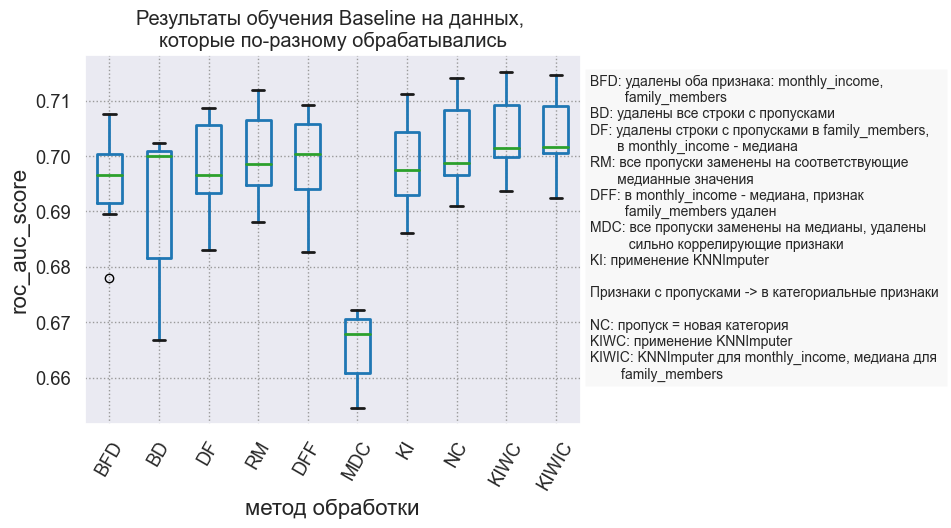

In [52]:
ax = results.boxplot() 
_ = plt.setp(ax.lines, linewidth=2.0)
ax.set(title='Результаты обучения Baseline на данных, \nкоторые по-разному обрабатывались',
       ylabel='roc_auc_score', xlabel='метод обработки')
my_text = f"BFD: удалены оба признака: monthly_income, \n\
         family_members \nBD: удалены все строки с пропусками \n\
DF: удалены строки с пропусками в family_members, \n\
       в monthly_income - медиана \n\
RM: все пропуски заменены на соответствующие \n\
       медианные значения \n\
DFF: в monthly_income - медиана, признак \n\
         family_members удален \n\
MDC: все пропуски заменены на медианы, удалены \n\
          сильно коррелирующие признаки \n\
KI: применение KNNImputer\n\n\
Признаки с пропусками -> в категориальные признаки\n\
\nNC: пропуск = новая категория \n\
KIWC: применение KNNImputer \n\
KIWIC: KNNImputer для monthly_income, медиана для \n\
        family_members"

ax.set_xticks(range(1,11), results.columns.to_list(), rotation=60)
plt.text(10.7, 0.66, my_text, bbox=dict(facecolor='grey', alpha=0.05), fontsize=10)
plt.show()

### Вывод:
В целом, результаты обучения логистической регрессии примерно одинаковые при различных подходах к обработке данных. Единственный важный момент - то, что если удалить признаки с сильной корреляцией, то качество модели станет сильно ниже, хотя и ожидаемо уменьшается дисперсия. Статистический тест показывает, что когда признаки с пропусками трансформируются в категориальные признаки, то достигается лучший результат, чем при использовании других методов обработки. Однако, как потом выяснилось, при использовании бустингов (они будут использоваться ниже) наоборот: качество модели ухудшается. Поэтому было решено в дальнейшем использовать данные, пропуски в которых заполнены KNN Imputer (метод KI). 

### 2.10 Как меняется качество модели при варьировании числа соседей для KNNImputer

In [53]:
# циклом пробегаемся
results_knnimputer = pd.DataFrame()
for num in [1, 2, 3, 5, 10, 15, 20, 50, 100]:
    print(f'При n_neighbors={num}:')
    results_knnimputer[f'{num}'] = get_baseline_score(get_knn_imputer(num, X_train), y_train)

При n_neighbors=1:
Среднее значение для 7 фолдов: 0.6981889090897571
Соответствующая погрешность: 0.008301293084197288
При n_neighbors=2:
Среднее значение для 7 фолдов: 0.69828214956803
Соответствующая погрешность: 0.008322065423912808
При n_neighbors=3:
Среднее значение для 7 фолдов: 0.6982716480358473
Соответствующая погрешность: 0.008308497578846816
При n_neighbors=5:
Среднее значение для 7 фолдов: 0.6983006325350792
Соответствующая погрешность: 0.008319802090770684
При n_neighbors=10:
Среднее значение для 7 фолдов: 0.6985011795660707
Соответствующая погрешность: 0.008425874328532095
При n_neighbors=15:
Среднее значение для 7 фолдов: 0.6986693830189876
Соответствующая погрешность: 0.008326489817982985
При n_neighbors=20:
Среднее значение для 7 фолдов: 0.6987452270823766
Соответствующая погрешность: 0.008326949258843173
При n_neighbors=50:
Среднее значение для 7 фолдов: 0.6989768588200082
Соответствующая погрешность: 0.008254017543782634
При n_neighbors=100:
Среднее значение для 7 фо

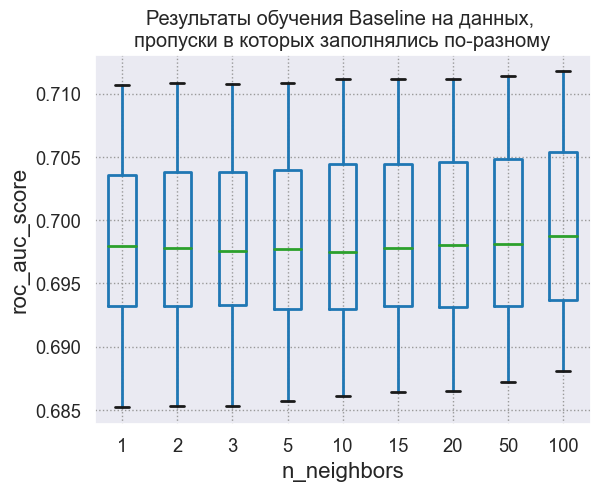

In [54]:
# Результаты обучения модели в зависимости от n_neighbors
ax = results_knnimputer.boxplot() 
_ = plt.setp(ax.lines, linewidth=2.0)
ax.set(title='Результаты обучения Baseline на данных, \nпропуски в которых заполнялись по-разному',
       ylabel='roc_auc_score', xlabel='n_neighbors')
plt.show()

#### Мысли:
1. Результаты примерно одинаковые (отличие в 3-4 знаке после запятой).
2. Таким образом, нет особой разницы сколько именно соседей берется (при n=100 вроде чуть выше качество модели, но изменение настолько мало, что не буду брать такое большое значение, хотя затрачивается очень много вычислительных ресурсов): для дальнейших действий выберу `n_neighbors`=20.

# !! 
Изначально я пропуски просто заменил на медианы и в дальнейшем создавал модели различные для получения высокого score на kaggle. Однако ниже я буду работать с датасетами, в которых пропуски заменяются с помощью KNN Imputer с n_neighbors = 20. Если удастся получить score больше, чем в первом случае, то ок, а если нет, то внизу ноутбука дополнительно попробую воспроизвести лучшую модель, обученную на "тех" данных (с которой удалось на public получить score=0.86484) 

Итак, для всех последующих моделей пропуски в данных будут заполнены с помощью KNN Imputer(n_neighbors = 20) напрямую (предварительно датасеты X_train и X_test будут объединены).

In [55]:
X_test.index = X_test.index + 105109

# на всякий случай сохраню индексы тренировочной и тестовой выборки
X_train_indices = X_train.index.to_list()
X_test_indices = X_test.index.to_list()

# объединение X_train и X_test в X
X = pd.concat([X_train, X_test.drop(columns=['index'])])

# получение X с заполненными пропусками
X = get_knn_imputer(20, X)

# возвращение к X_train и X_test
X_train_final = X.loc[X_train_indices]
X_test_final = X.loc[X_test_indices]

# 3. Простые модели

Рассмотрим несколько различных простых моделей: линейную регрессию, логистическую регрессию, KNN, SGD Classifier, DecisionTree

In [56]:
# масштабирование данных
num_pipe = Pipeline([('scaler', StandardScaler())])
transformer = ColumnTransformer(
                    transformers=[('num', num_pipe, X_train.columns)],
                                   remainder='passthrough')

In [58]:
def get_score_statistic(pipeline, num_splits=5, X=X_train_final, show_stats='True'):
    '''
    Получение результатов обучения пайплайна: 10 раз рассчитывается roc_auc на кросс-валидации
    return: 10*num_splits значений метрики
    '''
    scores = np.array([])
    for i in range(10):
        fold = StratifiedKFold(n_splits = num_splits, shuffle = True, random_state = i)
        scores_on_this_split = cross_val_score(estimator=pipeline, X=X, y=y_train, scoring='roc_auc', 
                                               cv=fold, n_jobs=-1)
        scores = np.append(scores, scores_on_this_split)
    
    if show_stats =='False':
        return scores
    
    print('Среднее:', np.mean(scores))
    print('СКО:', np.std(scores))
    
    return scores

## 3.1 LinearRegression

In [242]:
#linear_pipeline
linear_pipeline = Pipeline([
    ("transformer", transformer), 
    ("model",  LinearRegression())
])

# результаты
linear_res = get_score_statistic(linear_pipeline)

Среднее: 0.6955030232609564
СКО: 0.0075895965208475965


Как и предполагалось, довольно слабый получился результат.

## 3.2 LogisticRegression

In [60]:
#logistic_pipeline
logistic_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",  LogisticRegression(random_state=0, solver='saga', fit_intercept = True, max_iter = 200))
])

# print('\n'.join(logistic_pipeline.get_params().keys()))

Тут есть несколько параметров для настройки: настроим с помощью простого GridSearch (Возможно это первый и последний раз в этом ноутбуке, далее будет использоваться скорее всего hyperopt)

In [61]:
#пространство параметров модели
logistic_space = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100], # величина, обратная силе регуляризации
    'model__penalty': ['l1', 'l2'],   # регуляризация
    'model__class_weight': ['balanced', None] # веса связаны с классами или нет (если нет, то классы имеют одинаковый вес)
}
logistic_clf = GridSearchCV(estimator=logistic_pipeline, param_grid=logistic_space, cv=skf, scoring='roc_auc', verbose=3)

# обучение
logistic_clf.fit(X_train_final, y_train.target) 

# возвращает классификатор с лучшими параметрами
best_logistic_clf=logistic_clf.best_estimator_
# C = 100, 'balanced', 'l2'

Fitting 7 folds for each of 24 candidates, totalling 168 fits
[CV 1/7] END model__C=0.001, model__class_weight=balanced, model__penalty=l1;, score=0.757 total time=   4.8s
[CV 2/7] END model__C=0.001, model__class_weight=balanced, model__penalty=l1;, score=0.758 total time=   4.9s
[CV 3/7] END model__C=0.001, model__class_weight=balanced, model__penalty=l1;, score=0.768 total time=   4.7s
[CV 4/7] END model__C=0.001, model__class_weight=balanced, model__penalty=l1;, score=0.766 total time=   5.1s
[CV 5/7] END model__C=0.001, model__class_weight=balanced, model__penalty=l1;, score=0.760 total time=   3.6s
[CV 6/7] END model__C=0.001, model__class_weight=balanced, model__penalty=l1;, score=0.759 total time=   4.8s
[CV 7/7] END model__C=0.001, model__class_weight=balanced, model__penalty=l1;, score=0.774 total time=   4.4s
[CV 1/7] END model__C=0.001, model__class_weight=balanced, model__penalty=l2;, score=0.756 total time=   2.7s
[CV 2/7] END model__C=0.001, model__class_weight=balanced,

[CV 7/7] END model__C=0.1, model__class_weight=None, model__penalty=l1;, score=0.699 total time=  10.0s
[CV 1/7] END model__C=0.1, model__class_weight=None, model__penalty=l2;, score=0.699 total time=   8.7s
[CV 2/7] END model__C=0.1, model__class_weight=None, model__penalty=l2;, score=0.696 total time=   8.9s
[CV 3/7] END model__C=0.1, model__class_weight=None, model__penalty=l2;, score=0.709 total time=   8.7s
[CV 4/7] END model__C=0.1, model__class_weight=None, model__penalty=l2;, score=0.696 total time=   8.8s
[CV 5/7] END model__C=0.1, model__class_weight=None, model__penalty=l2;, score=0.707 total time=   8.7s
[CV 6/7] END model__C=0.1, model__class_weight=None, model__penalty=l2;, score=0.692 total time=   8.2s
[CV 7/7] END model__C=0.1, model__class_weight=None, model__penalty=l2;, score=0.699 total time=   8.6s
[CV 1/7] END model__C=1, model__class_weight=balanced, model__penalty=l1;, score=0.785 total time=  10.0s
[CV 2/7] END model__C=1, model__class_weight=balanced, model__

[CV 1/7] END model__C=100, model__class_weight=None, model__penalty=l1;, score=0.699 total time=   9.9s
[CV 2/7] END model__C=100, model__class_weight=None, model__penalty=l1;, score=0.696 total time=  10.0s
[CV 3/7] END model__C=100, model__class_weight=None, model__penalty=l1;, score=0.709 total time=   9.9s
[CV 4/7] END model__C=100, model__class_weight=None, model__penalty=l1;, score=0.696 total time=  10.1s
[CV 5/7] END model__C=100, model__class_weight=None, model__penalty=l1;, score=0.707 total time=  10.3s
[CV 6/7] END model__C=100, model__class_weight=None, model__penalty=l1;, score=0.692 total time=  10.2s
[CV 7/7] END model__C=100, model__class_weight=None, model__penalty=l1;, score=0.700 total time=  10.2s
[CV 1/7] END model__C=100, model__class_weight=None, model__penalty=l2;, score=0.699 total time=   8.7s
[CV 2/7] END model__C=100, model__class_weight=None, model__penalty=l2;, score=0.696 total time=   8.7s
[CV 3/7] END model__C=100, model__class_weight=None, model__pena

In [62]:
# все результаты обучения модели
all_results_knn = logistic_clf.cv_results_
'''
занесем в таблицу all_results_knn результаты обучения модели: среднее значение roc_auc и значения гиперпараметров
'''
all_results_knn_df = pd.DataFrame()
all_results_knn_df['mean_auc_score'] = all_results_knn['mean_test_score']      # среднее значение roc_auc_score

# значения гиперпараметров
all_results_knn_df['params'] = all_results_knn['params']
all_results_knn_df['C'] = all_results_knn_df['params'].apply(lambda x: x.get('model__C'))
all_results_knn_df['penalty'] = all_results_knn_df['params'].apply(lambda x: x.get('model__penalty'))
all_results_knn_df['class_weight'] = all_results_knn_df['params'].apply(lambda x: x.get('model__class_weight'))
all_results_knn_df.drop(['params'], axis=1, inplace=True)
all_results_knn_df = all_results_knn_df.fillna('None')
all_results_knn_df.sort_values('mean_auc_score', ascending=False,inplace=True)
all_results_knn_df

mean_auc_score        C penalty class_weight
20        0.791294  100.000      l1     balanced
21        0.791294  100.000      l2     balanced
17        0.791292   10.000      l2     balanced
16        0.791291   10.000      l1     balanced
13        0.791263    1.000      l2     balanced
12        0.791256    1.000      l1     balanced
9         0.790953    0.100      l2     balanced
8         0.790889    0.100      l1     balanced
5         0.787901    0.010      l2     balanced
4         0.787664    0.010      l1     balanced
1         0.764591    0.001      l2     balanced
0         0.763309    0.001      l1     balanced
23        0.699908  100.000      l2         None
22        0.699908  100.000      l1         None
19        0.699905   10.000      l2         None
18        0.699905   10.000      l1         None
15        0.699878    1.000      l2         None
14        0.699874    1.000      l1         None
11        0.699602    0.100      l2         None
10        0.699527    0.100      l1         None
7         0.695616    0.010      l2         None
6         0.690256    0.010      l1         None
3         0.672058    0.001      l2         None
2         0.659498    0.001      l1         None

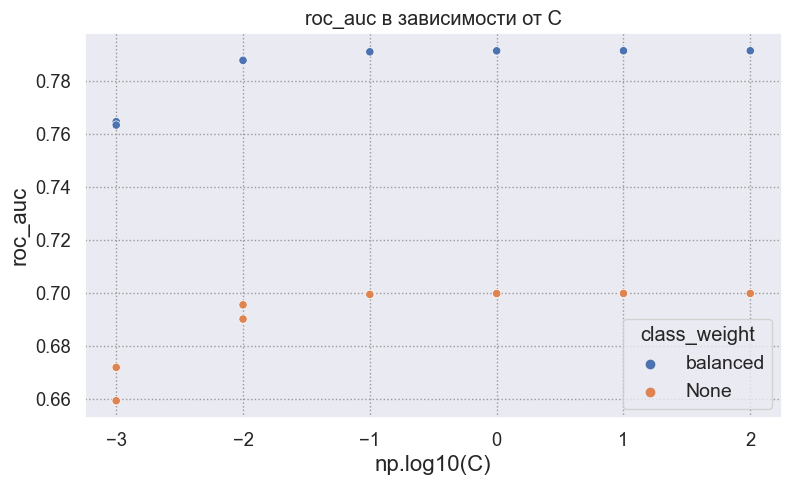

In [251]:
# посмотрим зависимость от числа соседей
fig, ax = plt.subplots(figsize=(9, 5))
sns.scatterplot(data=all_results_knn_df, x=np.log10(all_results_knn_df['C']), y='mean_auc_score', hue='class_weight', ax=ax)
ax.set(xlabel='np.log10(C)', ylabel='roc_auc', title='roc_auc в зависимости от C')
plt.show()

In [63]:
# результаты
logistic_res = get_score_statistic(best_logistic_clf)

Среднее: 0.7913708546628443
СКО: 0.006371687590321608


Результат получился заметно лучше. Очень важным гиперпараметром является `class_weight`: по графику видно, насколько улучшается качество модели, если выставить balanced. Также по таблице с результатами подбора гиперпараметровнаходим, что лучше, когда C больше. Также можно сделать вывод о том, что тип регуляризации практически никак не влияет на значение метрики.

## 3.3 KNN

Для KNN я уже буду пользоваться Hyperopt. Для этого нужно создать функцию objective, а затем функцию для подбора оптимальных гиперпараметров.

In [252]:
def objective(params, pipeline,  X_train, y_train, num_splits=5):
    """
    Кросс-валидация с текущими гиперпараметрами
    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: значение Loss-функции, средняя точность на кросс-валидации, ее погрешн
    """ 

    pipeline.set_params(**params)    # задаём модели требуемые параметры   
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=0) # задаём параметры кросс-валидации 
    scores = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            scoring='roc_auc', cv=skf, n_jobs=-1)       # проводим кросс-валидацию  
    mean_score, std_score = np.mean(scores), np.std(scores)   # среднее и СКО

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -mean_score, 'roc_auc': mean_score, 'std': std_score, 'params': params, 'status': STATUS_OK}


def get_hp_results(pipeline, pipeline_space, max_evals, obj_func=objective, X=X_train_final, y=y_train):
    '''
    Подбор оптимальных гиперпараметров с помощью hyperopt, вывод лучших 5 результатов и оптимальной комбинации гиперпараметров
    pipeline - пайплайн модели, 
    pipeline_space - пространство гиперпараметров, 
    max_evals - число итераций подбора оптимальных гиперпараметров
    return: оптимальные гиперпараметры, история подбора гиперпараметров
    '''
    trials = Trials() # сюда будет сохраняться история поиска
    best = fmin( 
                fn=partial(obj_func, pipeline=pipeline, X_train=X, y_train=y), # функция для оптимизации 
                space=pipeline_space,   # пространство поиска гиперпараметров
                algo=tpe.suggest, # алгоритм поиска (байесовская оптимизация)
                max_evals=max_evals,     # число итераций
                trials=trials,    # куда сохранять историю поиска
                rstate=np.random.default_rng(0), # random state
                show_progressbar=True # progressbar
            )
    
    # результаты в виде датафрейма
    results = pd.DataFrame([{**x, **x['params']} for x in  trials.results])
    results.drop(labels=['status', 'loss'], axis=1, inplace=True)
    results.sort_values(by=['roc_auc'], ascending=False, inplace=True)
    display(results.head())
    
    #оптимальные значения гиперпараметров
    best_params = results.iloc[0]['params'] 
    best_params = {key.replace('model__', ''): value for key, value in best_params.items()}
    
    return best_params, results
    

In [253]:
#knn_pipeline
knn_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",  KNeighborsClassifier(n_jobs=-1))
])

#print('\n'.join(knn_pipeline.get_params().keys()))

#пространство параметров модели
knn_space = {
    'model__n_neighbors': hp.choice('n_neighbors', options=range(2,100,2)),  # число соседей
    'model__metric': hp.choice('metric', options =['minkowski', 'euclidean', 'chebyshev', 'manhattan']), # метрика расстояния
    'model__weights':hp.choice('class_weight', options=['uniform', 'distance']) # веса связаны с классами или нет
}

In [254]:
# подбор оптимальных гиперпараметров и сохранение результатов
best_knn_params, history_knn = get_hp_results(knn_pipeline, knn_space, max_evals=50)

100%|██████████████████████████████████████████████████████████████████████| 50/50 [17:08<00:00, 20.58s/trial, best loss: -0.7770073474289868]


roc_auc       std                                             params  \
34  0.777007  0.006317  {'model__metric': 'manhattan', 'model__n_neigh...   
44  0.777007  0.006317  {'model__metric': 'manhattan', 'model__n_neigh...   
25  0.776671  0.006463  {'model__metric': 'manhattan', 'model__n_neigh...   
26  0.776671  0.006463  {'model__metric': 'manhattan', 'model__n_neigh...   
24  0.776671  0.006463  {'model__metric': 'manhattan', 'model__n_neigh...   

   model__metric  model__n_neighbors model__weights  
34     manhattan                  98       distance  
44     manhattan                  98       distance  
25     manhattan                  96       distance  
26     manhattan                  96       distance  
24     manhattan                  96       distance

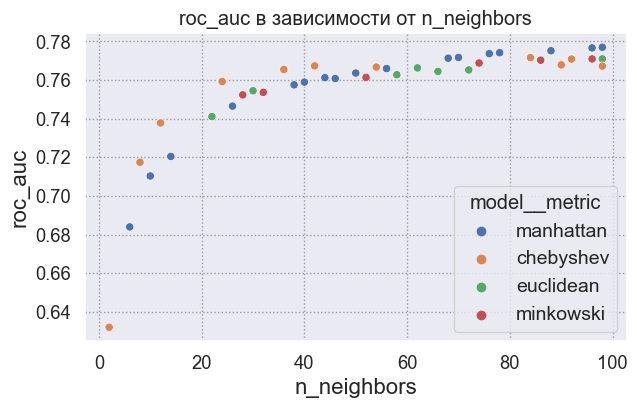

In [255]:
# посмотрим зависимость от числа соседей
fig, ax = plt.subplots(figsize=(7, 4))
sns.scatterplot(data=history_knn, x='model__n_neighbors', y='roc_auc', hue='model__metric', ax=ax)
ax.set(xlabel='n_neighbors', ylabel='roc_auc', title='roc_auc в зависимости от n_neighbors')
plt.show()

Для лучшей модели накопим бОльшую статистику (как и в предыдущих случаях)

In [257]:
best_knn_pipeline =  Pipeline([
    ("transformer", transformer),  
    ("model",  KNeighborsClassifier(n_jobs=-1, **best_knn_params))
])

# результаты
knn_res = get_score_statistic(best_knn_pipeline)

Среднее: 0.7781408374000935
СКО: 0.006339739721797658


Итак, качество модели чуть хуже, чем при использовании логистической регрессии, да и к тому же очень долго происходит "обучение" модели. Основной гиперпараметр KNN - число соседей: обнаруживаем, что с ростом числа соседей качество моделей растет, однако после n_neighbors=80 практически не наблюдается улучшения. Остальные гиперпараметры слабо влияют на качество модели.

## 3.4 SGD Classifier

In [260]:
#sgd_pipeline
sgd_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",  SGDClassifier(n_jobs=-1, random_state=0, class_weight='balanced'))
])

#print('\n'.join(sgd_pipeline.get_params().keys()))

# пространство гиперпараметров
sgd_space={
    'model__loss': hp.choice('loss', options=['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 
                                              'squared_error', 'huber', 'epsilon_insensitive']), # loss-функция
    'model__penalty': hp.choice('penalty', options=[None, 'l1', 'l2', 'elasticnet']), # тип регуляризации
    'model__alpha':  hp.uniform('alpha', 0.0001, 10.0), # коэффициент при регуляризации (чем больше, тем сильнее регуляризация)
#     'model__class_weight': hp.choice('weight', options=[None, 'balanced']),  # веса связаны с классами или нет
    'model__learning_rate': hp.choice('lr', options=['constant', 'optimal', 'invscaling', 'adaptive']), # скорость обучения
    'model__eta0': hp.uniform('eta0', 0.0001, 10.0) # начальная скорость обучения
}


In [261]:
# подбор оптимальных гиперпараметров и сохранение результатов
best_sgd_params, history_sgd = get_hp_results(sgd_pipeline, sgd_space, max_evals=100)

100%|████████████████████████████████████████████████████████████████████| 100/100 [04:21<00:00,  2.62s/trial, best loss: -0.8149439423887834]


roc_auc       std                                             params  \
87  0.814944  0.004442  {'model__alpha': 5.068582882369276, 'model__et...   
3   0.814926  0.004464  {'model__alpha': 4.540042604069614, 'model__et...   
28  0.814900  0.004370  {'model__alpha': 9.231171808502186, 'model__et...   
66  0.814855  0.004380  {'model__alpha': 2.477326926012917, 'model__et...   
69  0.814842  0.004412  {'model__alpha': 2.0625240090559522, 'model__e...   

    model__alpha  model__eta0 model__learning_rate model__loss model__penalty  
87      5.068583     8.525943             adaptive       hinge           None  
3       4.540043     8.964190             adaptive       hinge           None  
28      9.231172     9.966845             adaptive       hinge           None  
66      2.477327     9.927784             adaptive       hinge           None  
69      2.062524     9.746610             adaptive       hinge           None

### !! 
Важно отметить, что в среднем в данном случае быстрее всего происходит подбор гиперпараметров.
Визуализировать полученные результаты достаточно трудно (тут все-таки не подбор параметров по сетке и поэтому какие-то параметры чаще встречаются, а какие-то реже). Поэтому здесь и в последующих экспериментах я просто смотрел на историю подбора гиперпараметров, чтобы понять какие параметры наиболее оптимальны/насколько сильно влияют на метрику. 

In [72]:
# # посмотрим зависимость от числа соседей
# fig, ax = plt.subplots(figsize=(7, 4))
# sns.lineplot(data=history_sgd, x='model__loss', y='roc_auc', ax=ax)
# ax.set(xlabel='loss', ylabel='roc_auc', title='roc_auc в зависимости от loss')
# plt.show()

In [265]:
# Для лучшей модели накопим бОльшую статистику (как и в предыдущих случаях)

best_sgd_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",  SGDClassifier(n_jobs=-1, random_state=0, class_weight='balanced', **best_sgd_params))
])

# результаты
sgd_res = get_score_statistic(best_sgd_pipeline)

Среднее: 0.8152920850198295
СКО: 0.006893588323080173


Roc_auc такой модели больше, чем у логистической регрессии. К тому же обучение и подбор гиперпараметров происходил очень быстро, что приятно.

## 3.5 Decision Tree

In [273]:
#sgd_pipeline
tree_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",  DecisionTreeClassifier(random_state=0, class_weight='balanced'))
])

#print('\n'.join(tree_pipeline.get_params().keys()))

# пространство гиперпараметров
tree_space={
    'model__criterion': hp.choice('criterion', options=['gini', 'entropy', 'log_loss']), # критерий разбиения
    'model__splitter': hp.choice('splitter', options=['best', 'random']), # Стратегия для выбора разделения на каждом узле
    'model__max_depth':  hp.choice('max_depth', options=range(3,30)), # максимальная глубина дерева
    'model__max_features': hp.choice('max_features', 
                                     options=['auto', 'sqrt', 'log2', None]), # Количество признаков для учета при разделении
    'model__min_samples_leaf': hp.choice('leaf', options=[10, 25, 50, 75, 100, 
                                                          150]),  # Мин число образцов, необходимое для нахождения в листе
    'model__ccp_alpha': hp.uniform('ccp_alpha', 0.0, 0.01), # параметр сложности для обрезки дерева
}

In [274]:
# подбор оптимальных гиперпараметров и сохранение результатов
best_tree_params, history_tree = get_hp_results(tree_pipeline, tree_space, max_evals=100)

100%|████████████████████████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/trial, best loss: -0.8523111593203188]


roc_auc       std                                             params  \
23  0.852311  0.004696  {'model__ccp_alpha': 0.0004092377193783943, 'm...   
91  0.851924  0.002830  {'model__ccp_alpha': 0.0007673102704760927, 'm...   
68  0.851854  0.002806  {'model__ccp_alpha': 0.0007776434318880704, 'm...   
67  0.851779  0.003217  {'model__ccp_alpha': 0.000783844218513474, 'mo...   
26  0.850875  0.003696  {'model__ccp_alpha': 0.0008999283537108292, 'm...   

    model__ccp_alpha model__criterion  model__max_depth model__max_features  \
23          0.000409          entropy                19                None   
91          0.000767          entropy                24                None   
68          0.000778          entropy                21                None   
67          0.000784          entropy                19                None   
26          0.000900          entropy                19                None   

    model__min_samples_leaf model__splitter  
23                      150            best  
91                      150            best  
68                      150            best  
67                      150            best  
26                      150            best

### !! 
Обучение происходит очень быстро => можно тщательнее подбирать гиперпараметры. Также видно, что качество модели улучшилось.

In [276]:
# Для лучшей модели накопим бОльшую статистику (как и в предыдущих случаях)

best_tree_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",   DecisionTreeClassifier(random_state=0, **best_tree_params))
])

# результаты
tree_res = get_score_statistic(best_tree_pipeline)

Среднее: 0.847295091648994
СКО: 0.005566245048295881


### 3.6 Задание с кросс-валидацией.
Поэкспериментируем с кросс-валидацией: 
1. Для этой модели проведем анализ, как ведет себя средний скор и доверительный интервал в зависимости от количества фолдов k.
2. Для достаточно большого k проанализируем распределение скоров для оптимального значения гиперпараметра: построим гистограмму и рассчитаем доверительный интервал.

#### 1. Зависимость mean_score и доверительного интервала от числа фолдов

In [277]:
# средние значения и погрешности (95% интервал)

def get_cv_scores(num_splits, pipeline=best_tree_pipeline, confidence=0.95):
    '''
    Получение среднего скора и погрешности для модели в зависимости от числа фолдов
    num_splits - число фолдов
    pipeline - модель, для которой происходят расчеты
    confidence - уровень доверия
    return: среднее, погрешность
    '''
    skf = StratifiedKFold(n_splits = num_splits, shuffle = True, random_state = 0)
    scores = cross_val_score(estimator=pipeline, X=X_train_final, y=y_train, 
                             scoring='roc_auc', cv = skf, n_jobs=-1)
   
    return mean_confidence_interval(scores, confidence=confidence)

In [278]:
means, errors= [], []
min_folds, max_folds, step_folds=3, 30, 1
for k in range(min_folds,max_folds+1, step_folds):
    cur_mean, cur_error = get_cv_scores(k)
    means.append(cur_mean)
    errors.append(cur_error)

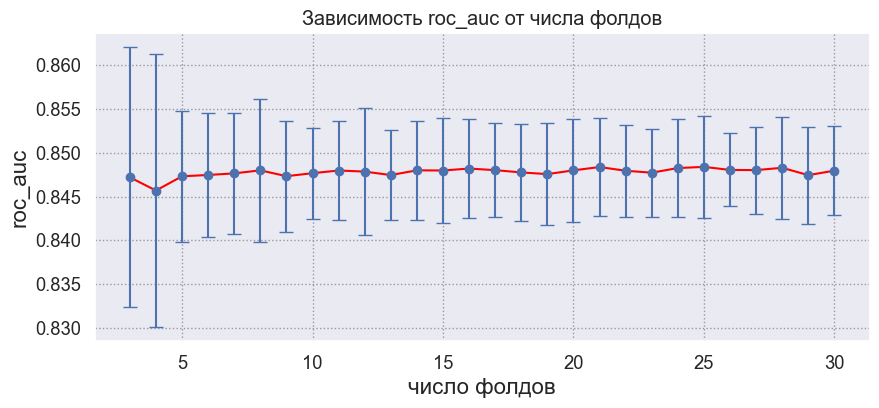

In [279]:
# визуализация
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(range(min_folds,max_folds+1, step_folds), means, color='red')
ax.errorbar(range(min_folds,max_folds+1, step_folds), means, yerr=errors, fmt='o', capsize=5)
ax.set(xlabel='число фолдов', ylabel='roc_auc', title='Зависимость roc_auc от числа фолдов')
plt.show()

#### Вывод:
Видим, что поначалу, при малых значениях числа фолдов, наблюдаются относительно большие доверительные интервалы. Однако, начиная с  k=5 среднее значение практически перестает меняться вместе с доверительным интервалом.

#### 2. Распределение скоров при большом k

In [280]:
# возьмем k = 100
folds_tree_results = get_score_statistic(best_tree_pipeline, 100)

Среднее: 0.8485437069262819
СКО: 0.025213990990854782


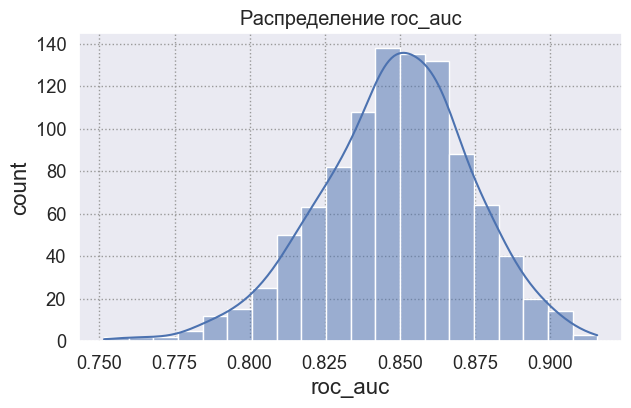

In [281]:
# визуализация
fig, ax = plt.subplots(figsize=(7,4))
ax = sns.histplot(data=folds_tree_results, kde=True,  bins=20)
ax.set(xlabel='roc_auc', ylabel='count', title='Распределение roc_auc')
plt.show()

In [282]:
# подгон параметров распределения Стьюдента под распределение скоров
params_t = t.fit(folds_tree_results)
ALPHA = 0.05  # уровень доверия
t_df, t_mean, t_sigma = params_t

VaR_t = t.ppf(ALPHA, t_df, t_mean, t_sigma)
lower_bound, upper_bound = t.ppf(ALPHA/2, t_df, t_mean, t_sigma), t.ppf(1 - ALPHA/2, t_df, t_mean, t_sigma)

print('Estimated parameters: df={:.0f}, mean={:.4f}, scale={:.4f}'.format(t_df, t_mean, t_sigma))
print('Value-at-Risk: {:.4f}'.format(VaR_t))
print(f'Доверительный интервал для среднего значения метрики: [{lower_bound:.4f}, {upper_bound:.4f}]')

Estimated parameters: df=34, mean=0.8494, scale=0.0244
Value-at-Risk: 0.8081
Доверительный интервал для среднего значения метрики: [0.7998, 0.8990]


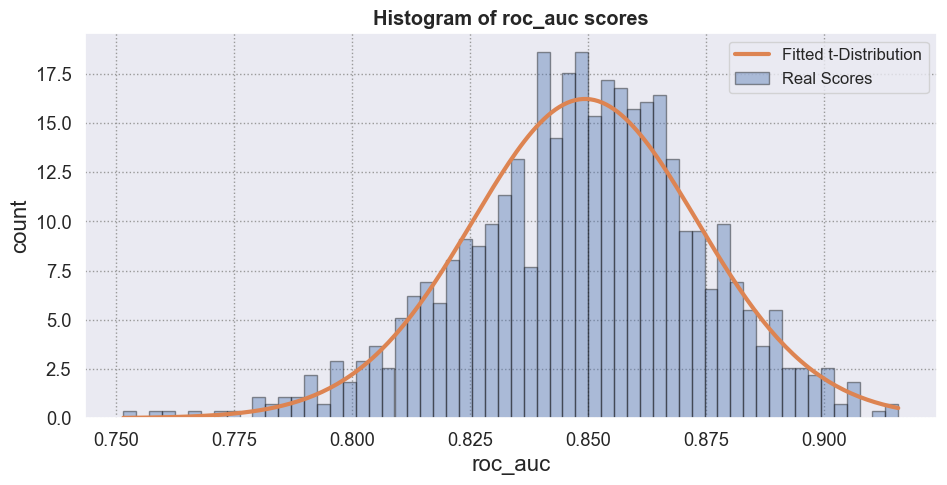

In [283]:
# визуализация подгона распределения скоров 
fig = plt.figure(figsize=(11, 5))
x = np.linspace(folds_tree_results.min(), folds_tree_results.max(), 200)
y_pdf = t.pdf(x, *params_t)

sns.distplot(folds_tree_results, hist=True, kde=False, 
             bins=60, norm_hist=True,
             hist_kws={'edgecolor':'black'})

plt.plot(x, y_pdf, linewidth=3)
plt.title("Histogram of roc_auc scores", weight="bold")
plt.legend(['Fitted t-Distribution', 'Real Scores'], fontsize=12)
plt.xlabel('roc_auc')
plt.ylabel('count')
plt.show()

# 4. Сравнение простых моделей (без линейной)

## 4.1 Визуализация результатов

In [284]:
# Датафрейм с колонками названиями простых моделей, а значения - roc_auc_scores на 10*num_splits фолдах (50 штук в итоге)
simple_models_results = pd.DataFrame({'LogReg': logistic_res, 'KNN': knn_res, 
                             'SGD': sgd_res, 'Tree': tree_res})
simple_models_results.head()

LogReg       KNN       SGD      Tree
0  0.789209  0.766722  0.815991  0.836791
1  0.788528  0.778703  0.806576  0.850761
2  0.791541  0.786455  0.818832  0.851678
3  0.788936  0.775804  0.814855  0.848460
4  0.796962  0.777352  0.818465  0.848862

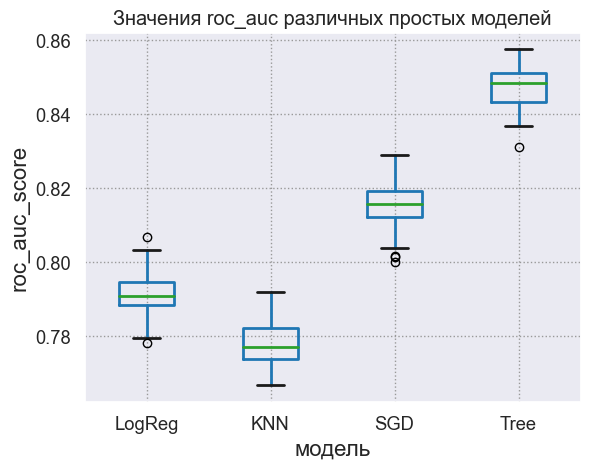

In [285]:
# визуализация результатов 
ax = simple_models_results.boxplot() 
_ = plt.setp(ax.lines, linewidth=2.0)
ax.set(title='Значения roc_auc различных простых моделей',
       ylabel='roc_auc_score', xlabel='модель')
plt.show()

А теперь построим графики других метрик (кросс-валидация: 5 фолдов).

In [286]:
def get_scores_of_pipe(pipeline, scoring, X=X_train_final):
    '''
    Для пайплайна рассчитываются значения метрики на кросс-валидации с 5 (по умолчанию) фолдами
    return: np.array со значениями метрики
    '''
    scores = cross_val_score(estimator=pipeline, X=X, y=y_train, 
                            scoring=scoring, cv=skf, n_jobs=-1)
    
    return scores


def plot_all_scores(metric, model_names=['LogReg', 'KNN', 'SGD', 'Tree'], 
                    models=[best_logistic_clf, best_knn_pipeline, best_sgd_pipeline, best_tree_pipeline], X=X_train_final):
    '''
    Получение датафрейма с результатами расчета метрики (metric) на кросс-валидации с 5 фолдами и последующее
    построение боксплотов
    metric - roc_auc/accuracy/precision/recall/f1
    model_names - названия, которые будут присвоены моделям при построении графиков
    models - используемые модели
    X - на каком датасете обучаются модели
    '''
    temp_dict={}
    for i in range(len(model_names)):
        temp_dict[model_names[i]] = get_scores_of_pipe(models[i], metric, X)
    # получение датафрейма
    results = pd.DataFrame(temp_dict)
    
    # визуализация
    fig, ax = plt.subplots(figsize=(11,6))
    ax = results.boxplot() 
    ax.set(title=f'Значения {metric} для различных моделей',
           ylabel=metric, xlabel='модель')
    _ = plt.setp(ax.lines, linewidth=2.0) 
    plt.show()

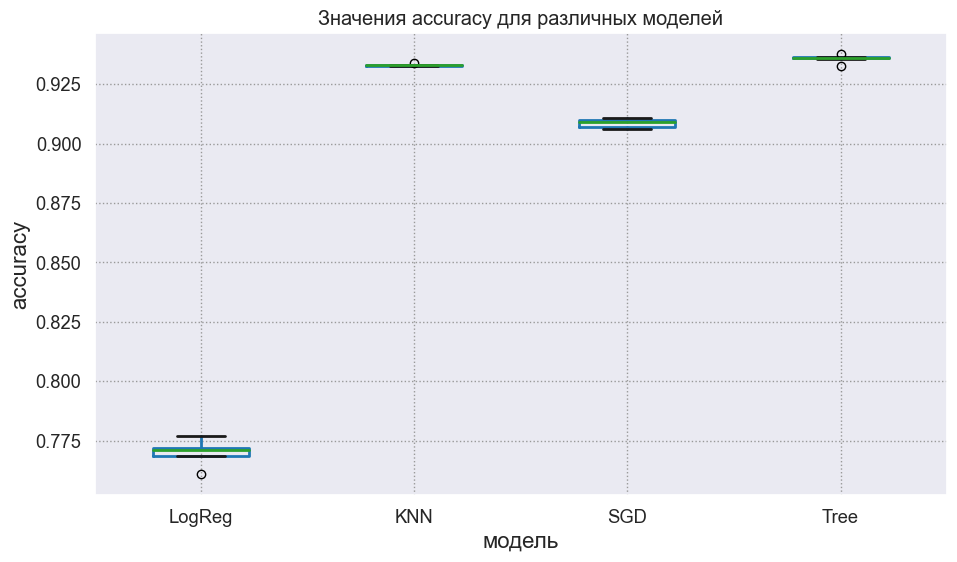

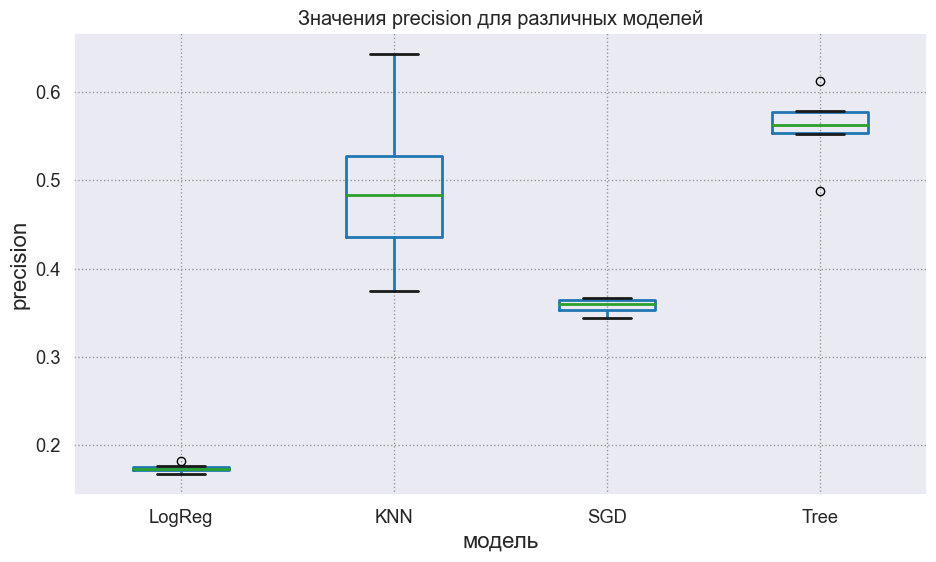

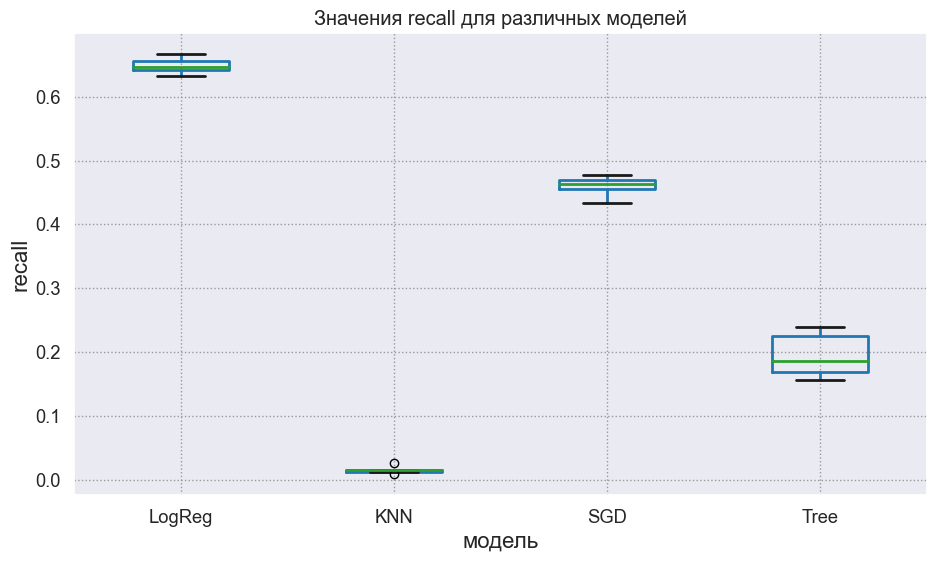

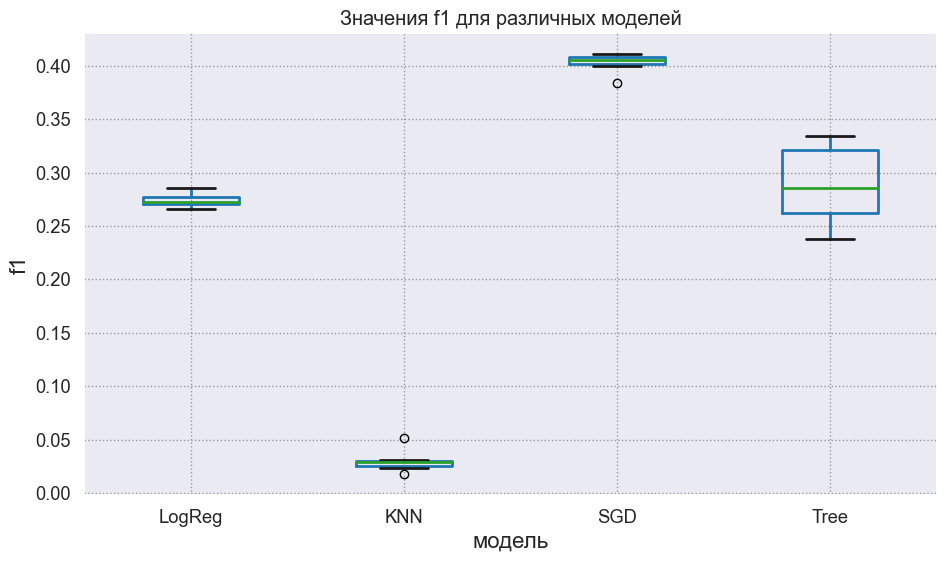

In [287]:
# визуализация
plot_all_scores('accuracy')
plot_all_scores('precision') 
plot_all_scores('recall')
plot_all_scores('f1')

### Выводы:
1. С точки зрения метрики roc_auc наилучшая модель - дерево решений. Далее следует SGD, затем логистическая регрессия и, наконец, KNN.
2. Наибольшее значение precision наблюдается у дерева решений и KNN - чуть больше 0.5 у обоих (но у KNN больше разброс), а у логистической регрессии сильно меньше это значение - почти в 3 раза.
4. С другой стороны у логистической регрессии наблюдается наибольшее значение метрики recall (больше 0.6), в то время как другие алгоритмы демонстрируют меньше 0.2 результат.
5. Что касается среднего гармонического precision и recall, то максимальное значение у SGD.

## 4.2 Попробуем применить SMOTE для решения проблемы дисбаланса классов

Попробуем применить метод SMOTE (искуственное увеличение объектов меньшего класса) и посмотрим, как изменится качество модели.

In [88]:
# попробуем решить проблему дисбаланса классов
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train_final, y_train)
y_resampled.value_counts()

target
0         98077
1         98077
dtype: int64

In [89]:
# подбор оптимальных гиперпараметров и сохранение результатов
best_tree_params_resampled, history_tree_resampled = get_hp_results(tree_pipeline, tree_space, max_evals=100, 
                                                                    X=X_resampled, y=y_resampled)

100%|████████████████████████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/trial, best loss: -0.9816541798466085]


roc_auc       std                                             params  \
27  0.981654  0.000361  {'model__ccp_alpha': 8.426787015726753e-05, 'm...   
68  0.977768  0.000719  {'model__ccp_alpha': 1.7879023635052895e-05, '...   
25  0.977696  0.000671  {'model__ccp_alpha': 3.564242979394629e-05, 'm...   
24  0.975820  0.000705  {'model__ccp_alpha': 0.00014741669855262665, '...   
23  0.975110  0.000782  {'model__ccp_alpha': 0.0001834710937331246, 'm...   

    model__ccp_alpha model__criterion  model__max_depth model__max_features  \
27          0.000084          entropy                19                None   
68          0.000018         log_loss                21                None   
25          0.000036          entropy                19                None   
24          0.000147         log_loss                19                None   
23          0.000183          entropy                19                None   

    model__min_samples_leaf model__splitter  
27                       10            best  
68                      150            best  
25                      150            best  
24                      150            best  
23                      150            best

In [90]:
# Для лучшей модели накопим бОльшую статистику (как и в предыдущих случаях)

best_tree_resampled_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",   DecisionTreeClassifier(random_state=0, **best_tree_params_resampled))
])

# результаты
tree_resampled_res = get_score_statistic(best_tree_resampled_pipeline)

Среднее: 0.8479718797833364
СКО: 0.006119449097381473


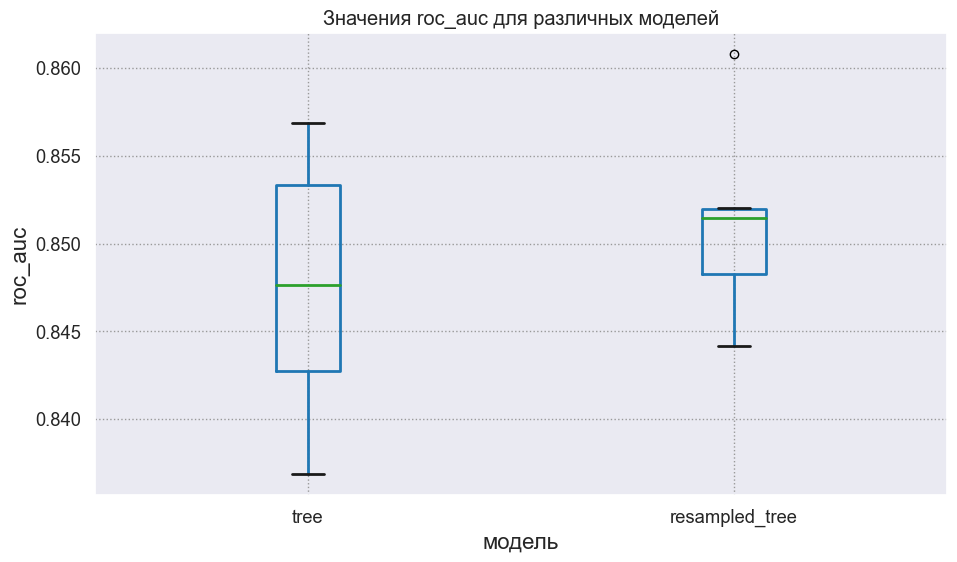

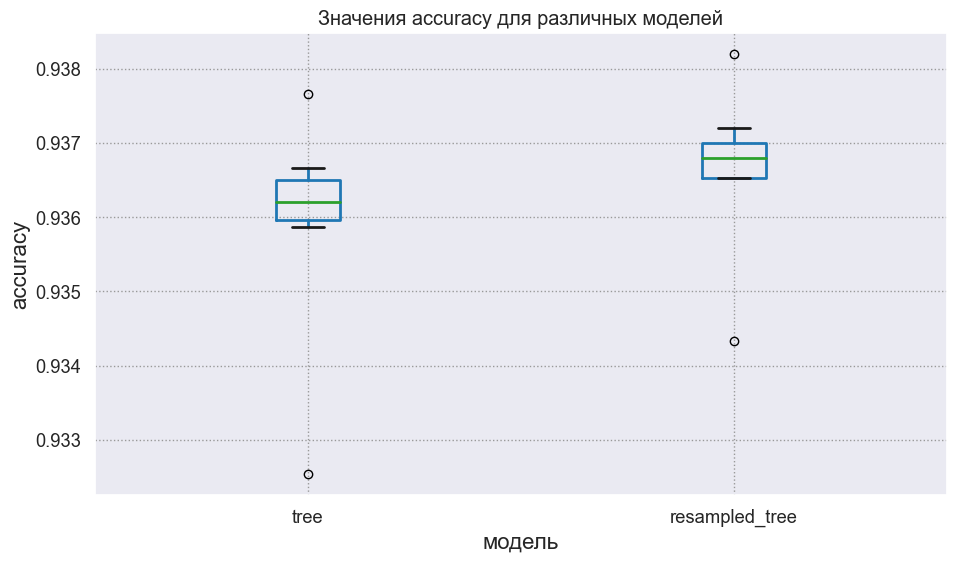

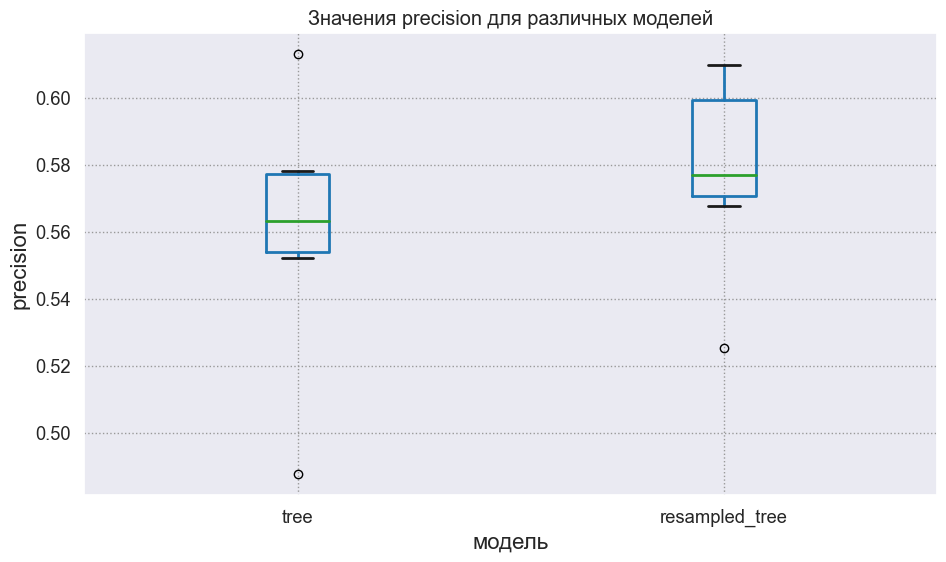

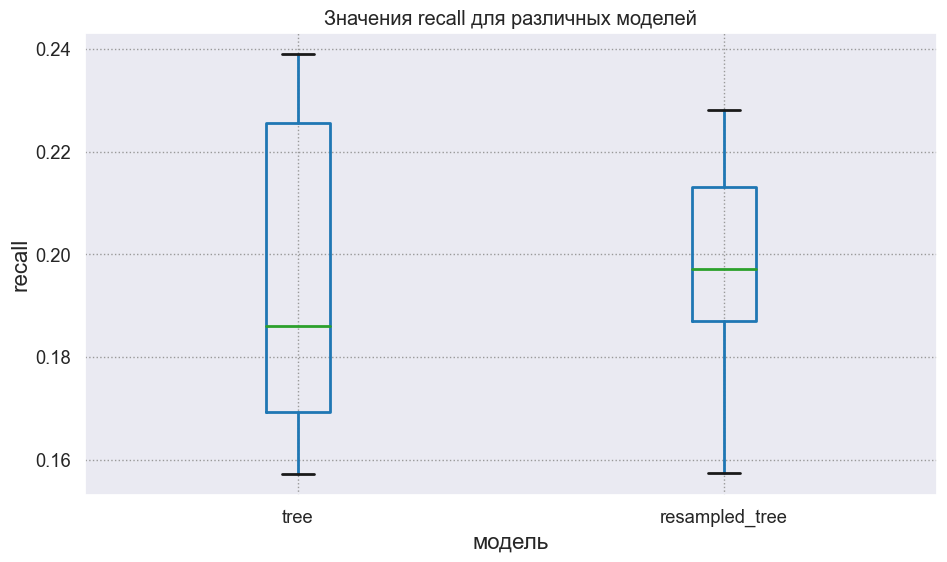

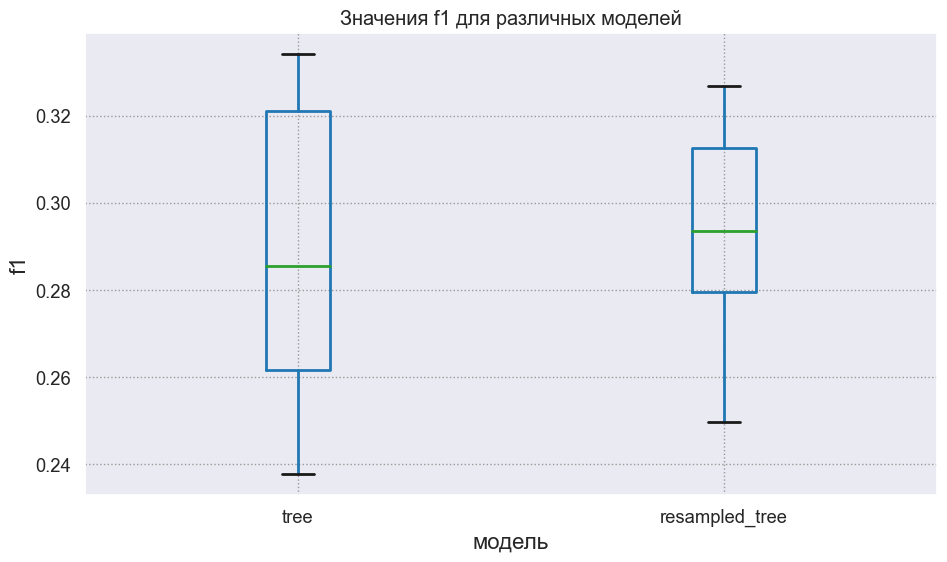

In [288]:
# сравнение со случаем, когда не был применен SMOTE
plot_all_scores('roc_auc', ['tree', 'resampled_tree'], [best_tree_pipeline, best_tree_resampled_pipeline])
plot_all_scores('accuracy', ['tree', 'resampled_tree'], [best_tree_pipeline, best_tree_resampled_pipeline])
plot_all_scores('precision', ['tree', 'resampled_tree'], [best_tree_pipeline, best_tree_resampled_pipeline]) 
plot_all_scores('recall', ['tree', 'resampled_tree'], [best_tree_pipeline, best_tree_resampled_pipeline])
plot_all_scores('f1', ['tree', 'resampled_tree'], [best_tree_pipeline, best_tree_resampled_pipeline])

### Вывод: 
После применения SMOTE немного улучшились все показатели модели accuracy, precision, recall, f1. Однако в дальнейшем решил все-таки обучать модели на `X_train_final`. 

# 5. Ансамбли моделей

Часто буду сначала отдельно подбирать число деревьев/оценщиков и т.д., чтобы не повторять масштабирование данных проведу его отдельно для `X_train`. Однако потом все равно буду делать пайплайны.

In [92]:
# Применяем pipeline к тренировочным данным
X_train_scaled = transformer.fit_transform(X_train_final)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_final.columns, index=X_train_final.index)
X_train_scaled.head()

credit_card_utilization       age  overdue_30_59_days  debt_to_income  \
0                -0.023206  0.180851           -0.100356       -0.193570   
1                -0.022526 -0.561885            0.134870       -0.192529   
2                -0.021843  1.463760            0.134870       -0.193602   
3                -0.023022 -0.224278           -0.100356       -0.193400   
4                -0.020499  0.315894           -0.100356       -0.193632   

   monthly_income  credits_loans  overdue__more_than_90_days  mortgage_loans  \
0        0.101653       0.008435                   -0.063862       -0.016286   
1       -0.536898      -0.763362                   -0.063862       -0.896394   
2        1.437209       0.008435                   -0.063862        1.743930   
3       -0.286395       0.587283                   -0.063862       -0.016286   
4        1.879861       1.166131                   -0.063862        2.624038   

   overdue_60_89_days  family_members  
0           -0.057987        3.845629  
1           -0.057987       -0.670452  
2           -0.057987       -0.670452  
3           -0.057987        2.039197  
4           -0.057987        1.135981

## 5.1 Бэггинг (RandomForest)

In [93]:
# Подбор количества деревьев
max_trees_number = 400
results_forest = []

for current_trees_number in range(5, max_trees_number,20):
    RFC_model = RandomForestClassifier(n_estimators=current_trees_number)
    roc_auc = cross_val_score(RFC_model, X_train_scaled, y_train.target, cv=3, scoring='roc_auc')
    # сохраняем скор
    results_forest.append(roc_auc.mean())  

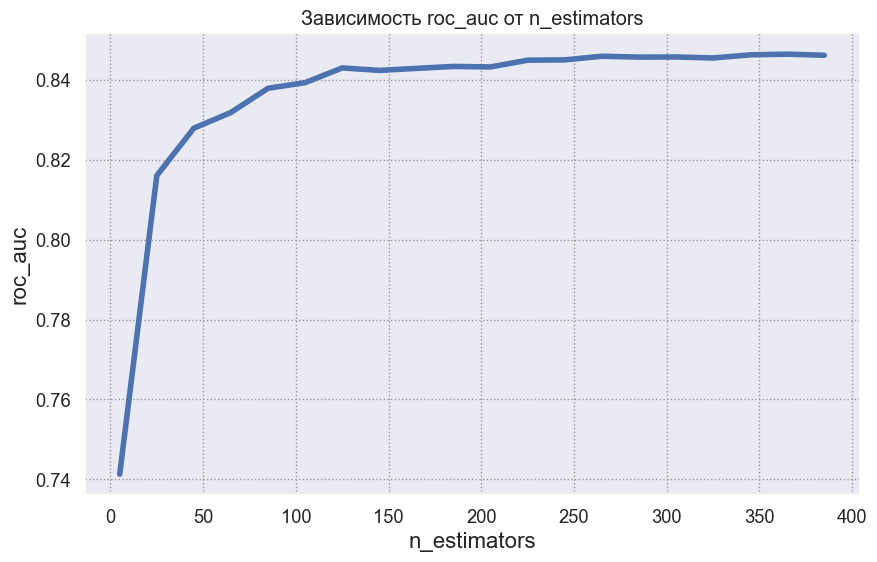

In [94]:
'''посмотрим на график зависимости auc_score от числа деревьев'''
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(ax=ax, y=results_forest, x=range(5, max_trees_number, 20), linewidth=4)
ax.set(xlabel='n_estimators', ylabel='roc_auc', 
            title='Зависимость roc_auc от n_estimators')    
plt.show() 

# далее выставлю число деревьев в лесу 350 (с ростом числа деревьев дальше не увеличивается roc_auc)

In [95]:
# rf_pipeline
rf_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",  RandomForestClassifier(n_estimators=350, n_jobs=-1, random_state=0))
])

# print('\n'.join(rf_pipeline.get_params().keys()))

# пространство гиперпараметров
rf_space={
    'model__criterion': hp.choice('criterion', options=['gini', 'entropy', 'log_loss']), # критерий разбиения
    'model__max_features':  hp.choice('features', 
                                      options=['auto', 'sqrt', 'log2', None]), # Количество признаков для учета при разделении
    'model__max_depth': hp.choice('max_depth', options=range(3,30)),   # максимальная глубина дерева
    'model__min_samples_leaf': hp.choice('min_leaf', options=[10, 25, 50, 75, 100, 
                                                              150]),  # Мин число образцов, необходимое для нахождения в листе
    'model__ccp_alpha': hp.uniform('ccp_alpha', 0.0, 0.01), # параметр сложности для обрезки дерева
    'model__class_weight': hp.choice('weight', options=['balanced', 'balanced_subsample']) # Веса, связанные с классами
}

In [96]:
# подбор оптимальных гиперпараметров и сохранение результатов
best_rf_params, history_rf = get_hp_results(rf_pipeline, rf_space, max_evals=20)

100%|██████████████████████████████████████████████████████████████████████| 20/20 [24:57<00:00, 74.89s/trial, best loss: -0.8570917602255358]


roc_auc       std                                             params  \
9   0.857092  0.003498  {'model__ccp_alpha': 0.0024279868253524674, 'm...   
15  0.856837  0.003579  {'model__ccp_alpha': 0.0026004772174848955, 'm...   
11  0.856274  0.003512  {'model__ccp_alpha': 0.0018860996857154822, 'm...   
3   0.855069  0.003651  {'model__ccp_alpha': 0.004539988003949653, 'mo...   
18  0.855050  0.003169  {'model__ccp_alpha': 0.0017509228889277851, 'm...   

    model__ccp_alpha model__class_weight model__criterion  model__max_depth  \
9           0.002428  balanced_subsample         log_loss                13   
15          0.002600  balanced_subsample          entropy                28   
11          0.001886            balanced             gini                23   
3           0.004540            balanced          entropy                 5   
18          0.001751            balanced         log_loss                23   

   model__max_features  model__min_samples_leaf  
9                 sqrt                       50  
15                log2                       75  
11                log2                       75  
3                 sqrt                      150  
18                None                      150

In [97]:
# Для лучшей модели накопим бОльшую статистику (как и в предыдущих случаях)

best_rf_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",    RandomForestClassifier(n_estimators=350, n_jobs=-1, random_state=0, **best_rf_params))
])

# результаты
rf_res = get_score_statistic(best_rf_pipeline)

Среднее: 0.8571394056888257
СКО: 0.005523791639964044


#### Вывод: 
Если сравнивать с решающим деревом, то среднее значение метрики (из 50 значений) повысилось, а также немного уменьшилось СКО. Немного, конечно, но все-таки...

## 5.2 Бустинги

In [98]:
def compare_with_base(base_pipeline, base_score, min_est, max_est, step_est):
    '''
    Функция для подбора n_estimators модели (расчет t-статистики для связанных выборок, сравнение с моделью с гиперпараметрами
    по умолчанию)
    base_pipeline - модель с параметрами по умолчанию
    base_score - scores модели с параметрами по умолчанию
    min_est, max_est, step_est - min и max число n_estimators, step_est - шаг изменения
    '''
    t_stats = []
    n_est = []
    for j in range(min_est, max_est, step_est):
        cur_pipeline = copy.deepcopy(base_pipeline)
        cur_pipeline.set_params(model__n_estimators=j)
        current_score = get_score_statistic(cur_pipeline, show_stats='False')
        t_stat, p_value = ttest_rel(current_score, base_score)
        t_stats.append(t_stat)
        n_est.append(j)
    plt.plot(n_est, t_stats)
    plt.xlabel('n_estimators')
    plt.ylabel('t-statistic')

### 5.2.1 LGBM Classifier

In [99]:
# подбор n_estimators
max_n_estimators = 200
results_estimators = []

for current_n_estimators in range(5, max_n_estimators, 5):
    LGBM_model = LGBMClassifier(n_estimators=current_n_estimators, random_state=0)
    roc_auc = cross_val_score(LGBM_model, X_train_scaled, y_train.target, cv=3, scoring='roc_auc')
    # сохраняем скор
    results_estimators.append(roc_auc.mean()) 

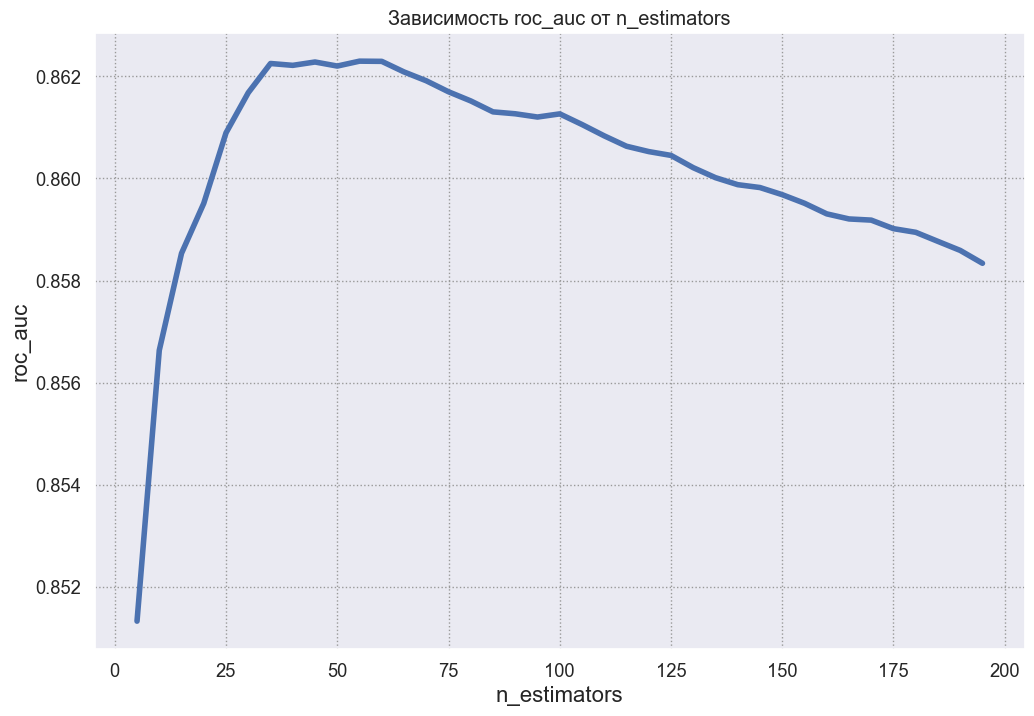

In [100]:
'''посмотрим на график зависимости auc_score от числа деревьев'''
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(ax=ax, y=results_estimators, x=range(5,max_n_estimators, 5), linewidth=4)
ax.set(xlabel='n_estimators', ylabel='roc_auc', 
            title='Зависимость roc_auc от n_estimators')    
plt.show() 

# далее выставлю n_estimators = 50

А теперь сравню это с результатами обучения модели с гиперпараметрами по умолчанию.

In [101]:
# baseline
base_lgbm_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",   LGBMClassifier(random_state=0, n_jobs=-1, class_weight='balanced'))
])

# результаты
base_lgbm_res = get_score_statistic(base_lgbm_pipeline)

Среднее: 0.8619235343640008
СКО: 0.005641853869432248


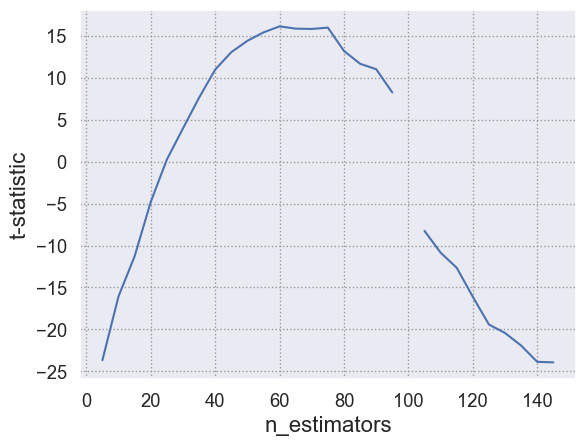

In [102]:
# построение графика t-статистики
compare_with_base(base_lgbm_pipeline, base_lgbm_res, min_est=5, max_est=150, step_est=5)

Далее выставлю n_estimators = 60 (особых нет расхождений между данными графиков roc_auc(n_est) и t-stat(n_est))

In [103]:
LGBM_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",  LGBMClassifier(n_estimators=60, random_state=0, n_jobs=-1, class_weight='balanced'))
]) 

# print('\n'.join(lgbm_pipeline.get_params().keys()))

# пространство гиперпараметров
LGBM_space={
    'model__boosting_type': hp.choice('boosting_type', options=['gbdt','dart']), # тип бустинга
    'model__max_depth': hp.choice('max_depth', options=range(3,30)),  # максимальная глубина деревьев
    'model__min_child_samples': hp.choice('min_leaf', options=[10, 25, 50, 75, 100, 
                                                               150]), # Мин число образцов, необходимое для нахождения в листе
    'model__learning_rate': hp.choice('learning_rate', options=[0.005, 0.01, 0.03, 0.05, 0.1, 0.2, 0.3]), # скорость обучения
#     'model__learning_rate': hp.uniform('learning_rate', 0.0001, 0.3), # скорость обучения
#     'model__class_weight': hp.choice('weight', options=[None, 'balanced']), 
    'model__subsample': hp.choice('subsample', options=[0.6, 0.7, 0.8, 0.9, 1.0]), # доля данных для построения каждого дерева
    'model__reg_alpha': hp.uniform('reg_alpha', 0.0, 100.0), # l1-регуляризация (разреживание весов=> max значимые признаки)
    'model__reg_lambda': hp.uniform('reg_lambda', 0.0, 100.0), # l2-регуляризация (уменьшение весов=> сглаживание модели)
}

In [104]:
# подбор оптимальных гиперпараметров и сохранение результатов
best_LGBM_params, history_LGBM = get_hp_results(LGBM_pipeline, LGBM_space, max_evals=200)

100%|████████████████████████████████████████████████████████████████████| 200/200 [05:16<00:00,  1.58s/trial, best loss: -0.8641664513833938]


roc_auc       std                                             params  \
158  0.864166  0.003864  {'model__boosting_type': 'gbdt', 'model__learn...   
23   0.863939  0.003886  {'model__boosting_type': 'gbdt', 'model__learn...   
155  0.863921  0.003728  {'model__boosting_type': 'gbdt', 'model__learn...   
160  0.863911  0.003715  {'model__boosting_type': 'gbdt', 'model__learn...   
163  0.863884  0.003761  {'model__boosting_type': 'gbdt', 'model__learn...   

    model__boosting_type  model__learning_rate  model__max_depth  \
158                 gbdt                   0.1                 7   
23                  gbdt                   0.1                25   
155                 gbdt                   0.1                 7   
160                 gbdt                   0.1                 7   
163                 gbdt                   0.1                 7   

     model__min_child_samples  model__reg_alpha  model__reg_lambda  \
158                        25         14.023013          19.002211   
23                         25         10.868720          17.750785   
155                        25          8.217147          32.223927   
160                        25         29.046687          18.956571   
163                        25         24.842083          12.667664   

     model__subsample  
158               1.0  
23                1.0  
155               1.0  
160               1.0  
163               1.0

In [105]:
# Для лучшей модели накопим бОльшую статистику (как и в предыдущих случаях)

best_LGBM_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",    LGBMClassifier(n_estimators=60, random_state=0, n_jobs=-1, class_weight='balanced', **best_LGBM_params))
])

# результаты
LGBM_res = get_score_statistic(best_LGBM_pipeline)

Среднее: 0.8641731369263128
СКО: 0.005550575046608114


#### Вывод: 
По сравнению с лесом деревьев среднее значение roc_auc улучшилось почти на 0.01, в то время как СКО примерно осталось таким же. Нужно попробовать и другие бустинги.

### 5.2.2 Catboost Classifier

Когда изучал документацию Catboost, я не нашел возможности сразу поставить "balanced" при class_weights... Ниже попробовал "вручную" веса классов определить. Однако roc_auc_score в таком случае был ниже: настройка class_weights увеличивает только значение precision (до чего, в принципе, можно догадаться). Но т.к. стоит задача по максимизации roc_auc, то далее работаем без этого параметра (однако код для определения классов все же вставил в следующей ячейке).

In [106]:
# найдем веса классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train.target)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.535844285612325, 1: 7.474612430664202}

In [107]:
# подбор n_estimators
max_n_estimators_cb = 300
results_estimators_cb = []

for current_n_estimators_cb in range(5, max_n_estimators_cb, 10):
    catboost_model = CatBoostClassifier(n_estimators=current_n_estimators_cb, random_state=0, 
                                        silent=True) # class_weights=class_weights
    roc_auc = cross_val_score(catboost_model, X_train_scaled, y_train.target, cv=5, scoring='roc_auc')
    # сохраняем скор
    results_estimators_cb.append(roc_auc.mean()) 

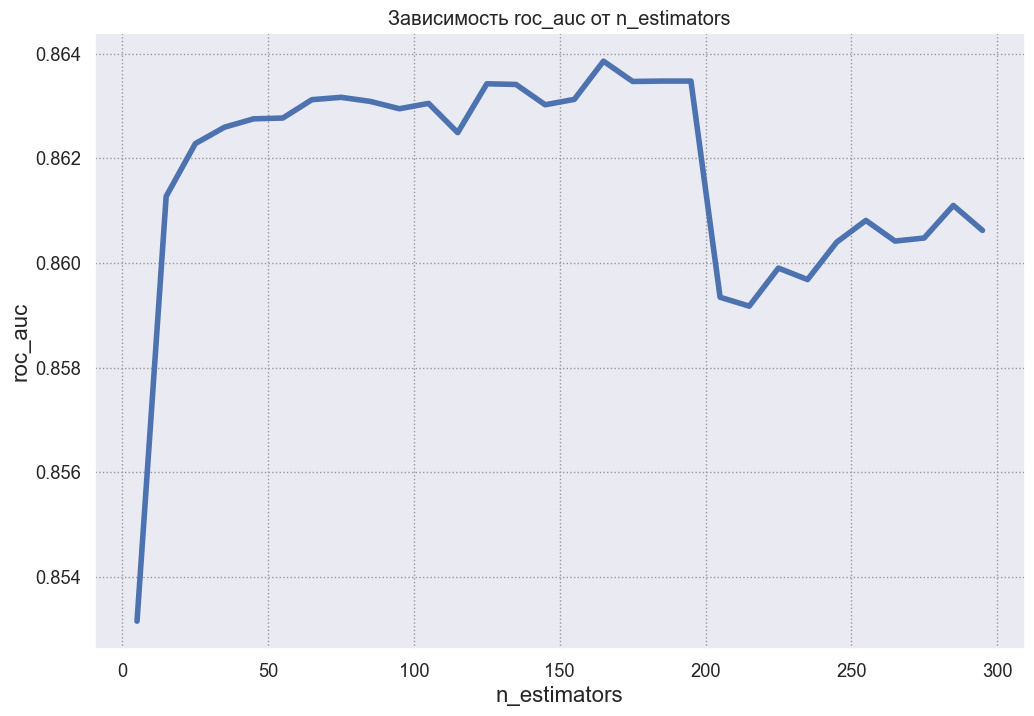

In [108]:
'''посмотрим на график зависимости auc_score от числа оценщиков'''
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(ax=ax, y=results_estimators_cb, x=range(5,max_n_estimators_cb, 10), linewidth=4)
ax.set(xlabel='n_estimators', ylabel='roc_auc', 
            title='Зависимость roc_auc от n_estimators')    
plt.show() 

А теперь сравню это с результатами обучения модели с гиперпараметрами по умолчанию.

In [109]:
# baseline
base_catboost_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",   CatBoostClassifier(random_state=0, silent=True))
])

# результаты
base_catboost_res = get_score_statistic(base_catboost_pipeline)

Среднее: 0.8620051606533883
СКО: 0.005532299876683149


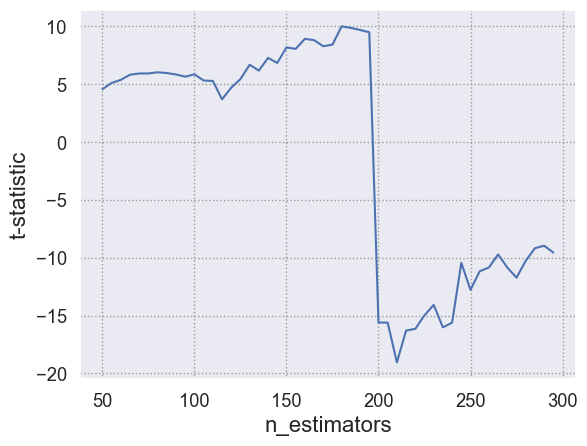

In [110]:
# построение графика t-статистики
compare_with_base(base_catboost_pipeline, base_catboost_res, min_est=50, max_est=300, step_est=5)

Изначально я выставил n_estimators = 165 (посчитал, что опасно выставлять значение в районе 185, т.к. чуть правее уже резкий скачок вниз), для этого случая получил на 50 фолдах:

Среднее: 0.8648013923389664,   СКО: 0.005458740196577406

Однако потом решил попробовать зафиксировать 185 и получил результат похуже:

Среднее: 0.8644606612137524,  СКО: 0.005411891026130574.

Поэтому ниже берется n_estimators=165.

In [111]:
catboost_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",  CatBoostClassifier(n_estimators=165, random_state=0, silent=True)) # class_weights=class_weights
]) 

# print('\n'.join(catboost_pipeline.get_params().keys()))

# пространство гиперпараметров
catboost_space={
    'model__learning_rate': hp.choice('learning_rate', options=[0.005, 0.01, 0.03, 0.05, 0.1, 0.2, 0.3]), # скорость обучения
#     'model__learning_rate': hp.uniform('learning_rate', 0.001, 0.3), # скорость обучения
    'model__max_depth': hp.choice('max_depth', options=range(3, 17)),  # максимальная глубина деревьев
    'model__min_child_samples': hp.choice('min_leaf', options=[10, 25, 50, 75, 
                                                               150]), # Мин число образцов, необходимое для нахождения в листе
    'model__subsample': hp.choice('subsample', options=[0.6, 0.7, 0.8, 0.9, 1.0]), # доля данных для построения каждого дерева
    'model__reg_lambda': hp.uniform('reg_lambda', 0.0, 100.0), # l2-регуляризация (уменьшение весов=> сглаживание модели)
    'model__grow_policy': hp.choice('grow_policy', options=['SymmetricTree', 'Depthwise', 
                                                            'Lossguide']) # стратегия выращивания деревьев
}

In [112]:
# подбор оптимальных гиперпараметров и сохранение результатов
best_catboost_params, history_catboost = get_hp_results(catboost_pipeline, catboost_space, max_evals=200)

100%|████████████████████████████████████████████████████████████████████| 200/200 [55:13<00:00, 16.57s/trial, best loss: -0.8648714594673018]


roc_auc       std                                             params  \
146  0.864871  0.003827  {'model__grow_policy': 'Depthwise', 'model__le...   
35   0.864802  0.003754  {'model__grow_policy': 'Depthwise', 'model__le...   
185  0.864726  0.003575  {'model__grow_policy': 'Depthwise', 'model__le...   
88   0.864716  0.004077  {'model__grow_policy': 'Depthwise', 'model__le...   
187  0.864702  0.003487  {'model__grow_policy': 'Depthwise', 'model__le...   

    model__grow_policy  model__learning_rate  model__max_depth  \
146          Depthwise                   0.1                13   
35           Depthwise                   0.1                12   
185          Depthwise                   0.1                11   
88           Depthwise                   0.1                15   
187          Depthwise                   0.1                11   

     model__min_child_samples  model__reg_lambda  model__subsample  
146                       150          96.062198               1.0  
35                        150          76.682340               0.7  
185                       150          37.860548               1.0  
88                        150          79.931868               0.7  
187                        75          23.950856               1.0

In [113]:
# Для лучшей модели накопим бОльшую статистику (как и в предыдущих случаях)

best_catboost_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",   CatBoostClassifier(n_estimators=165, random_state=0, silent=True, **best_catboost_params))
])

# результаты
catboost_res = get_score_statistic(best_catboost_pipeline)

Среднее: 0.8648013923389664
СКО: 0.005458740196577406


### 5.2.3 XGBoost

В данном случае также пробовал сбалансировать классы (`scale_pos_weight`), однако как и в предыдущем случае score был ниже (опять же это приводит лишь к увеличению precision модели: эти результаты не стал сохранять в ноутбуке).

In [114]:
# подбор n_estimators
max_n_estimators_xg = 50
results_estimators_xg = []
scale_pos_weight = len(y_train)/sum(y_train.target) - 1

for current_n_estimators_xg in range(5, max_n_estimators_xg, 1):
    xg_model = XGBClassifier(n_estimators=current_n_estimators_xg, random_state=0) # scale_pos_weight=scale_pos_weight
    roc_auc = cross_val_score(xg_model, X_train_scaled, y_train.target, cv=3, scoring='roc_auc')
    # сохраняем скор
    results_estimators_xg.append(roc_auc.mean()) 

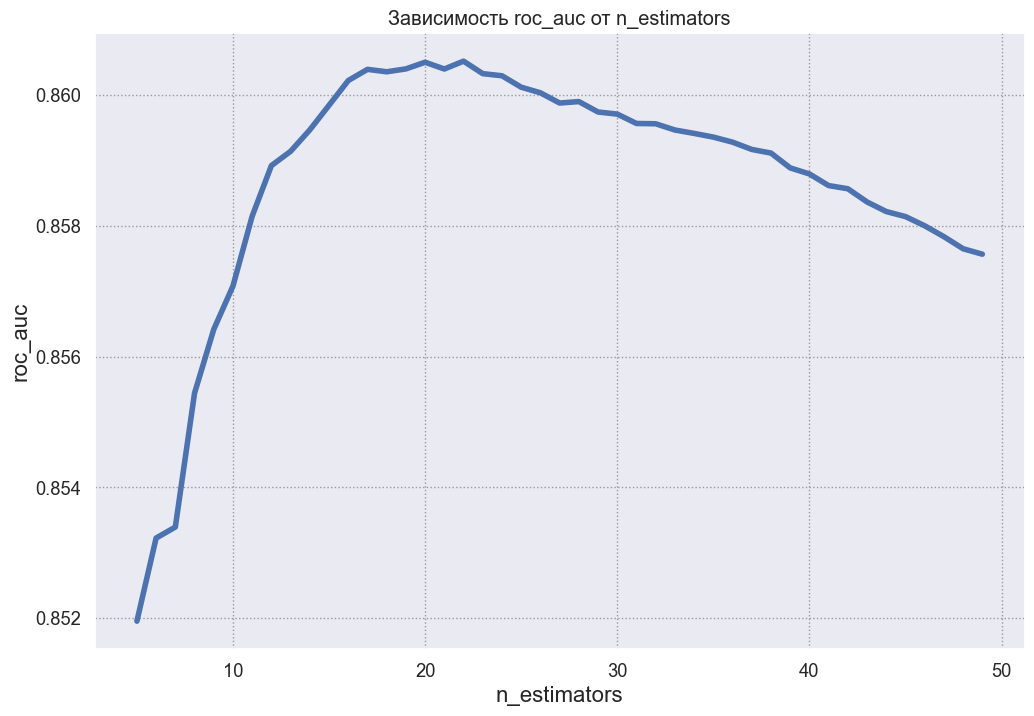

In [115]:
'''посмотрим на график зависимости auc_score от числа оценщиков'''
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(ax=ax, y=results_estimators_xg, x=range(5,max_n_estimators_xg, 1), linewidth=4)
ax.set(xlabel='n_estimators', ylabel='roc_auc', 
            title='Зависимость roc_auc от n_estimators')    
plt.show() 

А теперь сравню это с результатами обучения модели с гиперпараметрами по умолчанию.

In [116]:
# baseline
base_xg_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",   XGBClassifier(random_state=0))
])

# результаты
base_xg_res = get_score_statistic(base_xg_pipeline)

Среднее: 0.8540025763728011
СКО: 0.005523531382104776


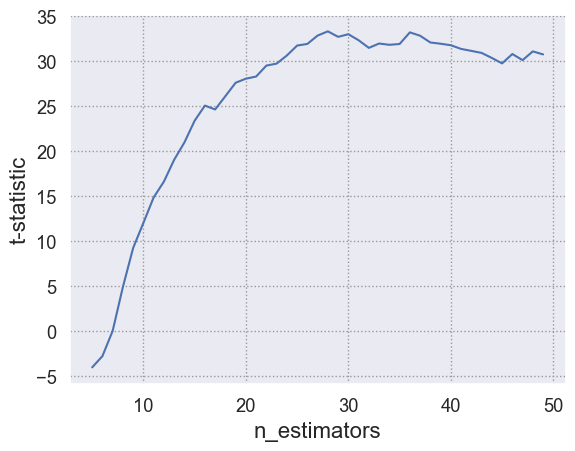

In [117]:
# построение графика t-статистики
compare_with_base(base_xg_pipeline, base_xg_res, min_est=5, max_est=50, step_est=1)

Тут стоит больше доверять графику зависимости t-статистики от n_estimators (т.к. больше данных накоплено: 50 против 5). Выберу n_estimators=28.

In [118]:
xg_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",  XGBClassifier(n_estimators=28, random_state=0)) # scale_pos_weight=scale_pos_weight
]) 

# print('\n'.join(xg_pipeline.get_params().keys()))

# пространство гиперпараметров
xg_space={
    'model__booster': hp.choice('booster', options=['gbtree','gblinear','dart']), # тип бустинга
#     'model__learning_rate': hp.uniform('learning_rate', 0.0001, 0.3), # скорость обучения
    'model__learning_rate': hp.choice('learning_rate', options=[0.005, 0.01, 0.03, 0.05, 0.1, 0.2, 0.3]), # скорость обучения
    'model__max_depth': hp.choice('max_depth', options=range(3, 30)), # максимальная глубина деревьев
    'model__gamma': hp.uniform('gamma', 0, 100.0), # регуляризация модели путем ограничения глубины дерева 
                                       #(min значение уменьшения ф-ции потерь для продолжения разбиения на каждом узле дерева)
    'model__subsample': hp.choice('subsample', options=[0.6, 0.7, 0.8, 0.9, 1.0]), # доля данных для построения каждого дерева
    'model__reg_lambda': hp.uniform('reg_lambda', 0.0, 100.0),  # l2-регуляризация (уменьшение весов=> сглаживание модели)
    'model__reg_alpha': hp.uniform('reg_alpha', 0.0, 100.0),  # l1-регуляризация (разреживание весов=> max значимые признаки)
    'model__max_delta_step': hp.uniform('max_delta_step', 1.0, 
                                        10.0), # max изменение весов при обновлении дерева на каждой итерации бустинга
    'model__grow_policy': hp.choice('grow_policy', options=['depthwise', 'lossguide']) # стратегия выращивания деревьев
}

In [119]:
# подбор оптимальных гиперпараметров и сохранение результатов
best_xg_params, history_xg = get_hp_results(xg_pipeline, xg_space, max_evals=200)

100%|████████████████████████████████████████████████████████████████████| 200/200 [23:17<00:00,  6.99s/trial, best loss: -0.8635841296049218]


roc_auc       std                                             params  \
181  0.863584  0.003488  {'model__booster': 'dart', 'model__gamma': 5.4...   
151  0.863531  0.003617  {'model__booster': 'dart', 'model__gamma': 1.5...   
175  0.863312  0.003942  {'model__booster': 'dart', 'model__gamma': 3.4...   
194  0.863302  0.003810  {'model__booster': 'dart', 'model__gamma': 3.6...   
103  0.863253  0.003565  {'model__booster': 'dart', 'model__gamma': 4.4...   

    model__booster  model__gamma model__grow_policy  model__learning_rate  \
181           dart      5.404090          lossguide                   0.3   
151           dart      1.554556          lossguide                   0.3   
175           dart      3.448829          lossguide                   0.3   
194           dart      3.686986          lossguide                   0.2   
103           dart      4.462475          lossguide                   0.3   

     model__max_delta_step  model__max_depth  model__reg_alpha  \
181               9.478560                10          7.275558   
151               9.861437                 7         11.090442   
175               9.153173                13          6.483674   
194               8.307624                10          4.982146   
103               8.318030                 6         17.038501   

     model__reg_lambda  model__subsample  
181          18.261175               0.8  
151          67.039555               1.0  
175          34.399026               0.8  
194          13.306722               0.8  
103          71.143927               0.6

In [120]:
# Для лучшей модели накопим бОльшую статистику (как и в предыдущих случаях)

best_xg_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",   XGBClassifier(n_estimators=28, random_state=0, **best_xg_params)) # scale_pos_weight=scale_pos_weight
])

# результаты
xg_res = get_score_statistic(best_xg_pipeline)

Среднее: 0.8635424764393452
СКО: 0.00566950546254752


### 5.2.4 GradientBoostingClassifier

In [121]:
# подбор n_estimators
max_n_estimators_gbc = 200
results_estimators_gbc = []

for current_n_estimators_gbc in range(5, max_n_estimators_gbc, 10):
    gbc_model = GradientBoostingClassifier(n_estimators=current_n_estimators_gbc, random_state=0)
    roc_auc = cross_val_score(gbc_model, X_train_scaled, y_train.target, cv=3, scoring='roc_auc')
    # сохраняем скор
    results_estimators_gbc.append(roc_auc.mean())

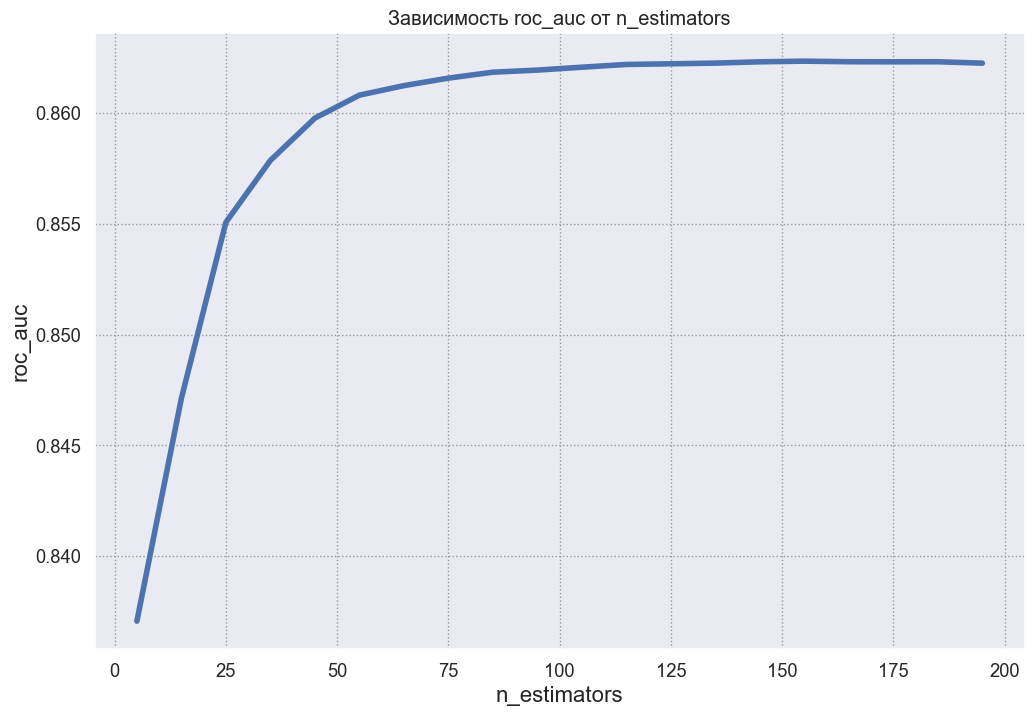

In [122]:
'''посмотрим на график зависимости auc_score от числа оценщиков'''
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(ax=ax, y=results_estimators_gbc, x=range(5,max_n_estimators_gbc, 10), linewidth=4)
ax.set(xlabel='n_estimators', ylabel='roc_auc', 
            title='Зависимость roc_auc от n_estimators')    
plt.show() 

# далее выставлю n_estimators = 150

In [123]:
gbc_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",  GradientBoostingClassifier(n_estimators=150, random_state=0, verbose=3))
]) 

# print('\n'.join(gbc_pipeline.get_params().keys()))

# пространство гиперпараметров
gbc_space={
    'model__learning_rate': hp.choice('learning_rate', options=[0.005, 0.01, 0.03, 0.05, 0.1, 0.2, 0.3]), # скорость обучения
#     'model__learning_rate': hp.uniform('learning_rate', 0.0001, 0.3), # скорость обучения
    'model__loss': hp.choice('loss', options=['log_loss', 'deviance', 'exponential']), # loss-функция
    'model__criterion': hp.choice('criterion', options=['friedman_mse', 'squared_error']), # критерий разбиения
    'model__max_depth': hp.choice('max_depth', options=range(3, 30)), # максимальная глубина деревьев
    'model__subsample': hp.choice('subsample', options=[0.6, 0.7, 0.8, 0.9, 1.0]), # доля данных для построения каждого дерева
    'model__min_samples_leaf': hp.choice('min_leaf', options=[10, 25, 50, 75, 100, 
                                                              150]),  # Мин число образцов, необходимое для нахождения в листе
    'model__max_features':  hp.choice('features', 
                                      options=['auto', 'sqrt', 'log2', None]), # Количество признаков для учета при разделении
    'model__ccp_alpha': hp.uniform('ccp_alpha', 0.0, 0.01), # параметр сложности для обрезки дерева
    'model__n_iter_no_change': hp.choice('no_change', options=[5, 10, 15, 25, 50]) # число итераций, после чего завершается 
                                                                               # обучение, если не было прогресса
                                                                             
}

In [124]:
# подбор оптимальных гиперпараметров и сохранение результатов
best_gbc_params, history_gbc = get_hp_results(gbc_pipeline, gbc_space, max_evals=200)

100%|██████████████████████████████████████████████████████████████████| 200/200 [2:28:01<00:00, 44.41s/trial, best loss: -0.8640261164650245]


roc_auc       std                                             params  \
152  0.864026  0.003728  {'model__ccp_alpha': 0.00012425372073062064, '...   
145  0.863764  0.003707  {'model__ccp_alpha': 0.0001616297934881029, 'm...   
196  0.863431  0.003505  {'model__ccp_alpha': 0.00018980140927212712, '...   
90   0.863303  0.003442  {'model__ccp_alpha': 2.1160405016474556e-05, '...   
34   0.863302  0.003749  {'model__ccp_alpha': 9.668642209202378e-06, 'm...   

     model__ccp_alpha model__criterion  model__learning_rate  model__loss  \
152          0.000124    squared_error                  0.03  exponential   
145          0.000162    squared_error                  0.03  exponential   
196          0.000190    squared_error                  0.03  exponential   
90           0.000021     friedman_mse                  0.03  exponential   
34           0.000010    squared_error                  0.03  exponential   

     model__max_depth model__max_features  model__min_samples_leaf  \
152                 7                None                       75   
145                 7                None                       75   
196                 7                None                       75   
90                  7                log2                       25   
34                  7                None                       75   

     model__n_iter_no_change  model__subsample  
152                       50               0.7  
145                       50               0.7  
196                       50               0.7  
90                        15               0.9  
34                        25               0.7

In [293]:
history_gbc.drop(columns=['params']).head()

roc_auc       std  model__ccp_alpha model__criterion  \
152  0.864026  0.003728          0.000124    squared_error   
145  0.863764  0.003707          0.000162    squared_error   
196  0.863431  0.003505          0.000190    squared_error   
90   0.863303  0.003442          0.000021     friedman_mse   
34   0.863302  0.003749          0.000010    squared_error   

     model__learning_rate  model__loss  model__max_depth model__max_features  \
152                  0.03  exponential                 7                None   
145                  0.03  exponential                 7                None   
196                  0.03  exponential                 7                None   
90                   0.03  exponential                 7                log2   
34                   0.03  exponential                 7                None   

     model__min_samples_leaf  model__n_iter_no_change  model__subsample  
152                       75                       50               0.7  
145                       75                       50               0.7  
196                       75                       50               0.7  
90                        25                       15               0.9  
34                        75                       25               0.7

In [125]:
# Для лучшей модели накопим бОльшую статистику (как и в предыдущих случаях)

best_gbc_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",  GradientBoostingClassifier(n_estimators=150, random_state=0, verbose=3, **best_gbc_params))
]) 

# результаты
gbc_res = get_score_statistic(best_gbc_pipeline)

Среднее: 0.8639361351513327
СКО: 0.005436268420975079


# 6 Полносвязная нейронная сеть

Попробуем простенькую полносвязную с 1-2 скрытыми слоями. В качестве функции активации нейронов возьмем Relu - достаточно популярную функцию.

In [126]:
# создание модели нейросети
def create_model():
    model = keras.Sequential([
          layers.Dense(64, input_dim=10, activation='relu'), # 'LeakyReLU'
          layers.Dense(16, activation='relu'),
          layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.0003), metrics=[keras.metrics.AUC()])
    return model

# create_model().summary()

# добавление early stopping rounds
early_callback = callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.00005,
    patience=20,
    verbose=0,
    mode='min',
    restore_best_weights=True, # нужно ли восстанавливать 'лучшие' веса
    start_from_epoch=15
)

# уменьшение скорости обучения, если val_score перестал меняться
lr_callback = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.7,
    patience=20,
    verbose=0,
    min_delta=0.00005,
    cooldown=5,
    min_lr=0.0001
)
# print('\n'.join(nn_pipeline.get_params().keys()))

#построение зависимости значения метрики от номера эпохи
def plot_loss(history):
    val_auc_key_name = sorted(history.keys())[-2]
    plt.plot(history[val_auc_key_name[4:]], label='auc')
    plt.plot(history[val_auc_key_name], label='val_auc')
    plt.ylim([0.4, 0.85])
    plt.title('Зависимость roc_auc от эпохи обучения нейронной сети')
    plt.xlabel('Epoch')
    plt.ylabel('auc')
    plt.legend()
    plt.grid(True)

In [127]:
# Neural_network pipeline
nn_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model", KerasClassifier(model=create_model, epochs=150, batch_size=1000,  validation_split=0.2, 
                              shuffle=True, verbose=0, random_state=0)) # callbacks=[early_callback, lr_callback],
]) 

In [128]:
# результаты
nn_res = get_score_statistic(nn_pipeline)

Среднее: 0.8343040191786355
СКО: 0.0061669310785675314


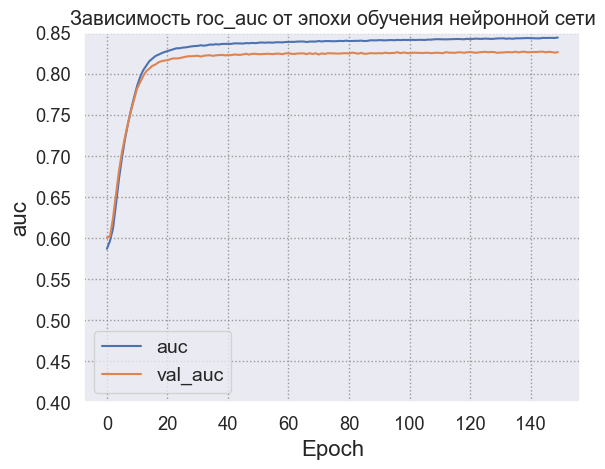

In [129]:
# визуализация обучения модели на всем датасете

# обучение
nn_pipeline.fit(X_train_final, y_train)

# непосредственно построение графика    
history = nn_pipeline.named_steps['model'].history_
plot_loss(history)

### Мысли:
Немного поварьировал вручную различные параметры модели (число слоев нейронов, число нейронов в каждом слое, функции активации,
batch_size и т.д.). В результате качество модели практически никак не улучшается. Явно результат похуже получается, чем при использовании бустинга. Поэтому не стал заниматься тонкой настройкой гиперпараметров.

# 7. Сравнение результатов всех моделей

In [294]:
method_names = ['Log', 'KNN', 'SGD', 'DT', 'DT+S', 'LGBM', 'CB', 'XG', 'GBC', 'NN']
pipeline_names = [best_logistic_clf, best_knn_pipeline, best_sgd_pipeline, best_tree_pipeline, best_tree_resampled_pipeline,
                 best_LGBM_pipeline, best_catboost_pipeline, best_xg_pipeline, best_gbc_pipeline, nn_pipeline]

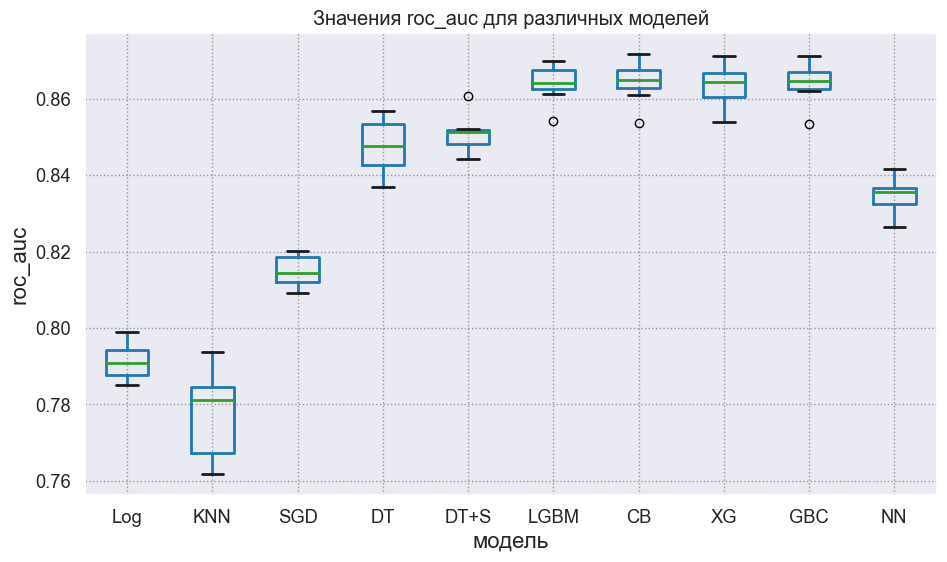

In [295]:
plot_all_scores('roc_auc', method_names, pipeline_names) 

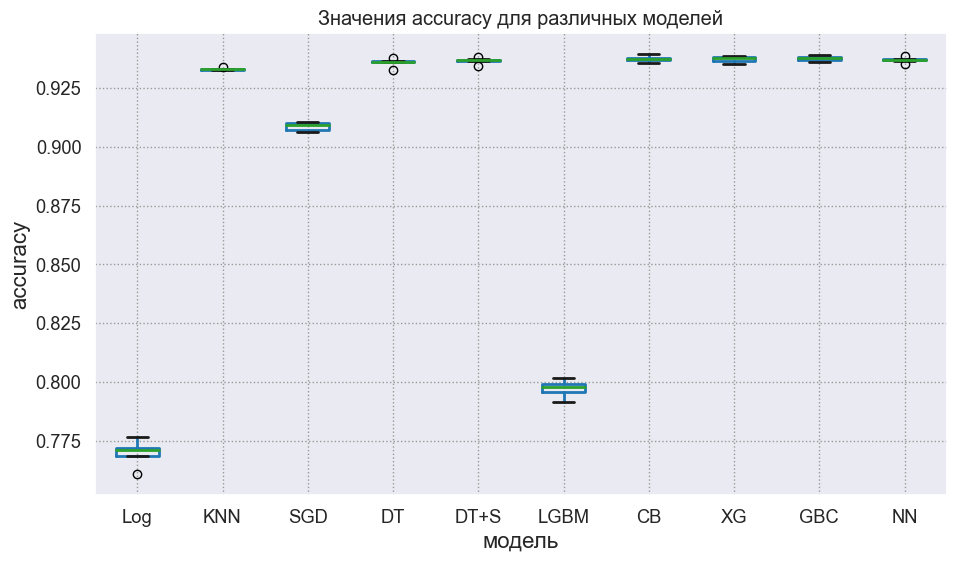

In [296]:
plot_all_scores('accuracy', method_names, pipeline_names) 

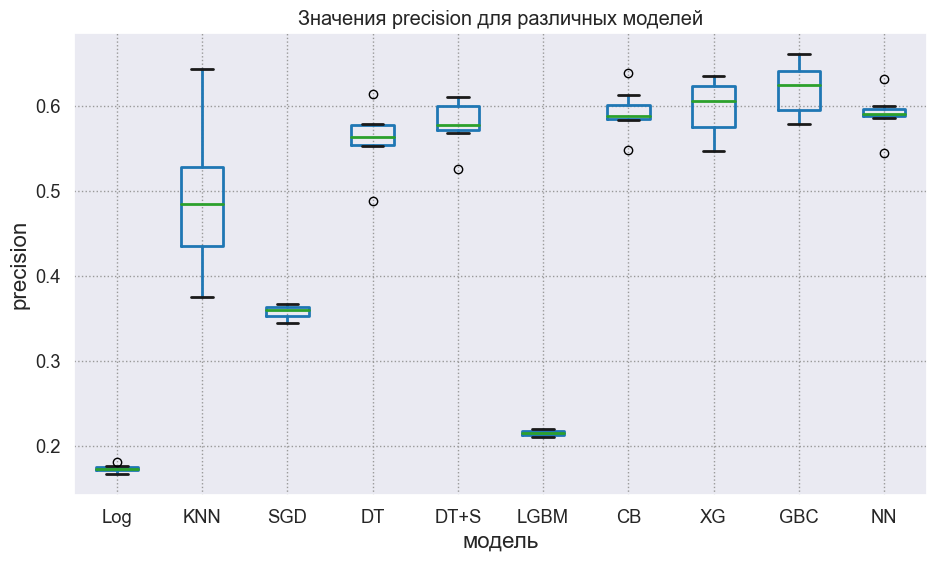

In [297]:
plot_all_scores('precision', method_names, pipeline_names) 

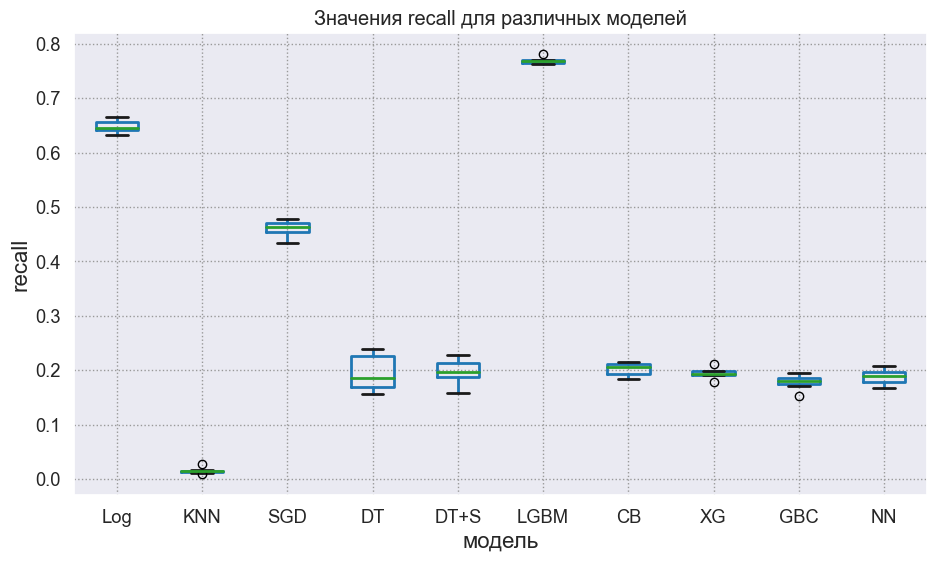

In [298]:
plot_all_scores('recall', method_names, pipeline_names) 

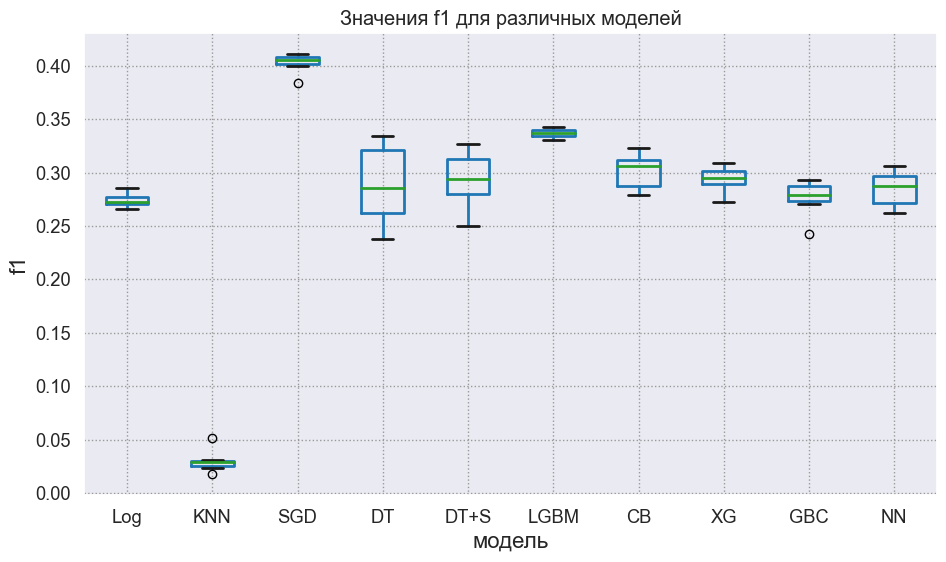

In [299]:
plot_all_scores('f1', method_names, pipeline_names) 

In [136]:
# t-критерий Стьюдента для связанных выборок CatBoost и LGBM
print(ttest_rel(catboost_res, LGBM_res))
# t-критерий Стьюдента для связанных выборок CatBoost и XG
print(ttest_rel(catboost_res, xg_res))
# t-критерий Стьюдента для связанных выборок CatBoost и GBC
print(ttest_rel(catboost_res, gbc_res))

TtestResult(statistic=4.476581594391534, pvalue=4.5316501934959624e-05, df=49)
TtestResult(statistic=9.729760415466597, pvalue=4.958660290204228e-13, df=49)
TtestResult(statistic=8.460688699874753, pvalue=3.8061323700132013e-11, df=49)


## Вывод: 
0. Напомню, что классы сильно несбалансированы, поэтому использовать метрику accuracy - это не рационально. Однако все же соответствующий график был построен. Почти все классификаторы имеют accuracy около 93%, кроме LGBM, SGD и логистической регрессии.
1. С точки зрения roc_auc лучшие значения достигаются при использовании бустингов (около 0.86 получается таким образом достичь).
2. Precision практически у всех алгоритмов в районе 60% (за исключением логистической регрессии, LGBM классификатора и SGD).
3. Однако LGBM, SGD и логистическая регрессия имеют большее значение recall (у LGBM почти 80%, у LogReg 65%, а у SGD 45%), в то время как остальные классификаторы имеют очень низкое значение этой метрики: около 20%.
4. Если же рассматривать среднее гармоническое метрик precision и recall (f-меру), то она наибольшая для SGD моедли, а затем следует LGBM классификатор (однако SGD дальше не рассматривался, т.к. у этого метода все же пониже roc_auc - главная метрика данной задачи).

Подытоживая все вышесказанное, можно выделить для дальнейшей работы 2 модели: `LGBM` и `CatBoost`.

CatBoost-модель имеет более высокий precision, что означает, что она более консервативна в определении дефолтных клиентов. То есть, она склонна относить к классу 1 только тех клиентов, которые она считает наиболее вероятными дефолтниками. Однако, у нее низкий recall, что означает, что она пропускает много дефолтных клиентов, которые на самом деле являются дефолтниками, но были отнесены к классу 0. 

LGBM-модель имеет более высокий recall, что означает, что она почти не пропускает  дефолтных клиентов. Однако, у нее низкий precision, что означает, что она может отнести к классу 1 клиентов, которые не являются дефолтниками. 
Если же сравнивать модели друг с другом, то CatBoost имеет более низкую f-меру, что означает, что она в целом менее эффективна в классификации дефолтных клиентов, чем LGBM.

# 8. Попытки улучшить

## 8.1 Генерация новых признаков

После того, как были рассмотрены различные модели для решения поставленной задачи, захотелось улучшить значение метрики. Почему-то до этого момента я не пытался сгенерировать новые признаки... Здесь попробую это исправить.
Далее работаю только с лучшими моделями, а именно с LGBMClassifier и CatboostClassifier.

In [144]:
X_tr = X_train_final.copy(deep=True)
X_te = X_test_final.copy(deep=True)

'''
С помощью feature-selector выяснил, что деление на возрастные группы - плохая идея
'''
# # Выделим возрастные группы и создадим флаги для каждой группы
# bins = [0, 25, 35, 45, 55, 65, 100]
# labels = ['<25', '25-34', '35-44', '45-54', '55-64', '65+']
# X_tr['age_group'] = pd.cut(X_tr['age'], bins=bins, labels=labels)
# X_tr = pd.get_dummies(X_tr, columns=['age_group'])

# Создадим новый признак: отношение месячного дохода к числу членов семьи
X_tr['income_per_member'] = X_tr['monthly_income'] / (X_tr['family_members']+1)
X_te['income_per_member'] = X_te['monthly_income'] / (X_te['family_members']+1)

# Создадим новый признак на основе Debt-to-income Ratio и количества займов и кредитных линий
X_tr['dti_cl'] = X_tr['debt_to_income'] * X_tr['credits_loans']
X_te['dti_cl'] = X_te['debt_to_income'] * X_te['credits_loans']

# Используем метод главных компонент (PCA) для получения линейных комбинаций исходных признаков
scaler = StandardScaler()
scaled_X_tr = scaler.fit_transform(X_tr)
scaled_X_te = scaler.transform(X_te)

pca = PCA(n_components=2)
pca_X_tr_data = pca.fit_transform(scaled_X_tr)
X_tr['pca_1'] = pca_X_tr_data[:, 0]
X_tr['pca_2'] = pca_X_tr_data[:, 1]

pca_X_te_data = pca.transform(scaled_X_te)
X_te['pca_1'] = pca_X_te_data[:, 0]
X_te['pca_2'] = pca_X_te_data[:, 1]

In [145]:
# масштабирование тренировочные данные
num_pipe = Pipeline([('scaler', StandardScaler())])
transformer_new_feat = ColumnTransformer(
                    transformers=[('num', num_pipe, X_tr.columns)],
                                   remainder='passthrough')
# масштабируем тренировочные данные
X_tr_scaled = transformer_new_feat.fit_transform(X_tr)
X_tr_scaled = pd.DataFrame(X_tr_scaled, columns=X_tr.columns, index=X_tr.index)
X_tr_scaled.head()

credit_card_utilization       age  overdue_30_59_days  debt_to_income  \
0                -0.023206  0.180851           -0.100356       -0.193570   
1                -0.022526 -0.561885            0.134870       -0.192529   
2                -0.021843  1.463760            0.134870       -0.193602   
3                -0.023022 -0.224278           -0.100356       -0.193400   
4                -0.020499  0.315894           -0.100356       -0.193632   

   monthly_income  credits_loans  overdue__more_than_90_days  mortgage_loans  \
0        0.101653       0.008435                   -0.063862       -0.016286   
1       -0.536898      -0.763362                   -0.063862       -0.896394   
2        1.437209       0.008435                   -0.063862        1.743930   
3       -0.286395       0.587283                   -0.063862       -0.016286   
4        1.879861       1.166131                   -0.063862        2.624038   

   overdue_60_89_days  family_members  income_per_member    dti_cl     pca_1  \
0           -0.057987        3.845629          -0.418188 -0.186071 -0.085290   
1           -0.057987       -0.670452          -0.531250 -0.185692  0.124634   
2           -0.057987       -0.670452           2.365505 -0.186098 -0.184516   
3           -0.057987        2.039197          -0.478148 -0.185806 -0.080751   
4           -0.057987        1.135981           0.616363 -0.186004 -0.288425   

      pca_2  
0 -0.085922  
1  0.098960  
2 -1.171541  
3  0.081033  
4 -0.706236

<AxesSubplot: >

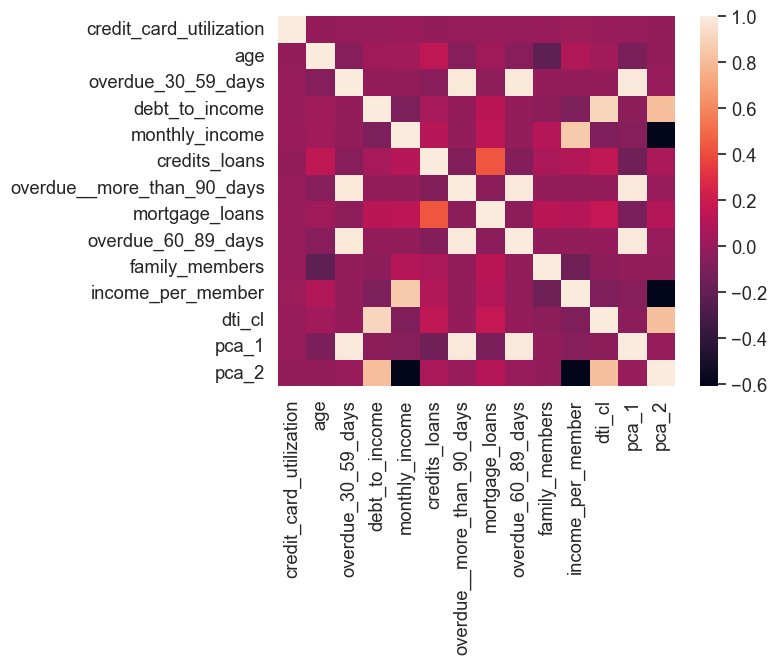

In [148]:
# матрица корреляций
sns.heatmap(X_tr.corr())

# имеются сильные корреляции между некоторыми признаками, однако нужно все-таки исследовать это подробнее: может признаки важны.

С помощью feature_selector исследую то, какие признаки нужно удалить, а какие - нет.

4 features with a correlation magnitude greater than 0.90.

Training Gradient Boosting Model


0 features with zero or negative importance after one-hot encoding.



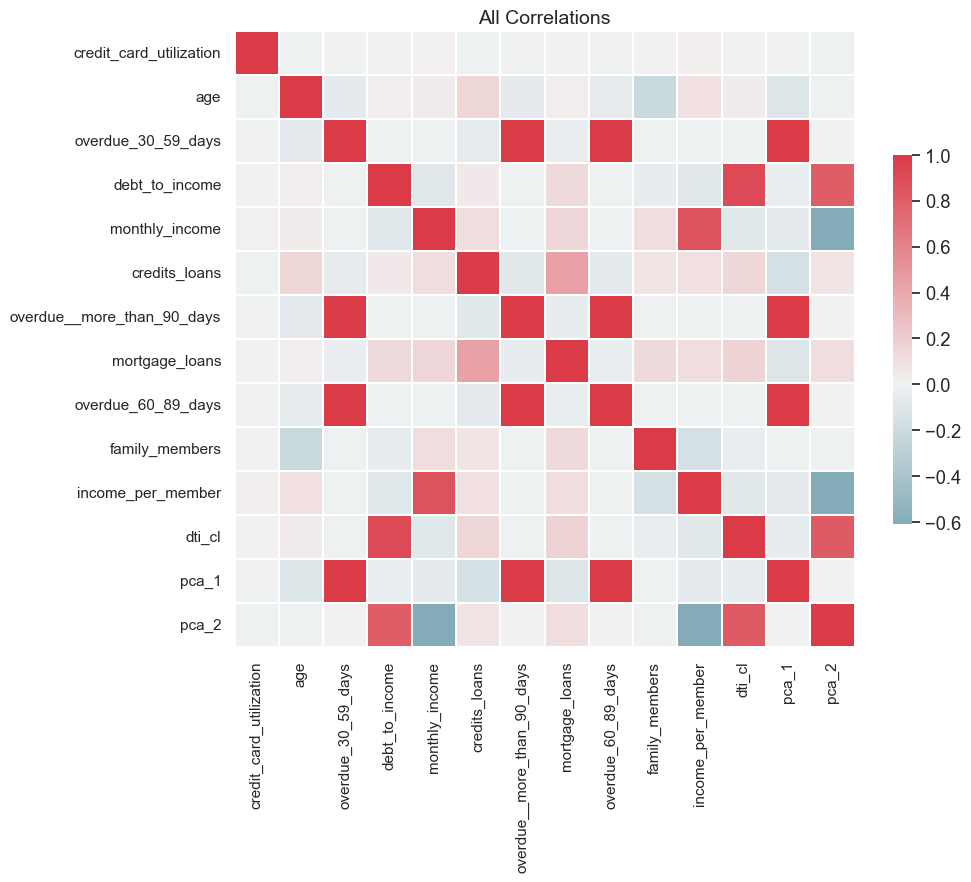

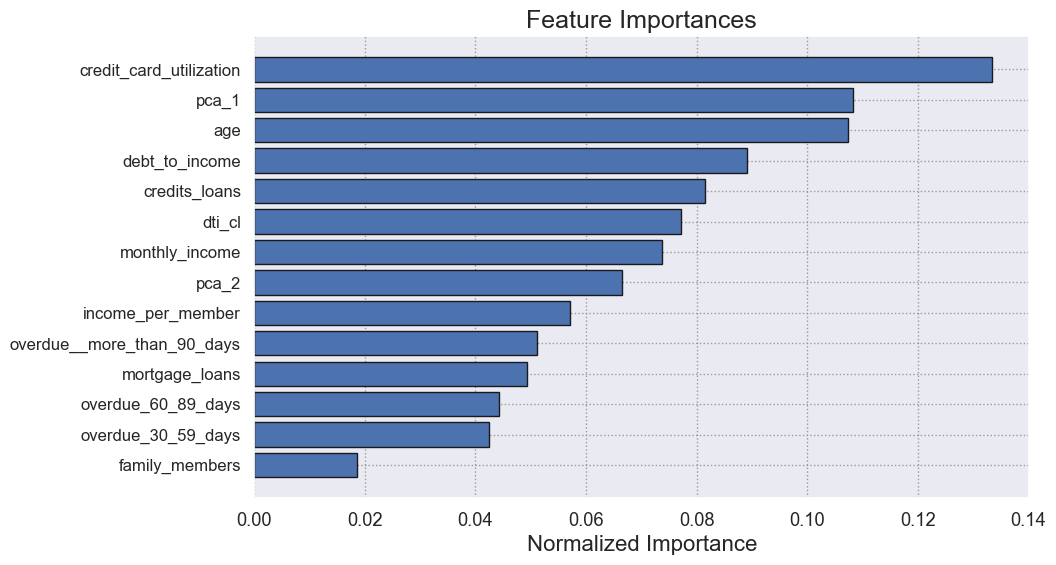

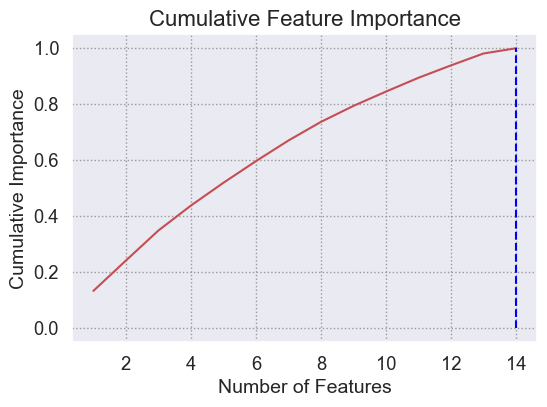

14 features required for 0.99 of cumulative importance
13 features required for cumulative importance of 0.99 after one hot encoding.
1 features do not contribute to cumulative importance of 0.99.




In [139]:
# создание feature selector
fs1 = FeatureSelector(data = X_tr, labels = y_train)

# порог, выше которого парная корреляция считается большой
PAIR_CORRELATION_MAX = 0.9 

'''фичи, парная корреляция между которых очень сильная'''
fs1.identify_collinear(correlation_threshold = PAIR_CORRELATION_MAX)
fs1.plot_collinear(plot_all=True) 
collinear_features_last = fs1.ops['collinear'] # список таких признаков
fs1.record_collinear # подробная информация о сильно коррелирующих признаках

#Проведем пробное обучение модели с помощью LGBM классификатора, чтобы выяснить наименее важные фичи (фичи нулевой важности)
NUM_FEATURES_FOR_PLOT=14
THRESHOLD_IMPORTANCE=0.99

'''фичи нулевой важности'''
fs1.identify_zero_importance(task='classification', eval_metric='auc',
                            n_iterations=20)

zero_importance_features_last=fs1.ops['zero_importance'] #список таких признаков

'''
Построение графиков: 1ый - самые важные признаки, 
2ой - распределение относительной важности признаков + определение количества
признаков, относительная важность которых больше threshold'''
fs1.plot_feature_importances(threshold = THRESHOLD_IMPORTANCE, 
                            plot_n = NUM_FEATURES_FOR_PLOT)

'''
наименее важные признаки, которые не нужны для достижения cumulative_importance от
общей важности признаков (решил не искать их)
'''
fs1.identify_low_importance(cumulative_importance = 0.99)
low_importance_features = fs1.ops['low_importance']
print()

### CatBoost

In [149]:
# подбор n_estimators
max_cb = 250
results_cb = []

for num_est in range(100, max_cb, 2):
    cb_model = CatBoostClassifier(n_estimators=num_est, random_state=0, 
                                        silent=True) # class_weights=class_weights
    roc_auc = cross_val_score(cb_model, X_tr_scaled, y_train.target, cv=3, scoring='roc_auc')
    # сохраняем скор
    results_cb.append(roc_auc.mean()) 

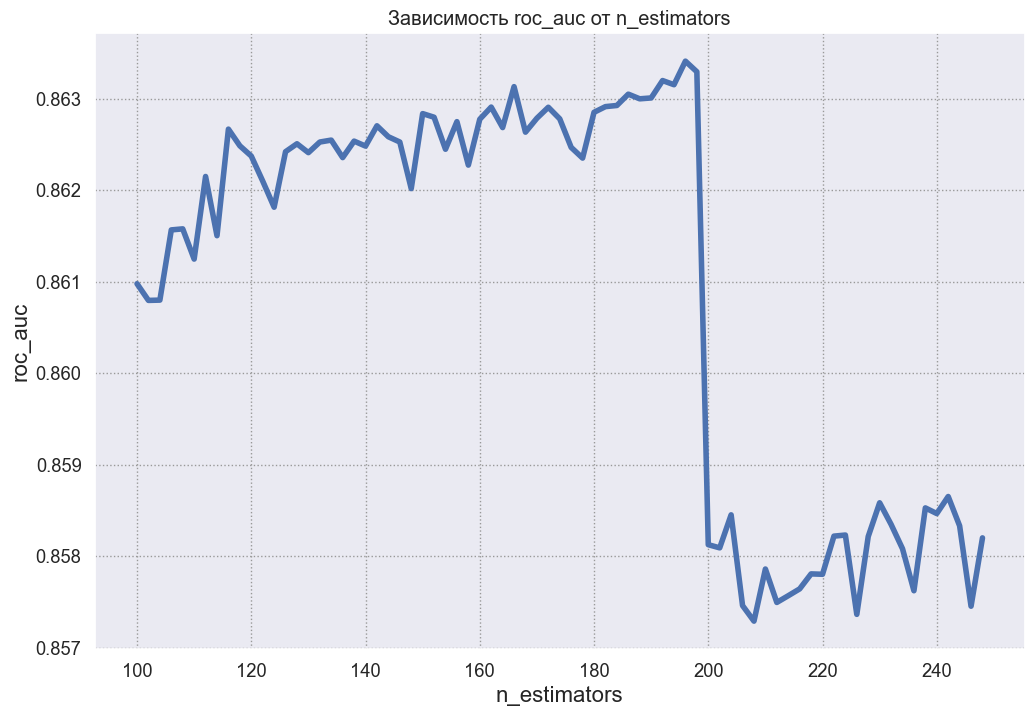

In [150]:
'''посмотрим на график зависимости auc_score от числа оценщиков'''
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(ax=ax, y=results_cb, x=range(100,max_cb, 2), linewidth=4)
ax.set(xlabel='n_estimators', ylabel='roc_auc', 
            title='Зависимость roc_auc от n_estimators')    
plt.show() 

# далее выставлю n_estimators = 190

In [151]:
cb_pipeline_new_feat = Pipeline([
    ("transformer", transformer_new_feat),  
    ("model",  CatBoostClassifier(n_estimators=190, random_state=0, silent=True)) 
]) 

In [152]:
# подбор оптимальных гиперпараметров и сохранение результатов
cb_last_params, history_cb_last = get_hp_results(cb_pipeline_new_feat, catboost_space, max_evals=200, X=X_tr)

100%|██████████████████████████████████████████████████████████████████| 200/200 [2:05:10<00:00, 37.55s/trial, best loss: -0.8644656269803367]


roc_auc       std                                             params  \
158  0.864466  0.003491  {'model__grow_policy': 'SymmetricTree', 'model...   
162  0.864458  0.003640  {'model__grow_policy': 'SymmetricTree', 'model...   
55   0.864447  0.003780  {'model__grow_policy': 'Depthwise', 'model__le...   
188  0.864432  0.003662  {'model__grow_policy': 'SymmetricTree', 'model...   
155  0.864423  0.003630  {'model__grow_policy': 'SymmetricTree', 'model...   

    model__grow_policy  model__learning_rate  model__max_depth  \
158      SymmetricTree                  0.05                11   
162      SymmetricTree                  0.05                11   
55           Depthwise                  0.10                11   
188      SymmetricTree                  0.05                11   
155      SymmetricTree                  0.05                11   

     model__min_child_samples  model__reg_lambda  model__subsample  
158                        10          14.990222               0.8  
162                        10          14.203422               0.8  
55                         25          52.608541               0.6  
188                        10          15.190112               0.8  
155                        10          15.087809               0.8

In [153]:
# Для лучшей модели накопим бОльшую статистику (как и в предыдущих случаях)

cb_best_pipeline = Pipeline([
    ("transformer", transformer_new_feat),  
    ("model",   CatBoostClassifier(n_estimators=190, random_state=0, silent=True, **cb_last_params))
])

# результаты
catboost_res_last = get_score_statistic(cb_best_pipeline, X=X_tr)

Среднее: 0.8643225835468324
СКО: 0.005622986278441732


### LGBM

In [154]:
# подбор n_estimators
max_lgbm = 100
results_lgbm = []

for num_est in range(2, max_lgbm, 1):
    lgbm_model = LGBMClassifier(n_estimators=num_est, random_state=0, n_jobs=-1, class_weight='balanced')
    roc_auc = cross_val_score(lgbm_model, X_tr_scaled, y_train.target, cv=3, scoring='roc_auc')
    # сохраняем скор
    results_lgbm.append(roc_auc.mean()) 

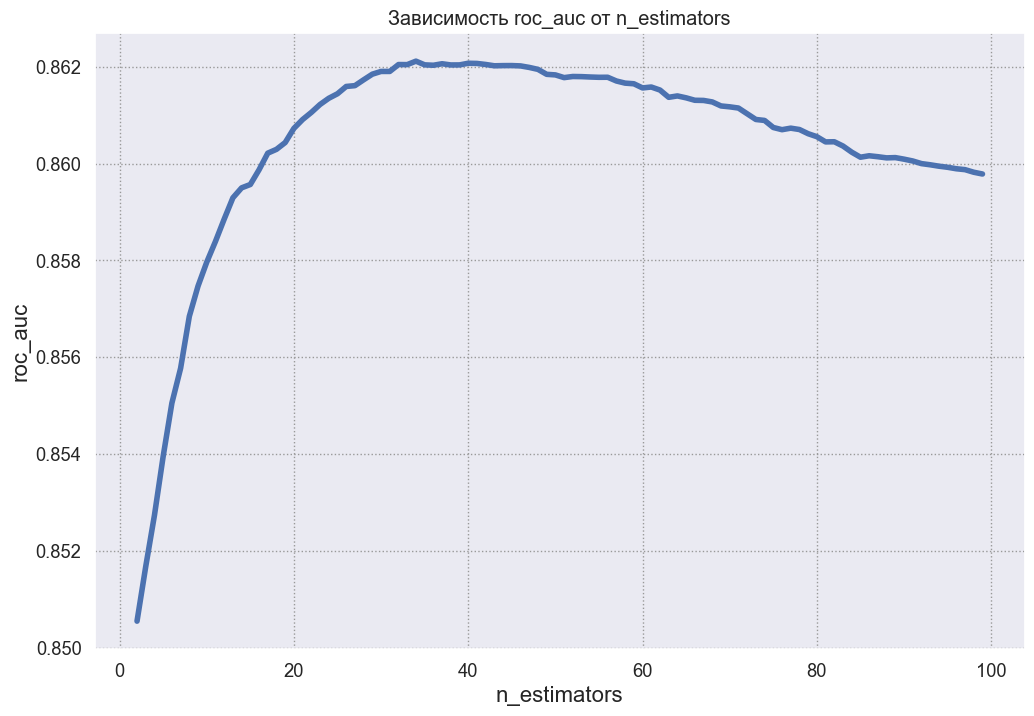

In [155]:
'''посмотрим на график зависимости auc_score от числа оценщиков'''
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(ax=ax, y=results_lgbm, x=range(2,max_lgbm, 1), linewidth=4)
ax.set(xlabel='n_estimators', ylabel='roc_auc', 
            title='Зависимость roc_auc от n_estimators')    
plt.show() 

# далее выставлю n_estimators = 40

In [156]:
lgbm_last_pipeline = Pipeline([
    ("transformer", transformer_new_feat),  
    ("model",  LGBMClassifier(n_estimators=40, random_state=0, n_jobs=-1, class_weight='balanced'))
]) 

In [157]:
# подбор оптимальных гиперпараметров и сохранение результатов
lgbm_last_params, lgbm_cb_last = get_hp_results(lgbm_last_pipeline, LGBM_space, max_evals=200, X=X_tr)

100%|████████████████████████████████████████████████████████████████████| 200/200 [04:45<00:00,  1.43s/trial, best loss: -0.8628601730149127]


roc_auc       std                                             params  \
151  0.862860  0.003547  {'model__boosting_type': 'gbdt', 'model__learn...   
140  0.862784  0.003520  {'model__boosting_type': 'gbdt', 'model__learn...   
192  0.862750  0.003468  {'model__boosting_type': 'gbdt', 'model__learn...   
153  0.862745  0.003594  {'model__boosting_type': 'gbdt', 'model__learn...   
62   0.862733  0.003643  {'model__boosting_type': 'gbdt', 'model__learn...   

    model__boosting_type  model__learning_rate  model__max_depth  \
151                 gbdt                   0.2                28   
140                 gbdt                   0.2                 5   
192                 gbdt                   0.2                21   
153                 gbdt                   0.2                14   
62                  gbdt                   0.2                21   

     model__min_child_samples  model__reg_alpha  model__reg_lambda  \
151                       100         83.652752          33.366987   
140                       100         99.639129          42.832173   
192                        75         99.715089          48.960533   
153                       100         83.593695          33.671565   
62                         75         77.906037           2.666626   

     model__subsample  
151               0.8  
140               0.8  
192               0.8  
153               0.8  
62                1.0

In [158]:
# Для лучшей модели накопим бОльшую статистику (как и в предыдущих случаях)

lgbm_best_pipeline_last = Pipeline([
    ("transformer", transformer_new_feat),  
    ("model",   LGBMClassifier(n_estimators=40, random_state=0, n_jobs=-1, class_weight='balanced', **lgbm_last_params))
])

# результаты
lgbm_res_last = get_score_statistic(lgbm_best_pipeline_last, X=X_tr)

Среднее: 0.862874335157614
СКО: 0.005444574224845834


Сравнение с моделями, обученными на X_train_final

In [162]:
# t-критерий Стьюдента для связанных выборок CatBoost
print(ttest_rel(catboost_res_last, catboost_res))
# t-критерий Стьюдента для связанных выборок LGBM
print(ttest_rel(lgbm_res_last, LGBM_res))

TtestResult(statistic=-3.9747194547760634, pvalue=0.00023132731711175087, df=49)
TtestResult(statistic=-9.405897133513909, pvalue=1.4769699251783532e-12, df=49)


#### Вывод:
Добавление таких новых признаков не дало улучшения (отвергаем нулевую гипотезу о равенстве скоров моделей, значения сильно отрицательные => модели, обученные на `X_train_final` лучше, чем обученные на `X_tr`)

## 8.2 Блендинг моделей

Не стал заниматься блендингом всех подряд моделей: решил попробовать заблендить CatBoost и LGBM.

### 8.2.1 CatBoost+LGBM

In [163]:
vc_cb_lgbm = VotingClassifier([('catboost', best_catboost_pipeline), 
                               ('LGBM', best_LGBM_pipeline)], 
                              voting='soft')

In [164]:
# пространство гиперпараметров
vc_cb_lgbm_space = {'weights': hp.choice('weights', options=[[i, 1.0-i] for i in np.arange(0, 1.05, 0.05)])
}

In [165]:
# подбор оптимальных гиперпараметров и сохранение результатов
best_blend_cb_lgbm_params, history_blend_cb_lgbm = get_hp_results(vc_cb_lgbm, vc_cb_lgbm_space, max_evals=15)

100%|██████████████████████████████████████████████████████████████████████| 15/15 [04:36<00:00, 18.43s/trial, best loss: -0.8652330459473564]


roc_auc       std                                             params  \
6   0.865233  0.003725            {'weights': (0.9, 0.09999999999999998)}   
10  0.865065  0.003730                          {'weights': (0.75, 0.25)}   
13  0.865003  0.003738  {'weights': (0.7000000000000001, 0.29999999999...   
9   0.864940  0.003749                          {'weights': (0.65, 0.35)}   
2   0.864879  0.003761  {'weights': (0.6000000000000001, 0.39999999999...   

                                      weights  
6                  (0.9, 0.09999999999999998)  
10                               (0.75, 0.25)  
13  (0.7000000000000001, 0.29999999999999993)  
9                                (0.65, 0.35)  
2    (0.6000000000000001, 0.3999999999999999)

In [166]:
# Для лучшей модели накопим бОльшую статистику (как и в предыдущих случаях)
best_vc_cb_lgbm = VotingClassifier([('catboost', best_catboost_pipeline), 
                               ('LGBM', best_LGBM_pipeline)], 
                                   voting='soft', **best_blend_cb_lgbm_params)

# результаты
vc_cb_lgbm_res = get_score_statistic(best_vc_cb_lgbm, X=X_train_final)

Среднее: 0.8652758368605692
СКО: 0.005508350949858624


In [167]:
# t-критерий Стьюдента для связанных выборок CatBoost и блендинга
print(ttest_rel(catboost_res, vc_cb_lgbm_res))

TtestResult(statistic=-7.876097173639195, pvalue=2.956545030745122e-10, df=49)


#### Вывод:
Получили статистически значимый результат => vc_модель лучше, чем CatBoost.

### 8.2.2 Catboost+LGBM+NN

In [168]:
vc_cb_lgbm_nn = VotingClassifier([('catboost', best_catboost_pipeline), 
                                ('LGBM', best_LGBM_pipeline),
                                ('neural_network', nn_pipeline)], 
                                 voting='soft')

In [169]:
vc_cb_lgbm_nn_space = {'weights': hp.choice('weights', options=[[i, j, 1 - i - j] for i in np.arange(0.6, 1.0, 0.05) 
                                                         for j in np.arange(0, 1.05 - i, 0.05)])
}

In [170]:
# подбор оптимальных гиперпараметров и сохранение результатов
best_blend_cb_lgbm_nn_params, history_blend_cb_lgbm_nn = get_hp_results(vc_cb_lgbm_nn, vc_cb_lgbm_nn_space, max_evals=25)

100%|██████████████████████████████████████████████████████████████████████| 25/25 [31:59<00:00, 76.77s/trial, best loss: -0.8654577125947649]


roc_auc       std                                             params  \
21  0.865458  0.003455  {'weights': (0.8000000000000002, 0.05, 0.14999...   
20  0.865458  0.003455  {'weights': (0.8000000000000002, 0.05, 0.14999...   
10  0.865458  0.003455  {'weights': (0.8000000000000002, 0.05, 0.14999...   
22  0.865458  0.003455  {'weights': (0.8000000000000002, 0.05, 0.14999...   
16  0.865378  0.003624  {'weights': (0.9000000000000002, 0.05, 0.04999...   

                                            weights  
21  (0.8000000000000002, 0.05, 0.14999999999999986)  
20  (0.8000000000000002, 0.05, 0.14999999999999986)  
10  (0.8000000000000002, 0.05, 0.14999999999999986)  
22  (0.8000000000000002, 0.05, 0.14999999999999986)  
16  (0.9000000000000002, 0.05, 0.04999999999999975)

In [171]:
# Для лучшей модели накопим бОльшую статистику (как и в предыдущих случаях)
best_vc_cb_lgbm_nn = VotingClassifier([('catboost', best_catboost_pipeline), 
                                ('LGBM', best_LGBM_pipeline),
                                ('neural_network', nn_pipeline)], 
                                 voting='soft', **best_blend_cb_lgbm_nn_params)

# результаты
vc_cb_lgbm_nn_res = get_score_statistic(best_vc_cb_lgbm_nn, X=X_train_final)

Среднее: 0.8654386520925095
СКО: 0.0054983376018817205


In [172]:
# t-критерий Стьюдента для связанных выборок CatBoost и блендинга
print(ttest_rel(catboost_res, vc_cb_lgbm_res))
# t-критерий Стьюдента для связанных выборок блендинга трех моделей и блендинга LGBM+CB
print(ttest_rel(vc_cb_lgbm_nn_res, vc_cb_lgbm_res))

TtestResult(statistic=-7.876097173639195, pvalue=2.956545030745122e-10, df=49)
TtestResult(statistic=3.0916934547395156, pvalue=0.0032799126254139193, df=49)


#### Вывод:
Получили статистически значимый результат => блендинг CB+LGBM+NN лучше, чем блединг только CB+LGBM. Однако, считаю, что лучше все-таки блендинг только CatBoost и LGBM (график ниже показывает более высокое значение f-меры).

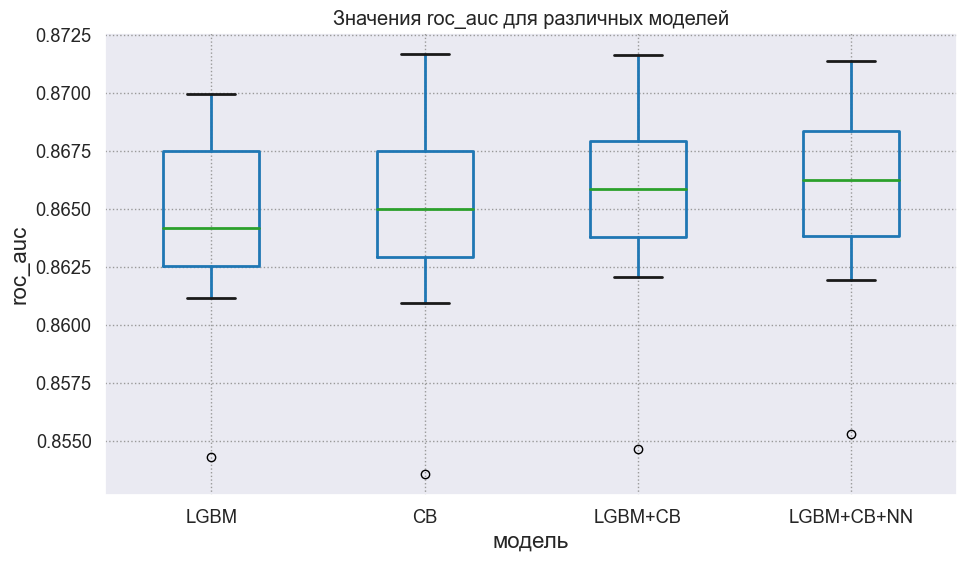

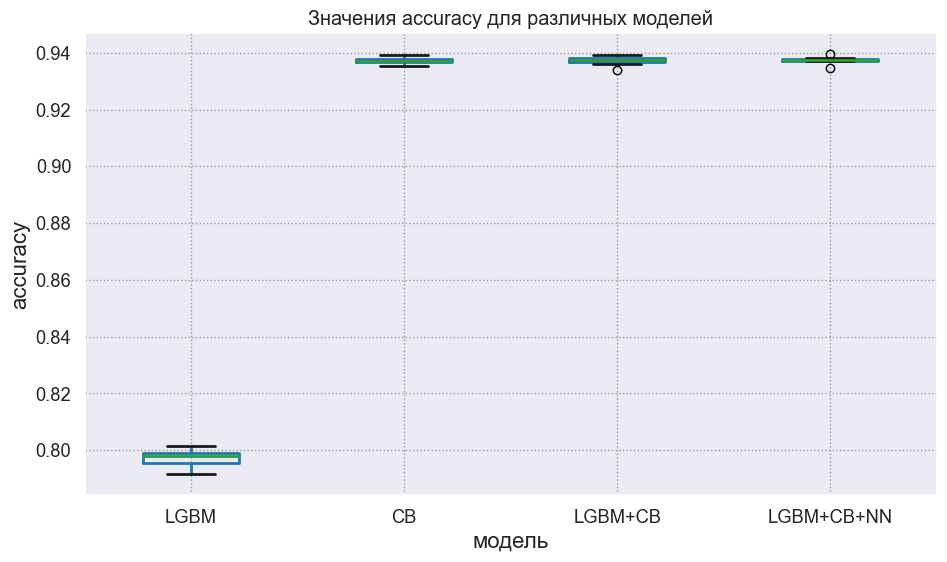

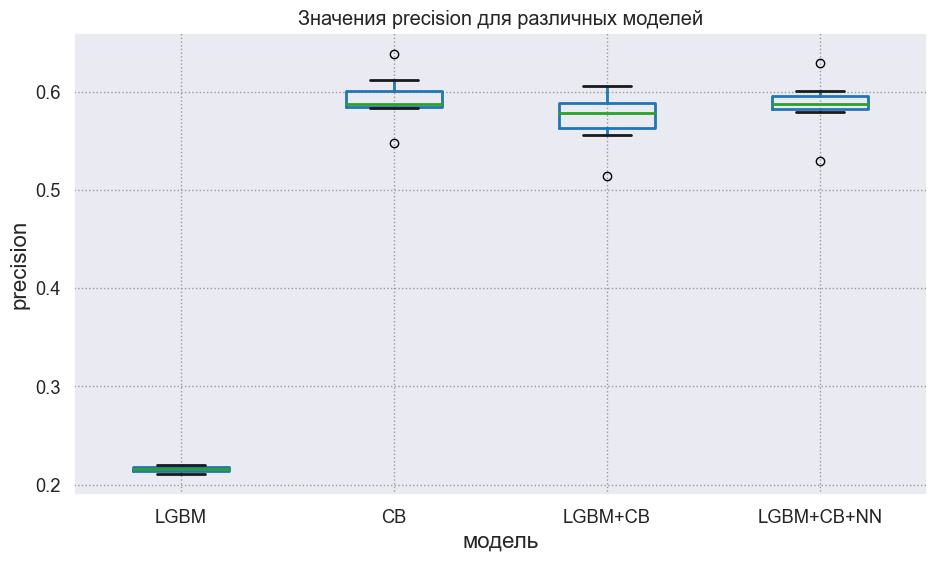

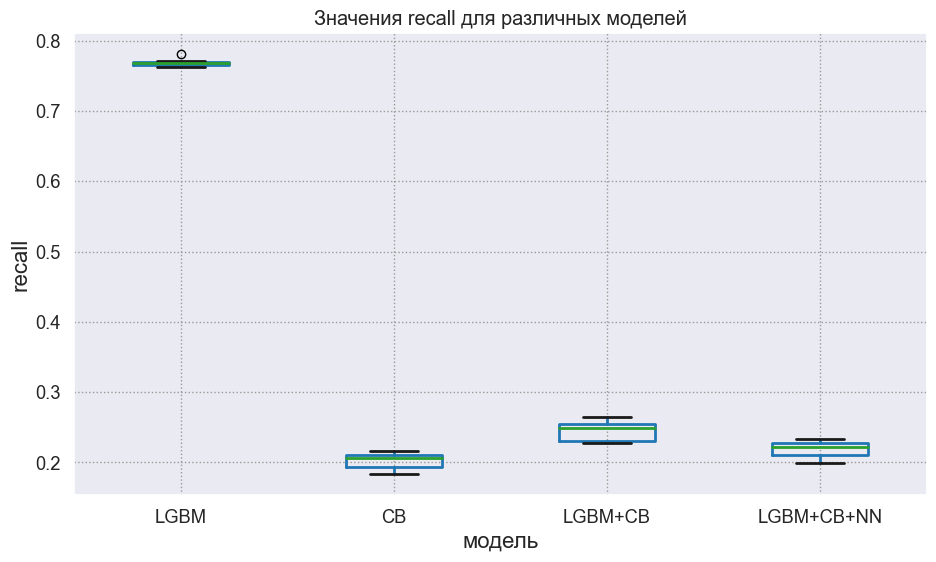

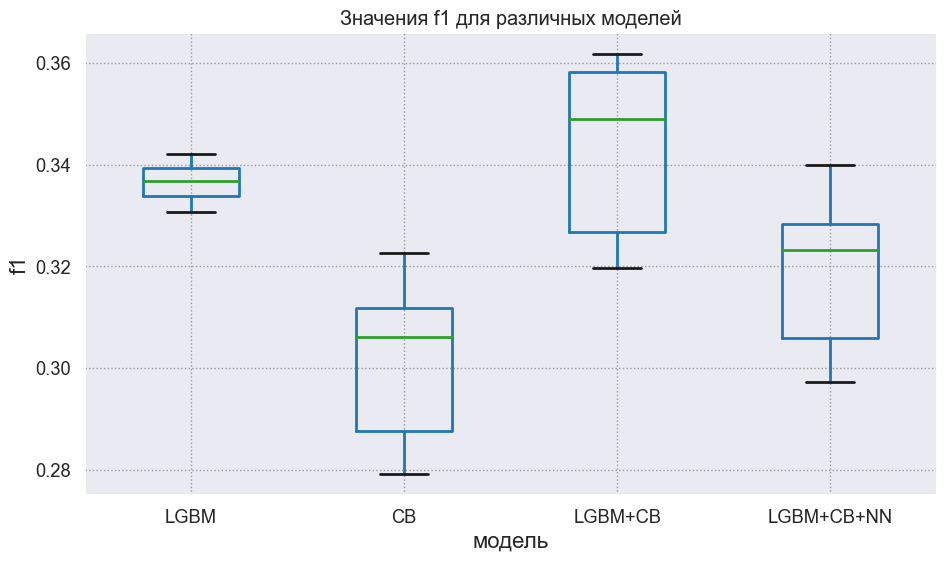

In [173]:
last_method_names = ['LGBM', 'CB', 'LGBM+CB', 'LGBM+CB+NN']
last_pipeline_names = [best_LGBM_pipeline, best_catboost_pipeline, best_vc_cb_lgbm, best_vc_cb_lgbm_nn]
plot_all_scores('roc_auc', last_method_names, last_pipeline_names)
plot_all_scores('accuracy', last_method_names, last_pipeline_names)
plot_all_scores('precision', last_method_names, last_pipeline_names)
plot_all_scores('recall', last_method_names, last_pipeline_names)
plot_all_scores('f1', last_method_names, last_pipeline_names)

# 9. Предсказание вероятностей для тестового набора данных

## 9.1 Модель, обученная на данных, обработанных с помощью KNN Imputer

In [175]:
# лучшая модель
best_pipeline = VotingClassifier([('catboost', best_catboost_pipeline), 
                                ('LGBM', best_LGBM_pipeline),
                                ('neural_network', nn_pipeline)], 
                                 voting='soft', **best_blend_cb_lgbm_nn_params)


In [176]:
best_pipeline.fit(X_train_final, y_train.target)

VotingClassifier(estimators=[('catboost',
                              Pipeline(steps=[('transformer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('num',
                                                                                Pipeline(steps=[('scaler',
                                                                                                 StandardScaler())]),
                                                                                Index(['credit_card_utilization', 'age', 'overdue_30_59_days',
       'debt_to_income', 'monthly_income', 'credits_loans',
       'overdue__more_than_90_days', 'mortgage_loans', 'overdue_60_8...
       'debt_to_income', 'monthly_income', 'credits_loans',
       'overdue__more_than_90_days', 'mortgage_loans', 'overdue_60_89_days',
       'family_members'],
      dtype='object'))])),
                                              ('model',
                                               KerasClassifier(batch_size=1000, epochs=150, model=<function create_model at 0x000001BC8C1F4CA0>, random_state=0, validation_split=0.2, verbose=0))]))],
                 voting='soft',
                 weights=(0.8000000000000002, 0.05, 0.14999999999999986))

0.8759575749593924
0.8825445712734286
(38876,)


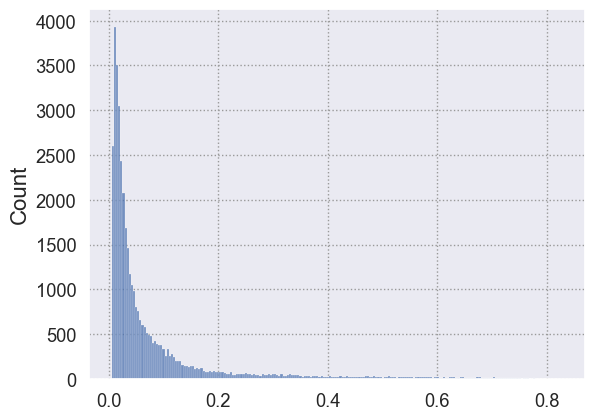

In [178]:
# посмотрим в последний раз как предсказывает модель результаты на отложенной выборке
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train_final, y_train, test_size=0.2, stratify=y_train, random_state=42)
print(roc_auc_score(y_train_1, best_pipeline.predict_proba(X_train_1)[:, 1]))
print(roc_auc_score(y_test_1, best_pipeline.predict_proba(X_test_1)[:, 1]))


# непосредственно предсказание "вероятностей"
res_to_commit = best_pipeline.predict_proba(X_test_final)[:, 1]
print(res_to_commit.shape)

# распределение вероятностей предсказаний
sns.histplot(res_to_commit)
plt.show()

In [179]:
# создание датафрейма для отправки на Kaggle
y_sample = pd.read_csv("srm23-spring-bank-scoring-case/y_test_sample.csv")
y_sample['target'] = res_to_commit
y_sample

index    target
0      143522  0.010074
1      116747  0.014956
2       66075  0.171266
3      133292  0.031689
4       83134  0.015586
...       ...       ...
38871   44475  0.078516
38872  103189  0.011774
38873   48732  0.025424
38874  135410  0.075012
38875   73457  0.009164

[38876 rows x 2 columns]

In [180]:
# сохранение результатов в виде csv файлов
y_sample.to_csv('submission_vc_all.csv', index=False) 
# На public этот submit дает score=0.86468

## 9.2 Модель, обученная на данных, пропуски в которых заполнены медианами

Не думаю, что модель, обученная на данных, в которых пропуски заполнены медианами - лучше. Однако, почему-то, public score выше...

In [181]:
# лучшая модель
best_pipeline_median = VotingClassifier([('catboost', best_catboost_pipeline), 
                                ('LGBM', best_LGBM_pipeline),
                                ('neural_network', nn_pipeline)], 
                                 voting='soft', **best_blend_cb_lgbm_nn_params)

In [182]:
best_pipeline_median.fit(X_train_median, y_train.target)

VotingClassifier(estimators=[('catboost',
                              Pipeline(steps=[('transformer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('num',
                                                                                Pipeline(steps=[('scaler',
                                                                                                 StandardScaler())]),
                                                                                Index(['credit_card_utilization', 'age', 'overdue_30_59_days',
       'debt_to_income', 'monthly_income', 'credits_loans',
       'overdue__more_than_90_days', 'mortgage_loans', 'overdue_60_8...
       'debt_to_income', 'monthly_income', 'credits_loans',
       'overdue__more_than_90_days', 'mortgage_loans', 'overdue_60_89_days',
       'family_members'],
      dtype='object'))])),
                                              ('model',
                                               KerasClassifier(batch_size=1000, epochs=150, model=<function create_model at 0x000001BC8C1F4CA0>, random_state=0, validation_split=0.2, verbose=0))]))],
                 voting='soft',
                 weights=(0.8000000000000002, 0.05, 0.14999999999999986))

0.876154238269827
0.8834608117390164
(38876,)


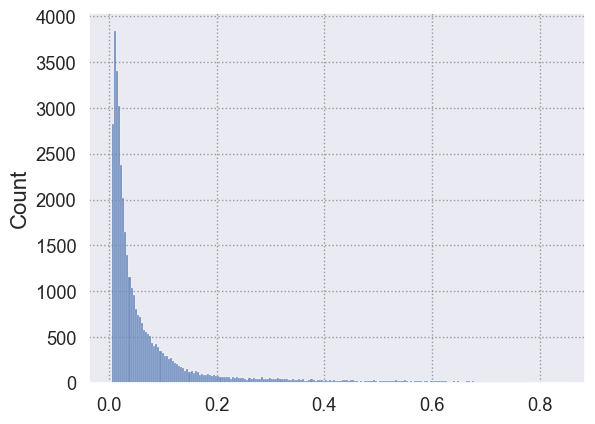

In [184]:
# посмотрим в последний раз как предсказывает модель результаты на отложенной выборке
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train_median, y_train, test_size=0.2, stratify=y_train, random_state=42)
print(roc_auc_score(y_train_1, best_pipeline_median.predict_proba(X_train_1)[:, 1]))
print(roc_auc_score(y_test_1, best_pipeline_median.predict_proba(X_test_1)[:, 1]))


# непосредственно предсказание "вероятностей"
res_to_commit_median = best_pipeline_median.predict_proba(X_test_median)[:, 1]
print(res_to_commit_median.shape)

# распределение вероятностей предсказаний
sns.histplot(res_to_commit_median)
plt.show()

In [185]:
# создание датафрейма для отправки на Kaggle
y_sample_median = pd.read_csv("srm23-spring-bank-scoring-case/y_test_sample.csv")
y_sample_median['target'] = res_to_commit_median
y_sample_median

index    target
0      143522  0.009281
1      116747  0.016961
2       66075  0.162988
3      133292  0.033503
4       83134  0.015583
...       ...       ...
38871   44475  0.086839
38872  103189  0.011989
38873   48732  0.025511
38874  135410  0.065156
38875   73457  0.009375

[38876 rows x 2 columns]

In [186]:
# сохранение результатов в виде csv файлов
y_sample_median.to_csv('submission_vc_all_median.csv', index=False) 
# На public этот submit дает score=0.86481

# 10. Сохранение данных

Сохранение данных для последующей загрузки в ноутбук `validation.ipynb`, где валидация моделей будет. Сохраним истории подбора гиперпараметров для бустингов, а также для Voting.

Еще сохраню данные X_train_final и X_test_final, X_train_median, X_test_median

In [192]:
history_LGBM.to_csv('srm23-spring-bank-scoring-case/history_LGBM.csv', index=False)
history_catboost.to_csv('srm23-spring-bank-scoring-case/history_catboost.csv', index=False)
history_xg.to_csv('srm23-spring-bank-scoring-case/history_xg.csv', index=False)
history_gbc.to_csv('srm23-spring-bank-scoring-case/history_gbc.csv', index=False)
history_blend_cb_lgbm.to_csv('srm23-spring-bank-scoring-case/history_blend_cb_lgbm.csv', index=False)
history_blend_cb_lgbm_nn.to_csv('srm23-spring-bank-scoring-case/history_blend_cb_lgbm_nn.csv', index=False)

X_train_final.to_csv('srm23-spring-bank-scoring-case/X_train_final.csv')
X_test_final.to_csv('srm23-spring-bank-scoring-case/X_test_final.csv')
X_train_median.to_csv('srm23-spring-bank-scoring-case/X_train_median.csv')
X_test_median.to_csv('srm23-spring-bank-scoring-case/X_test_median.csv')